# Importing Data, Libraries and First Look

## Import 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/dataset')

In [ ]:
import tarfile 
tar = tarfile.open('/content/drive/MyDrive/dataset/UrbanSound8K.tar.gz')
tar.extractall()
tar.close()

## Libraries

In [ ]:
# Required libraries
import os
import pandas as pd
import IPython as IP
import struct
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import librosa
import librosa.display
import pickle
import pathlib
import csv
import soundfile as sf
!pip install pydub
from pydub import AudioSegment
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
import pickle
import time
import struct


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset

In [ ]:
# Set your path to the original dataset
us8k_path = os.path.abspath('/content/UrbanSound8K' )

# Global settings
metadata_path = os.path.join(us8k_path, '/content/UrbanSound8K/metadata/UrbanSound8K.csv')
audio_path = os.path.join(us8k_path, '/content/UrbanSound8K/audio')

In [ ]:
print("Loading CSV file {}".format(metadata_path))

# Load metadata as a Pandas dataframe
metadata = pd.read_csv(metadata_path)

# Examine dataframe's head
metadata.head()

Loading CSV file /content/UrbanSound8K/metadata/UrbanSound8K.csv


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [ ]:
# Group-by folds
fold_count = metadata['fold'].value_counts()
fold_count

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

# Exploratory Data Analysis (EDA)

## MV, Duplicates, Balance

In [ ]:
# Check missing values in Metadata file
metadata.isnull().values.any()

False

In [ ]:
# Checking Duplicate Files in the Metadata File
metadata.duplicated(subset=['slice_file_name']).any()

False

[Text(0, 0, 'dog_bark'),
 Text(0, 0, 'children_playing'),
 Text(0, 0, 'car_horn'),
 Text(0, 0, 'air_conditioner'),
 Text(0, 0, 'street_music'),
 Text(0, 0, 'gun_shot'),
 Text(0, 0, 'siren'),
 Text(0, 0, 'engine_idling'),
 Text(0, 0, 'jackhammer'),
 Text(0, 0, 'drilling')]

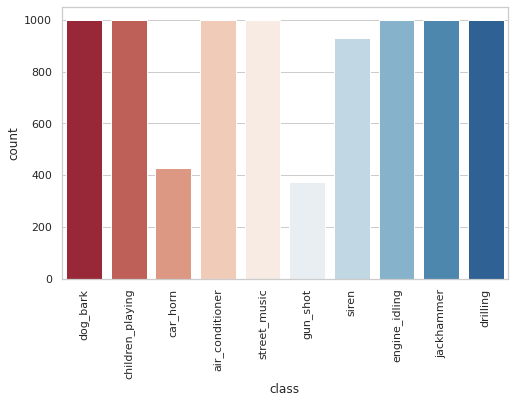

In [ ]:
# Checking the dataset is balanced or not 

plt.figure(figsize = (8,5))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="class", data=metadata, palette="RdBu")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [ ]:
# Class distribution
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

## Audio Properties

In [ ]:
def read_header(filename):
    wave = open(filename,"rb")
    riff = wave.read(12)
    fmat = wave.read(36)
    num_channels_string = fmat[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]
    sample_rate_string = fmat[12:16]
    sample_rate = struct.unpack("<I",sample_rate_string)[0]
    bit_depth_string = fmat[22:24]
    bit_depth = struct.unpack("<H",bit_depth_string)[0]
    return (num_channels, sample_rate, bit_depth)

In [ ]:
# Read every file header to collect audio properties
audiodata = []
for index, row in metadata.iterrows():
    id = index
    cat = str(row["class"])
    fold = 'fold'+str(row["fold"])
    name = str(row["slice_file_name"])
    file_name = os.path.join(audio_path, fold, name)
    audio_props = read_header(file_name)
    duration = row['end'] - row['start']
    audiodata.append((id, name, fold, cat, duration) + audio_props)

# Convert into a Pandas dataframe
audiodatadf = pd.DataFrame(audiodata, columns=['id', 'filename', 'fold', 'class', 'duration', 'channels','sample_rate','bit_depth'])



In [ ]:
audiodatadf


id            filename   fold             class  duration  channels  \
0        0    100032-3-0-0.wav  fold5          dog_bark  0.317551         2   
1        1  100263-2-0-117.wav  fold5  children_playing  4.000000         2   
2        2  100263-2-0-121.wav  fold5  children_playing  4.000000         2   
3        3  100263-2-0-126.wav  fold5  children_playing  4.000000         2   
4        4  100263-2-0-137.wav  fold5  children_playing  4.000000         2   
...    ...                 ...    ...               ...       ...       ...   
8727  8727     99812-1-2-0.wav  fold7          car_horn  4.000000         2   
8728  8728     99812-1-3-0.wav  fold7          car_horn  2.142545         2   
8729  8729     99812-1-4-0.wav  fold7          car_horn  3.505983         2   
8730  8730     99812-1-5-0.wav  fold7          car_horn  2.532098         2   
8731  8731     99812-1-6-0.wav  fold7          car_horn  2.532099         2   

      sample_rate  bit_depth  
0           44100         16  
1           44100         16  
2           44100         16  
3           44100         16  
4           44100         16  
...           ...        ...  
8727        44100         16  
8728        44100         16  
8729        44100         16  
8730        44100         16  
8731        44100         16  

[8732 rows x 8 columns]

In [ ]:
audiodatadf.describe()

id     duration     channels    sample_rate    bit_depth
count  8732.000000  8732.000000  8732.000000    8732.000000  8732.000000
mean   4365.500000     3.607904     1.915369   48456.979272    18.780119
std    2520.855609     0.973570     0.278348   15300.080707     4.227168
min       0.000000     0.054517     1.000000    8000.000000     4.000000
25%    2182.750000     4.000000     2.000000   44100.000000    16.000000
50%    4365.500000     4.000000     2.000000   44100.000000    16.000000
75%    6548.250000     4.000000     2.000000   48000.000000    24.000000
max    8731.000000     4.000000     2.000000  192000.000000    32.000000

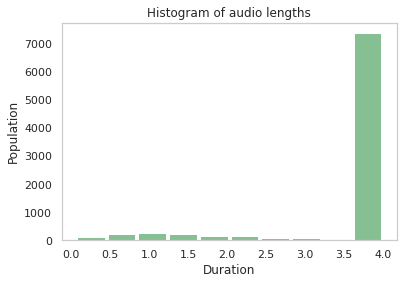

Greater than 3 seconds: 7468
Lower than 3 seconds: 1264
Lower than 1.5 seconds: 785


In [ ]:
# Audio Lengths (duration)
# Plot audio lengths distribution
plt.hist(audiodatadf['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = audiodatadf['duration'][audiodatadf['duration'] > 3].count()
lt_3sec = audiodatadf['duration'][audiodatadf['duration'] < 3].count()
lt_15sec = audiodatadf['duration'][audiodatadf['duration'] < 1.5].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 seconds: {}".format(lt_3sec))
print("Lower than 1.5 seconds: {}".format(lt_15sec))

In [ ]:
# Audio Channels
print(audiodatadf.channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: channels, dtype: float64


In [ ]:
# Bit Depths
print("Bit depths:\n")
print(audiodatadf.bit_depth.value_counts(normalize=True))

Bit depths:

16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: bit_depth, dtype: float64


In [ ]:
# Sample Rates
print("Sample rates:\n")
print(audiodatadf.sample_rate.value_counts(normalize=True))

Sample rates:

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


In [ ]:
# Plot wavesounds for each audio class
# Getting a random audio file for each class
np.random.seed(0)
random_class_df = pd.DataFrame(audiodatadf.groupby('class')['id'].apply(np.random.choice).reset_index())
random_class_df

class    id
0   air_conditioner  5389
1          car_horn  2208
2  children_playing  5039
3          dog_bark  1841
4          drilling  7414
5     engine_idling  5895
6          gun_shot  2610
7        jackhammer  3375
8             siren   156
9      street_music  7040

In [ ]:
random_class_merge = pd.merge(left = audiodatadf, right = random_class_df, left_on = 'id', right_on = 'id')
random_class_merge

id          filename   fold           class_x  duration  channels  \
0   156  102871-8-0-1.wav  fold2             siren  4.000000         2   
1  1841  146343-3-0-0.wav  fold8          dog_bark  4.000000         1   
2  2208  155129-1-0-0.wav  fold2          car_horn  0.103609         2   
3  2610  159710-6-0-0.wav  fold2          gun_shot  1.172459         2   
4  3375  169098-7-0-3.wav  fold2        jackhammer  4.000000         2   
5  5039  196071-2-0-0.wav  fold5  children_playing  1.333764         2   
6  5389  204240-0-0-0.wav  fold6   air_conditioner  4.000000         2   
7  5895   26184-5-4-0.wav  fold5     engine_idling  4.000000         2   
8  7040   61626-9-0-6.wav  fold4      street_music  4.000000         2   
9  7414   71171-4-1-4.wav  fold5          drilling  4.000000         2   

   sample_rate  bit_depth           class_y  
0        44100         16             siren  
1        44100         16          dog_bark  
2        44100         24          car_horn  
3        48000         24          gun_shot  
4        44100         24        jackhammer  
5        44100         16  children_playing  
6        44100         24   air_conditioner  
7        44100         16     engine_idling  
8        44100         16      street_music  
9        96000         24          drilling

In [ ]:
# Reading data for the random audio files selected
random_class_data = []

for idx in random_class_merge.index:  
    wav, sr = librosa.load(audio_path + '/' + str(random_class_merge['fold'][idx]) + '/' + str(random_class_merge['filename'][idx]))
    random_class_data.append(wav)

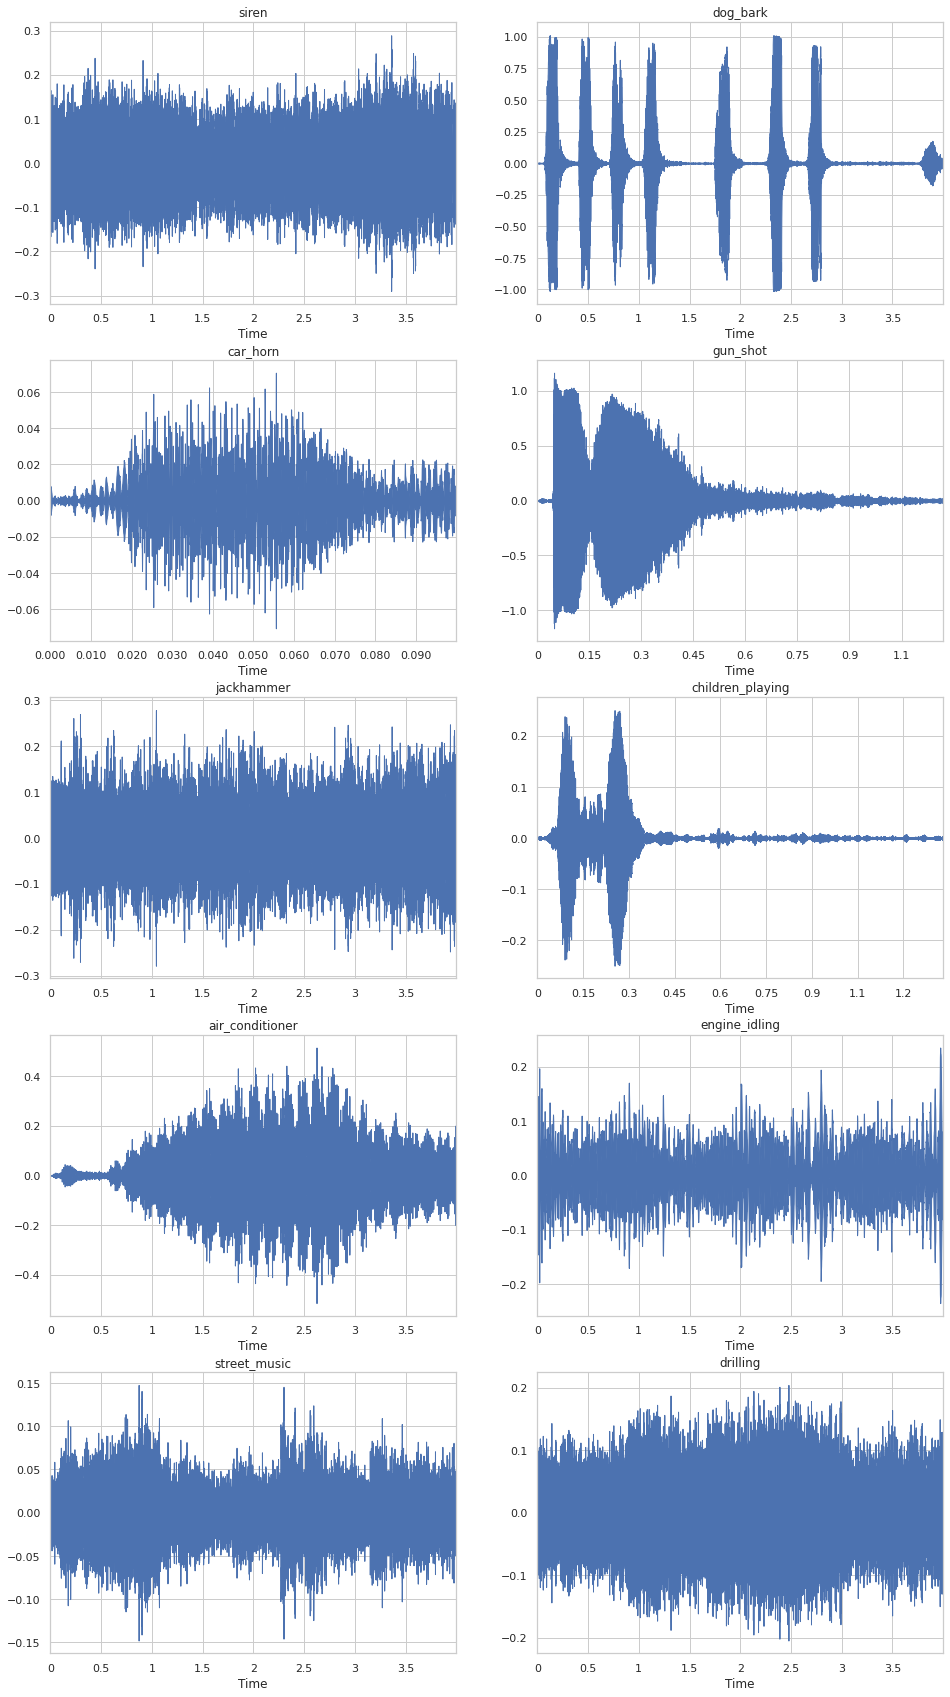

In [ ]:
# Plotting the waveforms for each class
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (16, 30))
for i in range(5):
    librosa.display.waveplot(random_class_data[2*i], sr = sr, ax = ax[i][0])
    ax[i][0].set_title(random_class_merge['class_x'][2*i])
    
    librosa.display.waveplot(random_class_data[2*i + 1], sr = sr, ax = ax[i][1])
    ax[i][1].set_title(random_class_merge['class_x'][2*i + 1])
    
plt.show()

# Features

## Overview

### Short-Time Fourier Transform (STFT)

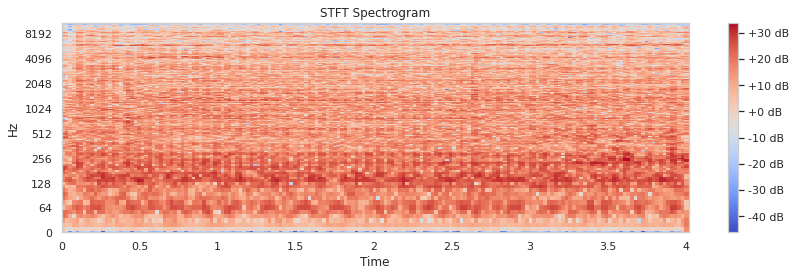

In [ ]:
# Selecting a random File 
row = metadata.sample(1)
file_path = audio_path + '/fold'+ str(row.iloc[0,5]) +'/' + str(row.iloc[0,0])

# Windowing
n_fft=2048
hop_length=512

# Load audio file
y, sr = librosa.load(file_path)

# Normalize between -1 and 1
normalized_y = librosa.util.normalize(y)

# Compute STFT
stft = librosa.core.stft(normalized_y, n_fft=n_fft, hop_length=hop_length)

# Convert sound intensity to log amplitude:
stft_db = librosa.amplitude_to_db(abs(stft))

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB');
plt.title('STFT Spectrogram')
plt.tight_layout()
plt.show()

### Mel Frequency Cepstral Coefficients (MFCCs)

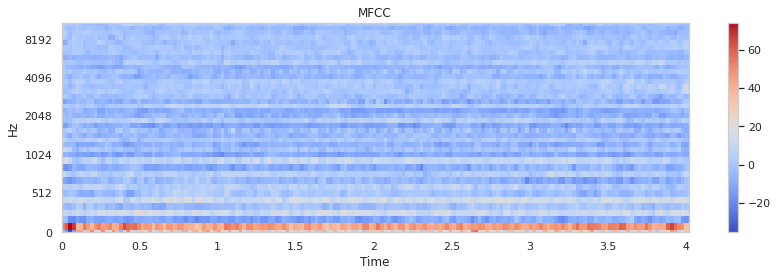

In [ ]:
# Generate MFCC coefficients
mfcc = librosa.feature.mfcc(normalized_y, sr, n_mfcc=40)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

### Mel Scaled Spectrogram

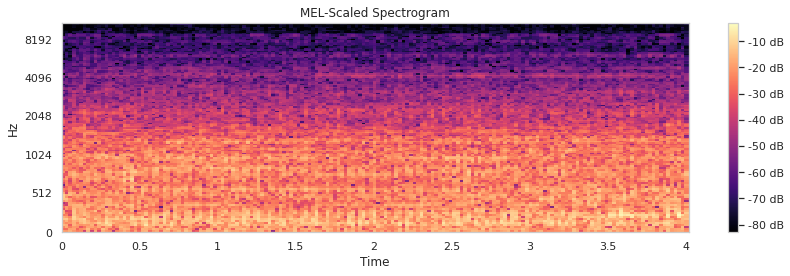

In [ ]:
#Mel scaled Filter Banks
n_mels = 128

# Generate mel scaled spectrogram
mel = librosa.feature.melspectrogram(S=stft, n_mels=n_mels)

# Convert sound intensity to log amplitude:
mel_db = librosa.amplitude_to_db(abs(mel))

# Normalize between -1 and 1
normalized_mel = librosa.util.normalize(mel_db)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');
plt.title('MEL-Scaled Spectrogram')
plt.tight_layout()
plt.show()

### Root-Mean-Square (RMS)

[Text(0.5, 1.0, 'log Power spectrogram')]

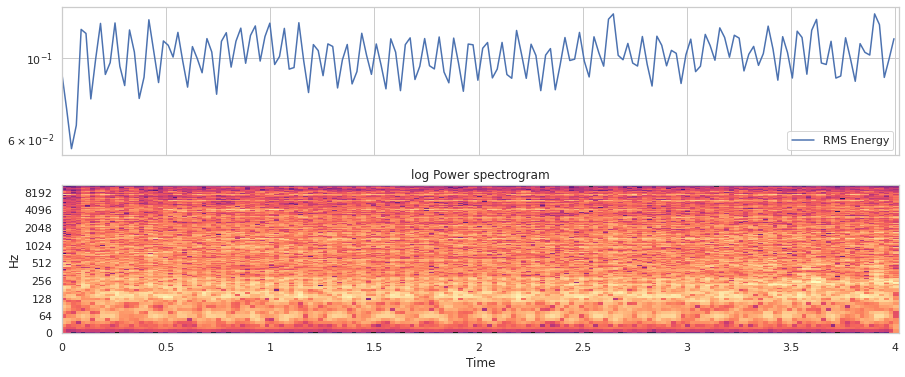

In [ ]:
# Get RMS value from each frame's magnitude value
S, phase = librosa.magphase(librosa.stft(normalized_y))
rms = librosa.feature.rms(S=S)

# Plot the RMS energy
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
plt.title('RMS')
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

### Zero Crossing Rate (ZCR)

Zero crossing rate: 27544


Text(0.5, 1.0, 'ZCR')

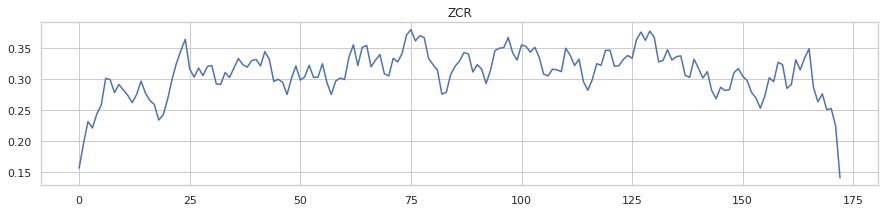

In [ ]:
# Get ZCR value from each frame
zcrs = librosa.feature.zero_crossing_rate(normalized_y)
print(f"Zero crossing rate: {sum(librosa.zero_crossings(normalized_y))}")

#Plotting ZCR
plt.figure(figsize=(15, 3))
plt.plot(zcrs[0])
plt.title('ZCR')

### Chroma (CHROMA)

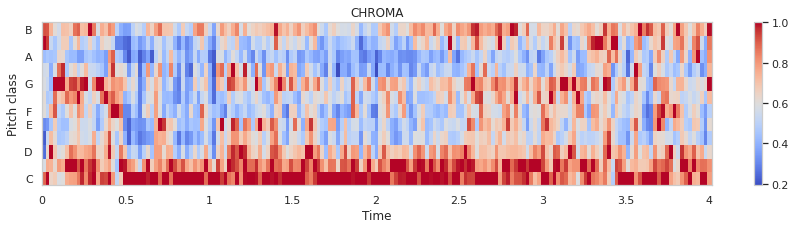

In [ ]:
# Get CHROMA value
hop_length = 512
chromagram = librosa.feature.chroma_stft(normalized_y, sr=sr, hop_length=hop_length)

# Plotting the CHROMA
fig, ax = plt.subplots(figsize=(15, 3))
img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title('CHROMA')
fig.colorbar(img, ax=ax)

### Spectral Centroid (SC) and Spectral Bandwidth (SB)

Text(0.5, 1.0, 'SC')

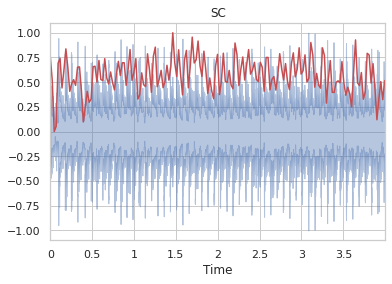

In [ ]:
# Spectral centroid
spectral_centroids = librosa.feature.spectral_centroid(normalized_y, sr=sr)[0]
spectral_centroids.shape 

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(normalized_y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.title('SC')

Text(0.5, 1.0, 'SB')

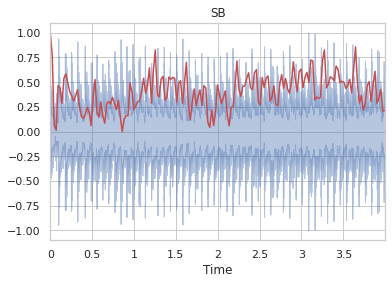

In [ ]:
# Spectral Bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(normalized_y, sr=sr)[0]
spectral_bandwidth.shape

# Computing the time variable for visualization
frames = range(len(spectral_bandwidth))
t = librosa.frames_to_time(frames)

# Plotting the Spectral Bandwidth along the waveform
librosa.display.waveplot(normalized_y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth), color='r')
plt.title('SB')

### Tempogram

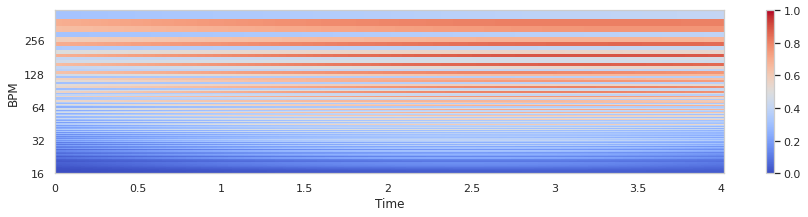

In [ ]:
hop_length = 512

# Compute local onset autocorrelation
oenv = librosa.onset.onset_strength(y=normalized_y, sr=sr, hop_length=hop_length)
times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                           hop_length=hop_length)[0]
# Plotting the tempogram
fig, ax = plt.subplots(figsize=(15, 3))
img = librosa.display.specshow(tempogram, x_axis='time', y_axis='tempo', hop_length=hop_length, cmap='coolwarm')
fig.colorbar(img, ax=ax)

## Audio Pre-Processing

In [ ]:
# Modify different encoders to read audio files with pydub

folds = 'fold1 fold10 fold2 fold3 fold4 fold5 fold6 fold7 fold8 fold9'.split()
for f in folds:
     pathlib.Path(f'{us8k_path}/new_audio/{f}').mkdir(parents=True, exist_ok=True)
     for filename in os.listdir(audio_path + str('/') + str(f)):
        audioname = f'{audio_path}/{f}/{filename}'
        if filename == '.DS_Store':
          continue
        k = sf.SoundFile(audioname)
        if k.subtype != "PCM_32":
          file, samplerate = sf.read(audioname)
          sf.write(f'{us8k_path}/new_audio/{f}/{filename}', file, samplerate, 'PCM_32')
        else:
          audioname.export(f'{us8k_path}/new_audio/{f}/{filename}', format='wav')

In [ ]:
# Define new audio path
new_audio_path = os.path.join(us8k_path, '/content/UrbanSound8K/new_audio')

### Converting To Two Channels

In [ ]:
# Coverting audio channels from mono to stereo

folds = 'fold1 fold10 fold2 fold3 fold4 fold5 fold6 fold7 fold8 fold9'.split()
for f in folds:
     pathlib.Path(f'{us8k_path}/stereo_audio/{f}').mkdir(parents=True, exist_ok=True)
     for filename in os.listdir(new_audio_path + str('/') + str(f)):
        audioname = f'{new_audio_path}/{f}/{filename}'
        if filename == '.DS_Store':
          continue
        else:
          audio = AudioSegment.from_wav(audioname)
          audio = audio.set_channels(2)
          audio.export(f'{us8k_path}/stereo_audio/{f}/{filename}', format='wav')

In [ ]:
# Define new audio path
stereo_audio_path = os.path.join(us8k_path, '/content/UrbanSound8K/stereo_audio')

### Resize Length

In [ ]:
# Run to remove folder
# Used in debugging
import shutil

shutil.rmtree('/content/UrbanSound8K/padded_audio')

In [ ]:
# Padding audio files to the same length
# Define fixed length (in milliseconds)
pad_ms = 4037 

folds = 'fold1 fold10 fold2 fold3 fold4 fold5 fold6 fold7 fold8 fold9'.split()
for f in folds:
     pathlib.Path(f'{us8k_path}/padded_audio/{f}').mkdir(parents=True, exist_ok=True)
     for filename in os.listdir(stereo_audio_path + str('/') + str(f)):
        audioname = f'{stereo_audio_path}/{f}/{filename}'
        audio = AudioSegment.from_wav(audioname)
        audio = AudioSegment.from_file(audioname, format="wav", duration=round(len(audio),3))
        if pad_ms == len(audio):
          audio.export(f'{us8k_path}/padded_audio/{f}/{filename}', format='wav')
          print("Original Audio: " + str(len(audio)))
        else:
          silence = AudioSegment.silent(duration=pad_ms-len(audio))
          padded = audio + silence  # Adding silence after the audio
          padded.export(f'{us8k_path}/padded_audio/{f}/{filename}', format='wav') # Exporting to folder
          print("Original Audio: " + str(len(audio)) + "  " + "Padded Audio: " + str(len(padded)))

In [ ]:
# Define new audio path
padded_audio_path = os.path.join(us8k_path, '/content/UrbanSound8K/padded_audio')

In [ ]:
# Store new information into dataframe
paddedaudio = []
folds = 'fold1 fold10 fold2 fold3 fold4 fold5 fold6 fold7 fold8 fold9'.split()
for f in folds:
     for filename in os.listdir(padded_audio_path + str('/') + str(f)):
        audioname = f'{padded_audio_path}/{f}/{filename}'
        audio = AudioSegment.from_wav(audioname)
        duration = len(audio)
        paddedaudio.append((filename, duration))


paddedaudiodf = pd.DataFrame(paddedaudio, columns=['filename', 'duration'])

In [ ]:
# Check audio have same length
paddedaudiodf.describe()

In [ ]:
# Save zipped padded audio in Drive
!zip -r '/content/drive/MyDrive/dataset/padded_audio.zip' '/content/UrbanSound8K/padded_audio'


## Extraction

### Entire Feature Set

In [ ]:
# Run to remove folder
# Used in debugging
import shutil

shutil.rmtree('/content/UrbanSound8K/padded_audio')

In [ ]:
# Convert the audio data files into PNG format images
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
folds = 'fold1 fold10 fold2 fold3 fold4 fold5 fold6 fold7 fold8 fold9'.split()
for f in folds:
    pathlib.Path(f'{us8k_path}/png/{f}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(padded_audio_path + str('/') + str(f)):
        audioname = f'{padded_audio_path}/{f}/{filename}'
        y, sr = librosa.load(audioname)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'{us8k_path}/png/{f}/{filename[:-4]}.png', format = 'png')
        plt.clf()
        

In [ ]:
# Check file number to match original
folds = 'fold1 fold10 fold2 fold3 fold4 fold5 fold6 fold7 fold8 fold9'.split()
for f in folds:
  png_count = len(os.listdir("/content/UrbanSound8K/png" + str('/') + str(f)))
  print(str(f) + ": " + str(png_count))

In [ ]:
# Save zipped png folder to drive
!zip -r '/content/drive/MyDrive/dataset/png.zip' '/content/UrbanSound8K/png'

In [ ]:
# Restore zipped padded audio folder to drive
!unzip '/content/drive/MyDrive/dataset/padded_audio.zip' -d '/'

In [ ]:
# Define new audio path
padded_audio_path = os.path.join(us8k_path, '/content/UrbanSound8K/padded_audio')

In [ ]:
# Create a header for our CSV file
header = 'filename rmse_avg rmse_std spectral_centroid_avg spectral_centroid_std spectral_bandwidth_avg spectral_bandwidth_std rolloff_avg rolloff_std zero_crossing_rate_avg zero_crossing_rate_std'
for i in range(1, 13):
    header += f' chroma_stft_avg{i} chroma_stft_std{i}'
for i in range(1, 41):
    header += f' mfcc_avg{i} mfcc_std{i}'
header += ' label'
header = header.split()

In [ ]:
# Extract the spectrogram for every audio
file = open('/content/UrbanSound8K/features.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
folds = 'fold1 fold10 fold2 fold3 fold4 fold5 fold6 fold7 fold8 fold9'.split()
for f in folds:
    for filename in os.listdir(padded_audio_path + str('/') + str(f)):
        audioname = f'{padded_audio_path}/{f}/{filename}'
        y, sr = librosa.load(audioname)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        to_append = f'{filename} {np.mean(rms)} {np.std(rms)} {np.mean(spec_cent)} {np.std(spec_cent)} {np.mean(spec_bw)} {np.std(spec_bw)} {np.mean(rolloff)} {np.std(rolloff)} {np.mean(zcr)} {np.std(zcr)}'
        for e in chroma_stft:
            to_append += f' {np.mean(e)} {np.std(e)}'  
        for e in mfcc:
            to_append += f' {np.mean(e)} {np.std(e)}'
        to_append += f' {f}'
        file = open('/content/UrbanSound8K/features.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [ ]:
#Export csv to Drive
!cp /content/UrbanSound8K/features.csv '/content/drive/MyDrive/dataset'

# Data Pre-Processing

## Loading, Dataframe and Summary Stat

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Read the data from Drive
data = pd.read_csv('/content/drive/MyDrive/dataset/features.csv')
data.head()

filename  rmse_avg  rmse_std  spectral_centroid_avg  \
0     78360-4-0-4.wav  0.117790  0.016102            3747.213703   
1     50901-0-1-0.wav  0.071896  0.027564            2009.859154   
2    46669-4-0-37.wav  0.046979  0.022767            5051.052834   
3    146186-5-0-3.wav  0.113351  0.010426            1887.848405   
4  177621-0-0-104.wav  0.028511  0.002981            2534.486709   

   spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
0             144.831977             2595.283625               75.161053   
1             345.452752             2283.962681              171.010899   
2              81.145085             2544.500488              176.789303   
3             126.650532             2820.462665               95.191460   
4             397.618152             3257.879196              331.934956   

   rolloff_avg  rolloff_std  zero_crossing_rate_avg  zero_crossing_rate_std  \
0  7124.210752   381.980159                0.252615                0.025206   
1  4212.958816   795.152630                0.089720                0.012818   
2  7448.631971   560.947951                0.541423                0.042910   
3  5602.840450   337.756225                0.029283                0.006813   
4  7047.730755  1704.629589                0.123746                0.039606   

   chroma_stft_avg1  chroma_stft_std1  chroma_stft_avg2  chroma_stft_std2  \
0          0.489600          0.246902          0.359423          0.214481   
1          0.559854          0.187557          0.522343          0.182228   
2          0.027759          0.030429          0.026674          0.028404   
3          0.236754          0.126381          0.187021          0.084260   
4          0.539056          0.244706          0.473949          0.225324   

   chroma_stft_avg3  chroma_stft_std3  chroma_stft_avg4  chroma_stft_std4  \
0          0.305496          0.171002          0.325638          0.191292   
1          0.573311          0.225545          0.602921          0.242376   
2          0.038166          0.038798          0.048888          0.049501   
3          0.176580          0.076438          0.241295          0.106650   
4          0.475278          0.206467          0.570688          0.207923   

   chroma_stft_avg5  chroma_stft_std5  chroma_stft_avg6  chroma_stft_std6  \
0          0.266143          0.129679          0.387222          0.243912   
1          0.577440          0.203332          0.618240          0.199067   
2          0.046655          0.040685          0.167116          0.247234   
3          0.379698          0.192262          0.545651          0.177805   
4          0.716701          0.212752          0.749506          0.221213   

   chroma_stft_avg7  chroma_stft_std7  chroma_stft_avg8  chroma_stft_std8  \
0          0.656395          0.254796          0.710503          0.264560   
1          0.631070          0.197403          0.720723          0.210919   
2          0.489219          0.389760          0.704941          0.397193   
3          0.903280          0.155007          0.910934          0.091198   
4          0.645191          0.211842          0.577642          0.200939   

   chroma_stft_avg9  chroma_stft_std9  chroma_stft_avg10  chroma_stft_std10  \
0          0.405564          0.211003           0.402374           0.228463   
1          0.671183          0.195713           0.728963           0.210980   
2          0.352943          0.419069           0.029199           0.031117   
3          0.711665          0.227804           0.476088           0.204346   
4          0.551342          0.197148           0.640534           0.251605   

   chroma_stft_avg11  chroma_stft_std11  chroma_stft_avg12  chroma_stft_std12  \
0           0.417561           0.177547           0.695642           0.290092   
1           0.646419           0.193658           0.591873           0.188675   
2           0.026728           0.028499           0.027400           0.029237   
3           0.340024 

In [ ]:
# Add columns from metadata file
features = pd.DataFrame(data)
features = pd.merge(left = audiodatadf, right = features, left_on = 'filename', right_on = 'filename')
features

id            filename   fold             class  duration  channels  \
0        0    100032-3-0-0.wav  fold5          dog_bark  0.317551         2   
1        1  100263-2-0-117.wav  fold5  children_playing  4.000000         2   
2        2  100263-2-0-121.wav  fold5  children_playing  4.000000         2   
3        3  100263-2-0-126.wav  fold5  children_playing  4.000000         2   
4        4  100263-2-0-137.wav  fold5  children_playing  4.000000         2   
...    ...                 ...    ...               ...       ...       ...   
8727  8727     99812-1-2-0.wav  fold7          car_horn  4.000000         2   
8728  8728     99812-1-3-0.wav  fold7          car_horn  2.142545         2   
8729  8729     99812-1-4-0.wav  fold7          car_horn  3.505983         2   
8730  8730     99812-1-5-0.wav  fold7          car_horn  2.532098         2   
8731  8731     99812-1-6-0.wav  fold7          car_horn  2.532099         2   

      sample_rate  bit_depth  rmse_avg  rmse_std  spectral_centroid_avg  \
0           44100         16  0.010457  0.045623             190.472709   
1           44100         16  0.003992  0.001053            2134.055230   
2           44100         16  0.003006  0.000566            1839.745882   
3           44100         16  0.004646  0.001773            2290.863784   
4           44100         16  0.003216  0.000495            1999.140966   
...           ...        ...       ...       ...                    ...   
8727        44100         16  0.004691  0.000947            1811.197069   
8728        44100         16  0.007871  0.010230            1509.029824   
8729        44100         16  0.011199  0.008151            1984.414856   
8730        44100         16  0.005476  0.004933            1365.619376   
8731        44100         16  0.006865  0.006041            1608.057136   

      spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
0                601.692547              157.295579              496.124194   
1                238.849398             1960.369674              156.902599   
2                171.965383             1937.088590               94.225556   
3                457.823336             2247.770039              321.413097   
4                152.981492             1940.533825               99.793609   
...                     ...                     ...                     ...   
8727             110.930132             1856.922142              113.686994   
8728            1461.567472             1001.041187              916.534656   
8729            1098.232129             1823.513645              704.521560   
8730            1201.735019             1215.432386              915.291857   
8731            1339.767442             1418.785966             1066.431252   

      rolloff_avg  rolloff_std  zero_crossing_rate_avg  \
0      262.234813   827.302771                0.011031   
1     3989.273387   200.269381                0.138663   
2     3687.994174   271.865687                0.102051   
3     4499.078159  1040.168932                0.130683   
4     3922.136820   184.975824                0.118049   
...           ...          ...                     ...   
8727  3283.689723   265.506731                0.115493   
8728  2157.651704  1977.558550                0.128592   
8729  3614.979290  1721.307937                0.110736   
8730  2387.029819  1864.895477                0.096842   
8731  2814.105014  2158.897293                0.106973   

      zero_crossing_rate_std  chroma_stft_avg1  chroma_stft_std1  \
0                   0.036138          0.038929          0.140807   
1                   0.038683          0.477889          0.265291   
2                   0.026050          0.600192          0.253211   
3                   0.047365          0.527352          0.293474   
4                   0.028874          0.721940          0.231809   
...                      ...               ...               ...   
8727                0.018768        

In [ ]:
# Drop unnecessary columns
features = features.drop(features.columns[[0,1, 4, 5, 6, 7, 122]], axis = 1)
features


fold             class  rmse_avg  rmse_std  spectral_centroid_avg  \
0     fold5          dog_bark  0.010457  0.045623             190.472709   
1     fold5  children_playing  0.003992  0.001053            2134.055230   
2     fold5  children_playing  0.003006  0.000566            1839.745882   
3     fold5  children_playing  0.004646  0.001773            2290.863784   
4     fold5  children_playing  0.003216  0.000495            1999.140966   
...     ...               ...       ...       ...                    ...   
8727  fold7          car_horn  0.004691  0.000947            1811.197069   
8728  fold7          car_horn  0.007871  0.010230            1509.029824   
8729  fold7          car_horn  0.011199  0.008151            1984.414856   
8730  fold7          car_horn  0.005476  0.004933            1365.619376   
8731  fold7          car_horn  0.006865  0.006041            1608.057136   

      spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
0                601.692547              157.295579              496.124194   
1                238.849398             1960.369674              156.902599   
2                171.965383             1937.088590               94.225556   
3                457.823336             2247.770039              321.413097   
4                152.981492             1940.533825               99.793609   
...                     ...                     ...                     ...   
8727             110.930132             1856.922142              113.686994   
8728            1461.567472             1001.041187              916.534656   
8729            1098.232129             1823.513645              704.521560   
8730            1201.735019             1215.432386              915.291857   
8731            1339.767442             1418.785966             1066.431252   

      rolloff_avg  rolloff_std  zero_crossing_rate_avg  \
0      262.234813   827.302771                0.011031   
1     3989.273387   200.269381                0.138663   
2     3687.994174   271.865687                0.102051   
3     4499.078159  1040.168932                0.130683   
4     3922.136820   184.975824                0.118049   
...           ...          ...                     ...   
8727  3283.689723   265.506731                0.115493   
8728  2157.651704  1977.558550                0.128592   
8729  3614.979290  1721.307937                0.110736   
8730  2387.029819  1864.895477                0.096842   
8731  2814.105014  2158.897293                0.106973   

      zero_crossing_rate_std  chroma_stft_avg1  chroma_stft_std1  \
0                   0.036138          0.038929          0.140807   
1                   0.038683          0.477889          0.265291   
2                   0.026050          0.600192          0.253211   
3                   0.047365          0.527352          0.293474   
4                   0.028874          0.721940          0.231809   
...                      ...               ...               ...   
8727                0.018768          0.576888          0.289237   
8728                0.136145          0.170631          0.244661   
8729                0.058742          0.225182          0.164581   
8730                0.083780          0.211606          0.257773   
8731                0.083818          0.128100          0.169257   

      chroma_stft_avg2  chroma_stft_std2  chroma_stft_avg3  chroma_stft_std3  \
0             0.050008          0.184667          0.034510          0.127062   
1             0.481114          0.280313          0.539950          0.298418   
2             0.605179          0.250865          0.515606          0.243863   
3             0.568251          0.290394          0.498773          0.297059   
4             0.703830          0.253557          0.543426          0.237066   
...                ...               ...               ...               ...   
8727          0.274989          0.217189          0.287522          0.1

In [ ]:
features.describe()

rmse_avg     rmse_std  spectral_centroid_avg  spectral_centroid_std  \
count  8732.000000  8732.000000            8732.000000            8732.000000   
mean      0.061293     0.023087            1897.882654             385.811471   
std       0.061114     0.028700            1059.069188             401.152809   
min       0.000176     0.000036              45.018738              21.651126   
25%       0.019100     0.005553            1196.365406             132.572881   
50%       0.044754     0.012724            1741.916295             240.589026   
75%       0.081874     0.028513            2369.035867             461.080760   
max       0.578373     0.311375            6727.865411            2887.027396   

       spectral_bandwidth_avg  spectral_bandwidth_std  rolloff_avg  \
count             8732.000000             8732.000000  8732.000000   
mean              1872.413675              299.189282  3664.320297   
std                719.480391              322.470211  2054.368795   
min                 47.319133               24.088724    73.571777   
25%               1457.278795               95.371693  2137.077595   
50%               1908.108835              172.657940  3346.278329   
75%               2384.531831              335.298565  4936.254778   
max               4300.403298             1961.753431  9956.383856   

       rolloff_std  zero_crossing_rate_avg  zero_crossing_rate_std  \
count  8732.000000             8732.000000             8732.000000   
mean    799.181640                0.108839                0.031099   
std     767.463784                0.091591                0.029942   
min      17.817681                0.000895                0.003015   
25%     277.967062                0.048760                0.012981   
50%     527.868073                0.086416                0.022295   
75%    1041.961205                0.128769                0.037169   
max    4730.310326                0.752559                0.282989   

       chroma_stft_avg1  chroma_stft_std1  chroma_stft_avg2  chroma_stft_std2  \
count       8732.000000       8732.000000       8732.000000       8732.000000   
mean           0.432628          0.226237          0.427531          0.219891   
std            0.211871          0.079841          0.212728          0.080653   
min            0.001295          0.000741          0.001262          0.000000   
25%            0.274003          0.172049          0.271318          0.168182   
50%            0.433712          0.226750          0.428421          0.218258   
75%            0.584994          0.282840          0.582185          0.276403   
max            0.999598          0.497882          1.000000          0.482517   

       chroma_stft_avg3  chroma_stft_std3  chroma_stft_avg4  chroma_stft_std4  \
count       8732.000000       8732.000000       8732.000000       8732.000000   
mean           0.438031          0.225971          0.426177          0.223364   
std            0.214267          0.081627          0.201150          0.080091   
min            0.001659          0.000000          0.002152          0.002224   
25%            0.279721          0.172096          0.280319          0.167522   
50%            0.441919          0.226088          0.432367          0.221597   
75%            0.593058          0.283754          0.570131          0.279991   
max            1.000000          0.485319          0.999758          0.485459   

       chroma_stft_avg5  chroma_stft_std5  chroma_stft_avg6  chroma_stft_std6  \
count       8732.000000       8732.000000       8732.000000       8732.000000   
mean           0.420966          0.222884          0.421362          0.223305   
std            0.204918          0.079712          0.210644          0.078900   
min            0.002230          0.003323          0.001369          0.002487   
25%            0.272973          0.170813          0.264201          0.172604   
50%            0.427181          0.220643          0.420721          0.2

## Training and Test Split

In [ ]:
# Create training dataset
s = ['fold1','fold2','fold3','fold4','fold6']

features_training = features.loc[features['fold'].isin(s)]
features_training = features_training.drop(features_training.columns[0], axis = 1)
features_training

class  rmse_avg  rmse_std  spectral_centroid_avg  \
14        dog_bark  0.050409  0.066167            2131.431924   
15        dog_bark  0.051254  0.069993            2090.729315   
16        dog_bark  0.045810  0.064183            2083.353612   
17        dog_bark  0.057249  0.075875            2010.420291   
53        dog_bark  0.036516  0.029193            3559.264811   
...            ...       ...       ...                    ...   
8718  street_music  0.264389  0.094243            1505.867278   
8719  street_music  0.163014  0.074126            1455.582985   
8720  street_music  0.160581  0.090907            1556.737590   
8721  street_music  0.176779  0.103457            1569.423095   
8722  street_music  0.185240  0.077754            1676.664886   

      spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
14               356.419325             1702.794404              501.063643   
15               315.134423             1577.337300              456.039860   
16               338.788751             1591.869485              470.139660   
17               300.504965             1490.229130              444.606273   
53               639.010946             2558.143075              209.275850   
...                     ...                     ...                     ...   
8718             212.080632             1634.301060              206.372950   
8719             284.319409             1648.821133              201.454798   
8720             169.828824             1694.410240              153.989658   
8721             194.352577             1764.940141              193.948995   
8722             240.054349             1742.089915              195.643639   

      rolloff_avg  rolloff_std  zero_crossing_rate_avg  \
14    3422.913019   930.291607                0.148954   
15    3175.281183   672.513186                0.153828   
16    3224.225906   791.486548                0.153595   
17    3055.301640   706.759406                0.148654   
53    6611.002744  1085.777145                0.255607   
...           ...          ...                     ...   
8718  2846.652327   396.484815                0.054154   
8719  2720.051943   464.621642                0.060193   
8720  2909.643134   283.909174                0.078431   
8721  2923.441709   333.016652                0.073262   
8722  3077.639244   346.051728                0.091572   

      zero_crossing_rate_std  chroma_stft_avg1  chroma_stft_std1  \
14                  0.026681          0.396629          0.255833   
15                  0.022355          0.415257          0.257717   
16                  0.020301          0.360261          0.243872   
17                  0.017650          0.314699          0.236815   
53                  0.074516          0.682120          0.212944   
...                      ...               ...               ...   
8718                0.017498          0.051268          0.113648   
8719                0.023202          0.111361          0.226914   
8720                0.020040          0.343346          0.336340   
8721                0.017266          0.350468          0.333641   
8722                0.032339          0.270026          0.259976   

      chroma_stft_avg2  chroma_stft_std2  chroma_stft_avg3  chroma_stft_std3  \
14            0.428198          0.261683          0.364896          0.233608   
15            0.427144          0.270619          0.352065          0.256803   
16            0.426737          0.299420          0.409478          0.277331   
17            0.378308          0.281410          0.396482          0.303510   
53            0.686688          0.225174          0.588566          0.225926   
...                ...               ...               ...               ...   
8718          0.049009          0.141753          0.078610          0.201889   
8719          0.121984          0.246621          0.112989          0.231221   
8720          0.242400          0.206823         

In [ ]:
# Create test dataset Fold 5
features_test_5 = features.loc[features['fold'] =='fold5']
features_test_5 = features_test_5.drop(features_test_5.columns[0], axis = 1)
features_test_5

class  rmse_avg  rmse_std  spectral_centroid_avg  \
0             dog_bark  0.010457  0.045623             190.472709   
1     children_playing  0.003992  0.001053            2134.055230   
2     children_playing  0.003006  0.000566            1839.745882   
3     children_playing  0.004646  0.001773            2290.863784   
4     children_playing  0.003216  0.000495            1999.140966   
...                ...       ...       ...                    ...   
8419     engine_idling  0.102907  0.005169             422.563317   
8420     engine_idling  0.106588  0.005743             407.141208   
8421     engine_idling  0.107574  0.006496             416.837735   
8435          gun_shot  0.010171  0.023322             446.337944   
8681          dog_bark  0.017317  0.046060             252.033188   

      spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
0                601.692547              157.295579              496.124194   
1                238.849398             1960.369674              156.902599   
2                171.965383             1937.088590               94.225556   
3                457.823336             2247.770039              321.413097   
4                152.981492             1940.533825               99.793609   
...                     ...                     ...                     ...   
8419             102.341362              796.944563              210.988136   
8420              64.498924              779.629958              161.117004   
8421              98.368133              817.331822              188.826272   
8435             617.406616              368.488395              547.073837   
8681             578.014783              246.410866              561.920604   

      rolloff_avg  rolloff_std  zero_crossing_rate_avg  \
0      262.234813   827.302771                0.011031   
1     3989.273387   200.269381                0.138663   
2     3687.994174   271.865687                0.102051   
3     4499.078159  1040.168932                0.130683   
4     3922.136820   184.975824                0.118049   
...           ...          ...                     ...   
8419   864.793238   208.551814                0.008537   
8420   832.555310    54.816091                0.008239   
8421   840.351815   219.275442                0.008405   
8435   749.268841  1046.728777                0.035117   
8681   390.443999   950.523765                0.013417   

      zero_crossing_rate_std  chroma_stft_avg1  chroma_stft_std1  \
0                   0.036138          0.038929          0.140807   
1                   0.038683          0.477889          0.265291   
2                   0.026050          0.600192          0.253211   
3                   0.047365          0.527352          0.293474   
4                   0.028874          0.721940          0.231809   
...                      ...               ...               ...   
8419                0.003678          0.348774          0.066404   
8420                0.003572          0.339940          0.041213   
8421                0.003658          0.337543          0.034569   
8435                0.050490          0.226738          0.319060   
8681                0.030922          0.026133          0.103829   

      chroma_stft_avg2  chroma_stft_std2  chroma_stft_avg3  chroma_stft_std3  \
0             0.050008          0.184667          0.034510          0.127062   
1             0.481114          0.280313          0.539950          0.298418   
2             0.605179          0.250865          0.515606          0.243863   
3             0.568251          0.290394          0.498773          0.297059   
4             0.703830          0.253557          0.543426          0.237066   
...                ...               ...               ...               ...   
8419          0.620750          0.040770          0.996128          0.006685   
8420          0.615551          0.022274          0.995930          0.009973   
8421 

In [ ]:
# Create test dataset Fold 7
features_test_7 = features.loc[features['fold'] =='fold7']
features_test_7 = features_test_7.drop(features_test_7.columns[0], axis = 1)
##
# Create test dataset Fold 8
features_test_8 = features.loc[features['fold'] =='fold8']
features_test_8 = features_test_8.drop(features_test_8.columns[0], axis = 1)

##
# Create test dataset Fold 9
features_test_9 = features.loc[features['fold'] =='fold9']
features_test_9 = features_test_9.drop(features_test_9.columns[0], axis = 1)

##
# Create test dataset Fold 10
features_test_10 = features.loc[features['fold'] =='fold10']
features_test_10 = features_test_10.drop(features_test_10.columns[0], axis = 1)



## Scaling

In [ ]:
# Scale the Training data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_training.iloc[:, 1:] = scaler.fit_transform(features_training.iloc[:, 1:])
features_training

class  rmse_avg  rmse_std  spectral_centroid_avg  \
14        dog_bark -0.158458  1.532827               0.288913   
15        dog_bark -0.143241  1.667391               0.249032   
16        dog_bark -0.241247  1.463061               0.241805   
17        dog_bark -0.035329  1.874275               0.170344   
53        dog_bark -0.408560  0.232382               1.687928   
...            ...       ...       ...                    ...   
8718  street_music  3.693597  2.520314              -0.324026   
8719  street_music  1.868649  1.812767              -0.373296   
8720  street_music  1.824849  2.402993              -0.274183   
8721  street_music  2.116438  2.844403              -0.261753   
8722  street_music  2.268757  1.940369              -0.156676   

      spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
14                -0.038794               -0.198949                0.667381   
15                -0.147324               -0.369307                0.522477   
16                -0.085141               -0.349574                0.567856   
17                -0.185781               -0.487590                0.485679   
53                 0.704081                0.962524               -0.271706   
...                     ...                     ...                     ...   
8718              -0.418231               -0.291956               -0.281049   
8719              -0.228330               -0.272239               -0.296877   
8720              -0.529302               -0.210334               -0.449639   
8721              -0.464834               -0.114562               -0.321034   
8722              -0.344694               -0.145590               -0.315580   

      rolloff_avg  rolloff_std  zero_crossing_rate_avg  \
14      -0.073487     0.196149                0.528894   
15      -0.195057    -0.155813                0.585635   
16      -0.171029     0.006629                0.582923   
17      -0.253959    -0.109055                0.525399   
53       1.491651     0.408444                1.770390   
...           ...          ...                     ...   
8718    -0.356392    -0.532694               -0.574622   
8719    -0.418544    -0.439662               -0.504325   
8720    -0.325468    -0.686401               -0.292030   
8721    -0.318694    -0.619351               -0.352201   
8722    -0.242993    -0.601554               -0.139056   

      zero_crossing_rate_std  chroma_stft_avg1  chroma_stft_std1  \
14                 -0.095521         -0.156029          0.370622   
15                 -0.250434         -0.068537          0.394413   
16                 -0.323979         -0.326844          0.219643   
17                 -0.418895         -0.540845          0.130562   
53                  1.617357          1.184885         -0.170762   
...                      ...               ...               ...   
8718               -0.424362         -1.778147         -1.424182   
8719               -0.220089         -1.495896          0.005582   
8720               -0.333330         -0.406294          1.386879   
8721               -0.432672         -0.372841          1.352811   
8722                0.107070         -0.750670          0.422925   

      chroma_stft_avg2  chroma_stft_std2  chroma_stft_avg3  chroma_stft_std3  \
14            0.023243          0.539376         -0.331290          0.084693   
15            0.018321          0.650873         -0.390977          0.371851   
16            0.016422          1.010249         -0.123898          0.625986   
17           -0.209741          0.785524         -0.184354          0.950093   
53            1.230395          0.083824          0.709205         -0.010422   
...                ...               ...               ...               ...   
8718         -1.747575         -0.957091         -1.663063         -0.308008   
8719         -1.406778          0.351426         -1.503138          0.055136   
8720         -0.844437         -0.145162         

In [ ]:
features_training.describe()

rmse_avg      rmse_std  spectral_centroid_avg  \
count  4.499000e+03  4.499000e+03           4.499000e+03   
mean   3.286991e-17  2.645386e-17           3.770662e-17   
std    1.000111e+00  1.000111e+00           1.000111e+00   
min   -1.062102e+00 -7.931225e-01          -1.755391e+00   
25%   -7.060655e-01 -6.080590e-01          -6.283787e-01   
50%   -2.828953e-01 -3.563186e-01          -1.302164e-01   
75%    3.985954e-01  1.895793e-01           4.164033e-01   
max    9.345893e+00  1.015727e+01           4.792578e+00   

       spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
count           4.499000e+03            4.499000e+03            4.499000e+03   
mean            1.064941e-16            4.738436e-16           -4.129714e-17   
std             1.000111e+00            1.000111e+00            1.000111e+00   
min            -9.174585e-01           -2.446911e+00           -8.485956e-01   
25%            -6.305374e-01           -6.023997e-01           -6.287579e-01   
50%            -3.576909e-01            6.004646e-02           -3.859341e-01   
75%             1.792153e-01            7.322147e-01            1.123685e-01   
max             6.376891e+00            2.618456e+00            4.309396e+00   

        rolloff_avg   rolloff_std  zero_crossing_rate_avg  \
count  4.499000e+03  4.499000e+03            4.499000e+03   
mean  -6.230352e-17 -9.039224e-17            2.099775e-16   
std    1.000111e+00  1.000111e+00            1.000111e+00   
min   -1.717789e+00 -1.049714e+00           -1.188804e+00   
25%   -7.356396e-01 -6.907400e-01           -6.308398e-01   
50%   -1.607612e-01 -3.460522e-01           -2.111170e-01   
75%    5.853397e-01  3.185506e-01            2.325009e-01   
max    2.997037e+00  4.803790e+00            7.555177e+00   

       zero_crossing_rate_std  chroma_stft_avg1  chroma_stft_std1  \
count            4.499000e+03      4.499000e+03      4.499000e+03   
mean             8.170898e-17     -1.746399e-16     -2.407622e-16   
std              1.000111e+00      1.000111e+00      1.000111e+00   
min             -9.429635e-01     -2.012865e+00     -2.849421e+00   
25%             -6.036327e-01     -7.406006e-01     -6.732818e-01   
50%             -2.861453e-01      1.554466e-02     -1.282149e-03   
75%              2.078243e-01      7.350544e-01      6.896366e-01   
max              9.082464e+00      2.676038e+00      3.236790e+00   

       chroma_stft_avg2  chroma_stft_std2  chroma_stft_avg3  chroma_stft_std3  \
count      4.499000e+03      4.499000e+03      4.499000e+03      4.499000e+03   
mean      -2.497817e-16     -3.665044e-16      5.979263e-17     -2.705104e-16   
std        1.000111e+00      1.000111e+00      1.000111e+00      1.000111e+00   
min       -1.970553e+00     -2.725856e+00     -2.021032e+00     -2.807451e+00   
25%       -7.186478e-01     -6.615069e-01     -7.200806e-01     -6.440455e-01   
50%        1.067958e-02     -1.477252e-02      3.817424e-02      9.549204e-04   
75%        7.169003e-01      7.018952e-01      7.220951e-01      6.987927e-01   
max        2.693565e+00      3.152356e+00      2.623155e+00      3.200943e+00   

       chroma_stft_avg4  chroma_stft_std4  chroma_stft_avg5  chroma_stft_std5  \
count      4.499000e+03      4.499000e+03      4.499000e+03      4.499000e+03   
mean      -1.304185e-16     -2.300153e-16     -1.445338e-16     -4.762682e-16   
std        1.000111e+00      1.000111e+00      1.000111e+00      1.000111e+00   
min       -2.086490e+00     -2.856393e+00     -2.021146e+00     -2.804219e+00   
25%       -7.037252e-01     -6.769878e-01     -7.143602e-01     -6.505035e-01   
50%        2.635585e-02     -3.756041e-02      1.970567e-02     -5.245104e-02   
75%        7.297366e-01      6.994145e-01      7.078304e-01      7.046056e-01   
max        2.801563e+00      3.342490e+00      2.687806e+00      3.434484e+00   

       chroma_stft_avg6  chroma_stft_std6  chroma_stft_avg7  chroma_stft_std7  \
count      4.499000e+03      4.49900

In [ ]:

scaler = StandardScaler()

features_test_5.iloc[:, 1:] = scaler.fit_transform(features_test_5.iloc[:, 1:])
features_test_7.iloc[:, 1:] = scaler.fit_transform(features_test_7.iloc[:, 1:])
features_test_8.iloc[:, 1:] = scaler.fit_transform(features_test_8.iloc[:, 1:])
features_test_9.iloc[:, 1:] = scaler.fit_transform(features_test_9.iloc[:, 1:])
features_test_10.iloc[:, 1:] = scaler.fit_transform(features_test_10.iloc[:, 1:])

In [ ]:
features_test_5.describe()

rmse_avg      rmse_std  spectral_centroid_avg  \
count  9.360000e+02  9.360000e+02           9.360000e+02   
mean  -2.391250e-16  1.328472e-17          -8.635068e-17   
std    1.000535e+00  1.000535e+00           1.000535e+00   
min   -1.031253e+00 -7.172498e-01          -1.669096e+00   
25%   -6.921329e-01 -5.418277e-01          -7.607146e-01   
50%   -3.037181e-01 -3.184133e-01          -1.595225e-01   
75%    2.941642e-01  5.851179e-02           5.514112e-01   
max    6.263360e+00  7.571956e+00           2.939590e+00   

       spectral_centroid_std  spectral_bandwidth_avg  spectral_bandwidth_std  \
count           9.360000e+02            9.360000e+02            9.360000e+02   
mean            1.435224e-16            3.890525e-17            8.160614e-17   
std             1.000535e+00            1.000535e+00            1.000535e+00   
min            -8.159289e-01           -2.341819e+00           -7.414585e-01   
25%            -5.834183e-01           -5.982676e-01           -5.965278e-01   
50%            -3.747362e-01            5.550511e-03           -4.299592e-01   
75%             6.236363e-02            7.325311e-01            1.563601e-02   
max             4.574098e+00            2.002868e+00            4.078829e+00   

        rolloff_avg   rolloff_std  zero_crossing_rate_avg  \
count  9.360000e+02  9.360000e+02            9.360000e+02   
mean  -4.934325e-17 -1.029566e-16           -7.520100e-17   
std    1.000535e+00  1.000535e+00            1.000535e+00   
min   -1.663325e+00 -8.675784e-01           -1.236639e+00   
25%   -7.822409e-01 -6.288323e-01           -7.821015e-01   
50%   -1.481165e-01 -3.866029e-01           -1.987044e-01   
75%    6.413532e-01  1.185176e-01            4.578958e-01   
max    2.447614e+00  4.308632e+00            5.386137e+00   

       zero_crossing_rate_std  chroma_stft_avg1  chroma_stft_std1  \
count            9.360000e+02      9.360000e+02      9.360000e+02   
mean            -1.137467e-16     -1.966613e-16     -3.997277e-16   
std              1.000535e+00      1.000535e+00      1.000535e+00   
min             -9.156522e-01     -1.940925e+00     -2.471323e+00   
25%             -5.773456e-01     -8.852222e-01     -7.021727e-01   
50%             -2.891773e-01      1.611151e-02     -1.460783e-02   
75%              1.525278e-01      8.464096e-01      7.636721e-01   
max              5.575426e+00      2.573405e+00      3.181394e+00   

       chroma_stft_avg2  chroma_stft_std2  chroma_stft_avg3  chroma_stft_std3  \
count      9.360000e+02      9.360000e+02      9.360000e+02      9.360000e+02   
mean      -1.591794e-16     -3.843080e-16     -6.879587e-17     -3.439794e-16   
std        1.000535e+00      1.000535e+00      1.000535e+00      1.000535e+00   
min       -1.787302e+00     -2.515556e+00     -1.834384e+00     -2.582181e+00   
25%       -8.659666e-01     -5.430448e-01     -8.755027e-01     -6.349042e-01   
50%        5.021889e-02     -4.286984e-02      4.367342e-02     -2.808101e-02   
75%        7.874905e-01      6.611052e-01      7.715776e-01      7.476551e-01   
max        2.454223e+00      3.009258e+00      2.490706e+00      2.662058e+00   

       chroma_stft_avg4  chroma_stft_std4  chroma_stft_avg5  chroma_stft_std5  \
count      9.360000e+02      9.360000e+02      9.360000e+02      9.360000e+02   
mean      -2.002197e-16     -4.047095e-16     -2.225191e-16     -2.456487e-16   
std        1.000535e+00      1.000535e+00      1.000535e+00      1.000535e+00   
min       -1.835803e+00     -2.374349e+00     -1.978584e+00     -2.182038e+00   
25%       -8.171309e-01     -6.888959e-01     -7.981092e-01     -7.265117e-01   
50%        1.878043e-02     -1.315124e-02      4.832551e-02     -1.867226e-02   
75%        7.600401e-01      7.175986e-01      8.782518e-01      7.420925e-01   
max        2.665526e+00      2.741469e+00      2.540575e+00      2.828146e+00   

       chroma_stft_avg6  chroma_stft_std6  chroma_stft_avg7  chroma_stft_std7  \
count      9.360000e+02      9.36000

## Class Encoding

In [ ]:
# Encoding training dataset labels
from sklearn.preprocessing import LabelEncoder

# Create an object of the label encoder classerd
labelencoder = LabelEncoder()

features_training['class'] = labelencoder.fit_transform(features_training['class'])
features_training

class  rmse_avg  rmse_std  spectral_centroid_avg  spectral_centroid_std  \
14        3 -0.158458  1.532827               0.288913              -0.038794   
15        3 -0.143241  1.667391               0.249032              -0.147324   
16        3 -0.241247  1.463061               0.241805              -0.085141   
17        3 -0.035329  1.874275               0.170344              -0.185781   
53        3 -0.408560  0.232382               1.687928               0.704081   
...     ...       ...       ...                    ...                    ...   
8718      9  3.693597  2.520314              -0.324026              -0.418231   
8719      9  1.868649  1.812767              -0.373296              -0.228330   
8720      9  1.824849  2.402993              -0.274183              -0.529302   
8721      9  2.116438  2.844403              -0.261753              -0.464834   
8722      9  2.268757  1.940369              -0.156676              -0.344694   

      spectral_bandwidth_avg  spectral_bandwidth_std  rolloff_avg  \
14                 -0.198949                0.667381    -0.073487   
15                 -0.369307                0.522477    -0.195057   
16                 -0.349574                0.567856    -0.171029   
17                 -0.487590                0.485679    -0.253959   
53                  0.962524               -0.271706     1.491651   
...                      ...                     ...          ...   
8718               -0.291956               -0.281049    -0.356392   
8719               -0.272239               -0.296877    -0.418544   
8720               -0.210334               -0.449639    -0.325468   
8721               -0.114562               -0.321034    -0.318694   
8722               -0.145590               -0.315580    -0.242993   

      rolloff_std  zero_crossing_rate_avg  zero_crossing_rate_std  \
14       0.196149                0.528894               -0.095521   
15      -0.155813                0.585635               -0.250434   
16       0.006629                0.582923               -0.323979   
17      -0.109055                0.525399               -0.418895   
53       0.408444                1.770390                1.617357   
...           ...                     ...                     ...   
8718    -0.532694               -0.574622               -0.424362   
8719    -0.439662               -0.504325               -0.220089   
8720    -0.686401               -0.292030               -0.333330   
8721    -0.619351               -0.352201               -0.432672   
8722    -0.601554               -0.139056                0.107070   

      chroma_stft_avg1  chroma_stft_std1  chroma_stft_avg2  chroma_stft_std2  \
14           -0.156029          0.370622          0.023243          0.539376   
15           -0.068537          0.394413          0.018321          0.650873   
16           -0.326844          0.219643          0.016422          1.010249   
17           -0.540845          0.130562         -0.209741          0.785524   
53            1.184885         -0.170762          1.230395          0.083824   
...                ...               ...               ...               ...   
8718         -1.778147         -1.424182         -1.747575         -0.957091   
8719         -1.495896          0.005582         -1.406778          0.351426   
8720         -0.406294          1.386879         -0.844437         -0.145162   
8721         -0.372841          1.352811         -0.983012         -0.286496   
8722         -0.750670          0.422925         -0.759426          0.924344   

      chroma_stft_avg3  chroma_stft_std3  chroma_stft_avg4  chroma_stft_std4  \
14           -0.331290          0.084693         -0.338723          0.274057   
15           -0.390977          0.371851         -0.514590         -0.133658   
16           -0.123898          0.625986         -0.392907          0.019495   
17           -0.184354          0.950093         -0.494460          0.285790   
53            

In [ ]:
##Encoding Test Dataset Labels
features_test_5['class'] = labelencoder.fit_transform(features_test_5['class'])
features_test_7['class'] = labelencoder.fit_transform(features_test_7['class'])
features_test_8['class'] = labelencoder.fit_transform(features_test_8['class'])
features_test_9['class'] = labelencoder.fit_transform(features_test_9['class'])
features_test_10['class'] = labelencoder.fit_transform(features_test_10['class'])

In [ ]:
features_test_5

class  rmse_avg  rmse_std  spectral_centroid_avg  spectral_centroid_std  \
0         3 -0.871579  0.678088              -1.602801               0.479063   
1         2 -0.976938 -0.694141               0.161705              -0.331015   
2         2 -0.993002 -0.709137              -0.105488              -0.480339   
3         2 -0.966286 -0.672001               0.304065               0.157863   
4         2 -0.989578 -0.711342               0.039221              -0.522723   
...     ...       ...       ...                    ...                    ...   
8419      5  0.635013 -0.567429              -1.392095              -0.635781   
8420      5  0.695007 -0.549753              -1.406096              -0.720268   
8421      5  0.711067 -0.526579              -1.397293              -0.644652   
8435      6 -0.876237 -0.008518              -1.370511               0.514146   
8681      3 -0.759787  0.691538              -1.546913               0.426201   

      spectral_bandwidth_avg  spectral_bandwidth_std  rolloff_avg  \
0                  -2.292118                0.533603    -1.633414   
1                   0.164664               -0.393344     0.143356   
2                   0.132942               -0.564613    -0.000271   
3                   0.556261                0.056193     0.386392   
4                   0.137636               -0.549398     0.111350   
...                      ...                     ...          ...   
8419               -1.420563               -0.245551    -1.346159   
8420               -1.444155               -0.381827    -1.361528   
8421               -1.392784               -0.306110    -1.357811   
8435               -2.004357                0.672826    -1.401233   
8681               -2.170694                0.713396    -1.572293   

      rolloff_std  zero_crossing_rate_avg  zero_crossing_rate_std  \
0        0.056648               -1.140577                0.142790   
1       -0.665155                0.262024                0.225111   
2       -0.582737               -0.140327               -0.183548   
3        0.301686                0.174319                0.505962   
4       -0.682760                0.035484               -0.092182   
...           ...                     ...                     ...   
8419    -0.655620               -1.167993               -0.907239   
8420    -0.832592               -1.171262               -0.910689   
8421    -0.643276               -1.169442               -0.907906   
8435     0.309237               -0.875889                0.607066   
8681     0.198492               -1.114364               -0.025950   

      chroma_stft_avg1  chroma_stft_std1  chroma_stft_avg2  chroma_stft_std2  \
0            -1.809681         -1.012827         -1.623899         -0.372053   
1             0.242772          0.509426          0.226751          0.738157   
2             0.814626          0.361710          0.759337          0.396341   
3             0.474047          0.854073          0.600810          0.855174   
4             1.383884          0.099998          1.182824          0.427592   
...                ...               ...               ...               ...   
8419         -0.360936         -1.922677          0.826180         -2.042323   
8420         -0.402238         -2.230720          0.803860         -2.257015   
8421         -0.413448         -2.311974          0.799790         -2.116094   
8435         -0.931536          1.166944         -0.934547          1.063084   
8681         -1.869510         -1.465019         -1.646919         -0.637591   

      chroma_stft_avg3  chroma_stft_std3  chroma_stft_avg4  chroma_stft_std4  \
0            -1.724874         -1.097279         -1.811578         -1.809500   
1             0.482006          0.905267          0.581090          0.360244   
2             0.375716          0.267713          0.189377          0.183995   
3             0.302217          0.889380          0.455332          0.905263   
4             

# Feature Selection

## Target and Features Split

In [ ]:
# Drop Class column and create Independent and Dependent variable datasets for training
X_train = features_training.drop('class', axis=1)

y_train = features_training['class']



In [ ]:
# Save target and features for training to drive
X_train.to_csv('/content/drive/MyDrive/dataset/variables/original/x_train.csv',index=False, header=None)
y_train.to_csv('/content/drive/MyDrive/dataset/variables/original/y_train.csv', index=False,header=None)

In [ ]:
# Drop Class column and create Independent and Dependent variable datasets for testing
X_test_5 = features_test_5.drop('class', axis=1)
y_test_5 = features_test_5['class']

##
X_test_7 = features_test_7.drop('class', axis=1)
y_test_7 = features_test_7['class']
##
X_test_8 = features_test_8.drop('class', axis=1)
y_test_8 = features_test_8['class']
##
X_test_9 = features_test_9.drop('class', axis=1)
y_test_9 = features_test_9['class']
##
X_test_10 = features_test_10.drop('class', axis=1)
y_test_10 = features_test_10['class']

In [ ]:
# Save target and features for test to drive
X_test_5.to_csv('/content/drive/MyDrive/dataset/variables/original/x_test_5.csv', index=False, header=None)
y_test_5.to_csv('/content/drive/MyDrive/dataset/variables/original/y_test_5.csv', index=False,header=None)
##
X_test_7.to_csv('/content/drive/MyDrive/dataset/variables/original/x_test_7.csv', index=False,header=None)
y_test_7.to_csv('/content/drive/MyDrive/dataset/variables/original/y_test_7.csv', index=False,header=None)
##
X_test_8.to_csv('/content/drive/MyDrive/dataset/variables/original/x_test_8.csv', index=False,header=None)
y_test_8.to_csv('/content/drive/MyDrive/dataset/variables/original/y_test_8.csv', index=False,header=None)
##
X_test_9.to_csv('/content/drive/MyDrive/dataset/variables/original/x_test_9.csv', index=False,header=None)
y_test_9.to_csv('/content/drive/MyDrive/dataset/variables/original/y_test_9.csv', index=False,header=None)
##
X_test_10.to_csv('/content/drive/MyDrive/dataset/variables/original/x_test_10.csv', index=False,header=None)
y_test_10.to_csv('/content/drive/MyDrive/dataset/variables/original/y_test_10.csv', index=False,header=None)

In [ ]:
type(X_test_5)

pandas.core.frame.DataFrame

## Correlation Matrix - Correlation

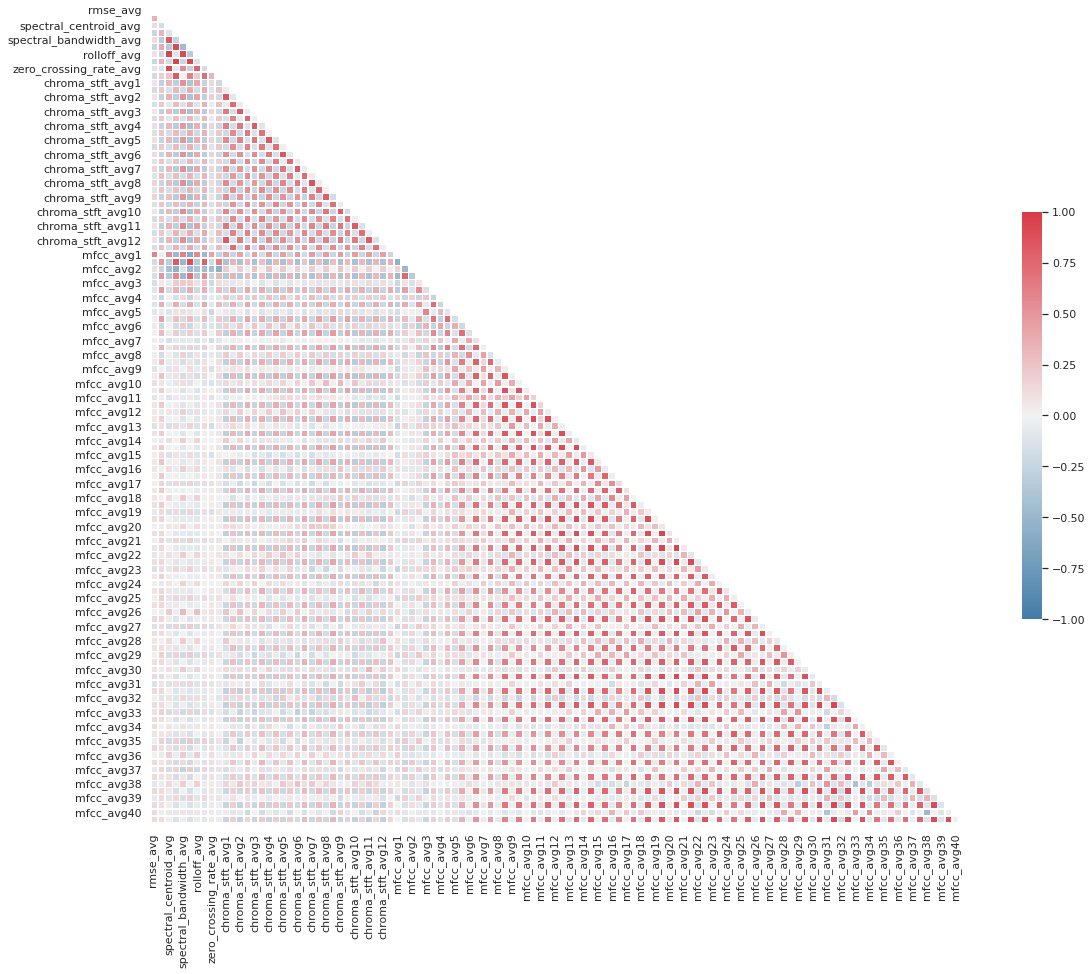

In [ ]:
# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Principal Component Analysis (PCA) - Importance

### Training Dataset

In [ ]:
# Reload features for training & test to drive
X_train = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_train.csv', header=None)

###
X_test_5 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_5.csv', header=None)

##
X_test_7 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_7.csv',header=None)

#
X_test_8 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_8.csv',header=None)

##
X_test_9 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_9.csv',header=None)

##
X_test_10 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_10.csv',header=None)
#X_test_10 = X_test_10.to_numpy()



In [ ]:
type(X_test_5)

pandas.core.frame.DataFrame

In [ ]:
X_test_5.head(10)

0         1         2         3         4         5         6    \
0 -0.871579  0.678088 -1.602801  0.479063 -2.292118  0.533603 -1.633414   
1 -0.976938 -0.694141  0.161705 -0.331015  0.164664 -0.393344  0.143356   
2 -0.993002 -0.709137 -0.105488 -0.480339  0.132942 -0.564613 -0.000271   
3 -0.966286 -0.672001  0.304065  0.157863  0.556261  0.056193  0.386392   
4 -0.989578 -0.711342  0.039221 -0.522723  0.137636 -0.549398  0.111350   
5 -0.974405 -0.688337 -0.150640 -0.353713  0.282034 -0.430069  0.049374   
6 -0.995357 -0.716112 -0.178027 -0.376080  0.365468 -0.354684  0.071203   
7 -0.990088 -0.712424 -0.132567 -0.502108  0.410438 -0.557712  0.138813   
8 -0.985687 -0.709279 -0.274586 -0.356818  0.119069 -0.565672 -0.032336   
9  0.519992 -0.338647  0.706448 -0.456783  0.579034 -0.586454  0.553854   

        7         8         9         10        11        12        13   \
0  0.056648 -1.140577  0.142790 -1.809681 -1.012827 -1.623899 -0.372053   
1 -0.665155  0.262024  0.225111  0.242772  0.509426  0.226751  0.738157   
2 -0.582737 -0.140327 -0.183548  0.814626  0.361710  0.759337  0.396341   
3  0.301686  0.174319  0.505962  0.474047  0.854073  0.600810  0.855174   
4 -0.682760  0.035484 -0.092182  1.383884  0.099998  1.182824  0.427592   
5 -0.452033 -0.456176 -0.046840  0.953095  0.853774  0.826708  0.471295   
6 -0.387361 -0.454511 -0.465328  1.174364  0.328560  1.059240  0.239853   
7 -0.594661 -0.465057 -0.386594  1.370689  0.155573  1.099176 -0.139640   
8 -0.439887 -0.525717 -0.091910  1.614626  0.054048  1.154590 -0.290598   
9 -0.483435  0.776998 -0.454937  1.341901 -0.970698  1.319354 -0.589291   

        14        15        16        17        18        19        20   \
0 -1.724874 -1.097279 -1.811578 -1.809500 -1.975384 -2.182038 -1.840678   
1  0.482006  0.905267  0.581090  0.360244  0.838398  0.559833  0.682871   
2  0.375716  0.267713  0.189377  0.183995  0.859963  0.623628  1.145149   
3  0.302217  0.889380  0.455332  0.905263  0.288209  1.022771 -0.218838   
4  0.497183  0.188273  0.251035  0.004519  0.372726  0.407271  0.230084   
5  0.685134 -0.127898  0.809876  0.320874  0.907960  0.210674  0.620103   
6  1.013933  0.327233  0.777376  0.029305  0.702892  0.109475  0.807788   
7  1.267374 -0.108351  1.243496  0.098845  1.160280 -0.095345  1.063145   
8  0.718618 -0.366047  0.698846  0.094269  0.826115  0.131724  0.480835   
9  1.160520 -0.703428  0.984773 -0.856819  1.143322 -0.953327  2.190286   

        21        22        23        24        25        26        27   \
0 -1.991171 -1.838902 -2.131331 -1.801011 -1.542264 -1.628281  0.456772   
1  1.195967  0.081368  0.556929  0.079652  0.712482  0.330839  0.973900   
2  0.857180  0.594975  0.500552  0.233260  0.489153 -0.036713 -0.020723   
3  0.894883 -0.477478  0.584463 -0.252353  1.080445 -0.193009  0.785530   
4  0.234154  0.097703  0.315125  0.281199  0.530099 -0.019081  0.166765   
5  0.633954  0.263983  0.337511  0.298588  0.653645 -0.080090  0.405051   
6  0.241110  0.742076  0.285440  0.759002  0.314832  0.510546 -0.006318   
7  0.289860  0.720322  0.235246  0.354830 -0.058205  0.339061 -0.456328   
8  0.710585  0.008058  0.229915 -0.160761 -0.256950 -0.009843 -0.695408   
9 -0.851729  1.740934 -0.911819  1.253209 -0.791953  1.200641 -0.880844   

        28        29        30        31        32        33        34   \
0 -1.694391  0.201840 -1.850678 -1.835480 -1.739763 -1.715870 -1.983571   
1  0.596770  0.863714  0.297148  0.470585  0.132297  0.325246 -0.940192   
2  0.358503  0.376420  0.753838  0.689001  0.462016  0.134085 -1.152645   
3  0.027504  0.696440  0.158506  0.753999  0.145094  0.822696 -0.877646   
4  0.072217  0.025090  0.537843  0.148302  1.161693  0.551220 -1.075399   
5  0.041215  0.605955  0.453715  0.563327  0.820094  0.768900 -1.084375   
6  0.729221  0.279141  1.107838  0.325004  0.901188  0.252017 -1.255129   
7  0.769005 -0.151047  1.168309  0.299984  1.203663  0.455652 -1.181486   
8  0.723117  0.238009  1.2690

In [ ]:
X_test_5.shape

(936, 114)

In [ ]:
print(X_test_5)

          0         1         2         3         4         5         6    \
0   -0.871579  0.678088 -1.602801  0.479063 -2.292118  0.533603 -1.633414   
1   -0.976938 -0.694141  0.161705 -0.331015  0.164664 -0.393344  0.143356   
2   -0.993002 -0.709137 -0.105488 -0.480339  0.132942 -0.564613 -0.000271   
3   -0.966286 -0.672001  0.304065  0.157863  0.556261  0.056193  0.386392   
4   -0.989578 -0.711342  0.039221 -0.522723  0.137636 -0.549398  0.111350   
..        ...       ...       ...       ...       ...       ...       ...   
931  0.635013 -0.567429 -1.392095 -0.635781 -1.420563 -0.245551 -1.346159   
932  0.695007 -0.549753 -1.406096 -0.720268 -1.444155 -0.381827 -1.361528   
933  0.711067 -0.526579 -1.397293 -0.644652 -1.392784 -0.306110 -1.357811   
934 -0.876237 -0.008518 -1.370511  0.514146 -2.004357  0.672826 -1.401233   
935 -0.759787  0.691538 -1.546913  0.426201 -2.170694  0.713396 -1.572293   

          7         8         9         10        11        12        13   

In [ ]:
# Implement PCA
from sklearn.decomposition import PCA
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(X_train))

# Extract the explained variance
explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

df_pca

0         1         2         3         4         5         6    \
0     7.070586  0.334254 -3.074707 -1.710434  1.456710 -1.254750  2.258131   
1     5.514676  0.814335 -1.535748 -1.602958  0.538881 -1.533586  1.748181   
2     4.946902  1.355369 -1.531144 -1.874781  0.619608 -0.791733  1.880601   
3     5.948143  1.491213 -1.573217 -1.718100  0.366457 -0.709047  1.958458   
4    -0.906069 -0.848750 -1.720819 -2.128851  4.083838 -1.201021 -0.772783   
...        ...       ...       ...       ...       ...       ...       ...   
4494  5.843227 -1.165184  1.834842  4.556309  2.057075 -0.633113  1.968644   
4495  5.845564 -0.193333 -1.533181  3.660258  1.360041 -1.680720  2.114021   
4496  6.265042 -1.309143  1.820798 -0.029889  1.187172  0.448210  2.472971   
4497  6.623354 -1.630657  1.026313  0.621690  1.563350 -0.450430  3.279374   
4498  7.270666 -1.908055  1.238683  0.585669  2.518397  0.788279  2.825974   

           7         8         9         10        11        12        13   \
0     2.248111 -0.988045  1.095841  1.553466  0.672801 -0.578143 -1.263099   
1     2.691816 -0.975237  0.376018  2.127961  0.658170 -0.732150 -1.047725   
2     2.534986 -0.324207  0.459891  1.314703  0.779653 -0.781655 -0.966622   
3     3.091623 -1.276252  0.466409  1.493916  0.388197 -0.663906 -0.888646   
4     1.300715  0.099563 -1.212609  0.534092  0.824285 -0.414382 -0.552611   
...        ...       ...       ...       ...       ...       ...       ...   
4494 -2.248584  1.410397  3.851188 -1.786726  0.230740 -3.924732  5.456909   
4495 -1.180580  0.828630  1.248222 -1.113817 -0.827076 -2.384569  4.010874   
4496 -2.384802 -1.393322  0.685390  1.302768 -0.473270 -1.129947  2.080443   
4497 -3.639305 -1.022358  0.032208  2.281643  0.625201 -0.274834  2.901265   
4498 -3.323658 -1.563267  0.670554  1.491254  0.071998 -0.621532  2.328858   

           14        15        16        17        18        19        20   \
0    -0.824888 -0.100982 -0.024274 -0.485689  0.295035  0.862910 -0.504026   
1    -1.039795 -0.467662  0.429119 -0.190497  0.290168  0.664916 -0.720328   
2    -0.528766  0.399359  0.233951 -0.326727  1.061892  0.609032 -0.304121   
3    -0.842832  0.491710  0.867603 -0.643540  1.442811  0.578858 -0.430004   
4    -0.025091 -0.373909 -0.069774  0.199001 -1.345522  0.259722 -0.086642   
...        ...       ...       ...       ...       ...       ...       ...   
4494 -4.139067 -0.967893  6.201255  1.065596  2.165925  1.591352  2.612033   
4495 -4.305142 -1.740257  4.821961  1.229700  1.668868  1.329698  2.115589   
4496  0.545323 -0.732067  0.539691 -1.324112  0.535905  0.008190 -0.094312   
4497  1.022092 -0.819006 -0.211609 -1.677071  0.324650  0.336959 -0.925594   
4498  0.016351 -0.224276  0.393379 -1.830269  0.072400  0.313519  0.066634   

           21        22        23        24        25        26        27   \
0     1.239566 -0.839177 -0.400075  0.578264 -0.768597  1.067242 -0.589866   
1     1.419794 -1.523262  0.679528  0.616404 -0.930114  1.184181 -1.046263   
2     1.198761 -1.353410 -0.303842  1.026070 -0.562872  0.763996 -0.738023   
3     1.097243 -1.410045 -0.432365  0.866896 -0.260469  0.910314 -0.766447   
4     0.260113 -0.818961 -0.661134  0.037537 -0.979880  0.513978  0.570429   
...        ...       ...       ...       ...       ...       ...       ...   
4494 -0.075966 -1.659122 -0.905338 -1.207370 -1.126155  2.637475 -0.918029   
4495  0.461662 -1.383763 -0.155889 -0.528238  0.006965  1.052943 -1.402181   
4496 -0.490836 -1.414098  0.138384  0.027645  0.152223 -0.391150 -0.755502   
4497 -0.179403 -1.442286 -0.125951  0.536580  0.029506 -0.990999 -1.113184   
4498 -0.845854 -1.264735 -0.732992  0.265019  0.331296 -0.000980 -0.405933   

           28        29        30        31        32        33        34   \
0     1.327918  0.702130  1.433049  0.044991 -0.507907  0.304646 -0.527161   
1     1.711930  1.101341  1.100602 -0.000911 -0.951731  0.468182 -0.139595   
2     1.128256  1.297269  1.1

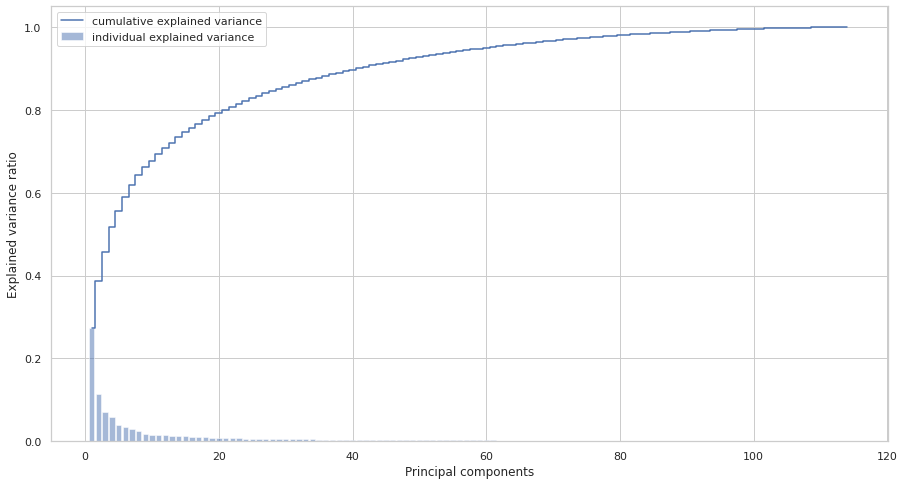

In [ ]:
# Create an x for each component
x = np.arange(1,len(explained_variance)+1)

# Plot performance
plt.bar(x, explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,115), np.cumsum(explained_variance), where= 'mid', label='cumulative explained variance')
plt.rcParams["figure.figsize"] = (15, 8)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

In [ ]:
#iterate over the components to print the explained variance
total_variance = 0
for i in range(0, 114):
    total_variance += explained_variance[i]
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance and total is {total_variance*100:>2.2f}%")

Component  0 accounts for 27.29% of variance and total is 27.29%
Component  1 accounts for 11.43% of variance and total is 38.71%
Component  2 accounts for 6.97% of variance and total is 45.69%
Component  3 accounts for 5.97% of variance and total is 51.65%
Component  4 accounts for 3.94% of variance and total is 55.60%
Component  5 accounts for 3.47% of variance and total is 59.07%
Component  6 accounts for 2.86% of variance and total is 61.93%
Component  7 accounts for 2.39% of variance and total is 64.31%
Component  8 accounts for 1.84% of variance and total is 66.15%
Component  9 accounts for 1.62% of variance and total is 67.77%
Component 10 accounts for 1.53% of variance and total is 69.29%
Component 11 accounts for 1.45% of variance and total is 70.74%
Component 12 accounts for 1.39% of variance and total is 72.13%
Component 13 accounts for 1.28% of variance and total is 73.41%
Component 14 accounts for 1.18% of variance and total is 74.59%
Component 15 accounts for 1.10% of var

In [ ]:
# Set the components to 90 (99% threshold)
n=90
pca = PCA(n_components=n) 

# Fit the model to our data and extract the results
final_pca = pca.fit_transform(df_pca)

# Create a dataframe from the final pca dataset
X_train_pca = pd.DataFrame(data = final_pca, columns = [f'Component {i}' for i in range(1,n+1)])
X_train_pca

Component 1  Component 2  Component 3  Component 4  Component 5  \
0        7.070586     0.334254    -3.074707    -1.710434     1.456710   
1        5.514676     0.814335    -1.535748    -1.602958     0.538881   
2        4.946902     1.355369    -1.531144    -1.874781     0.619608   
3        5.948143     1.491213    -1.573217    -1.718100     0.366457   
4       -0.906069    -0.848750    -1.720819    -2.128851     4.083838   
...           ...          ...          ...          ...          ...   
4494     5.843227    -1.165184     1.834842     4.556309     2.057075   
4495     5.845564    -0.193333    -1.533181     3.660258     1.360041   
4496     6.265042    -1.309143     1.820798    -0.029889     1.187172   
4497     6.623354    -1.630657     1.026313     0.621690     1.563350   
4498     7.270666    -1.908055     1.238683     0.585669     2.518397   

      Component 6  Component 7  Component 8  Component 9  Component 10  \
0       -1.254750     2.258131     2.248111    -0.988045      1.095841   
1       -1.533586     1.748182     2.691816    -0.975237      0.376018   
2       -0.791733     1.880601     2.534986    -0.324207      0.459892   
3       -0.709047     1.958458     3.091623    -1.276251      0.466410   
4       -1.201021    -0.772783     1.300715     0.099563     -1.212609   
...           ...          ...          ...          ...           ...   
4494    -0.633113     1.968644    -2.248584     1.410397      3.851188   
4495    -1.680720     2.114021    -1.180580     0.828630      1.248222   
4496     0.448210     2.472971    -2.384802    -1.393322      0.685390   
4497    -0.450430     3.279374    -3.639305    -1.022358      0.032208   
4498     0.788279     2.825974    -3.323658    -1.563267      0.670554   

      Component 11  Component 12  Component 13  Component 14  Component 15  \
0         1.553466      0.672802     -0.578144     -1.263099     -0.824887   
1         2.127961      0.658170     -0.732150     -1.047725     -1.039795   
2         1.314703      0.779653     -0.781654     -0.966621     -0.528767   
3         1.493916      0.388197     -0.663906     -0.888645     -0.842831   
4         0.534092      0.824285     -0.414382     -0.552611     -0.025091   
...            ...           ...           ...           ...           ...   
4494     -1.786726      0.230740     -3.924733      5.456908     -4.139066   
4495     -1.113816     -0.827076     -2.384569      4.010874     -4.305142   
4496      1.302768     -0.473270     -1.129946      2.080444      0.545321   
4497      2.281643      0.625200     -0.274834      2.901267      1.022092   
4498      1.491253      0.071999     -0.621532      2.328857      0.016351   

      Component 16  Component 17  Component 18  Component 19  Component 20  \
0        -0.100982     -0.024275     -0.485689      0.295036      0.862908   
1        -0.467661      0.429119     -0.190498      0.290172      0.664913   
2         0.399359      0.233950     -0.326730      1.061889      0.609032   
3         0.491710      0.867602     -0.643540      1.442808      0.578860   
4        -0.373909     -0.069774      0.199003     -1.345523      0.259722   
...            ...           ...           ...           ...           ...   
4494     -0.967893      6.201255      1.065601      2.165921      1.591357   
4495     -1.740257      4.821962      1.229701      1.668866      1.329702   
4496     -0.732068      0.539689     -1.324114      0.535902      0.008188   
4497     -0.819008     -0.211613     -1.677067      0.324637      0.336965   
4498     -0.224275      0.393379     -1.830267      0.072405      0.313517   

      Component 21  Component 22  Component 23  Component 24  Component 25  \
0        -0.504022      1.239562     -0.839178     -0.400078      0.578260   
1        -0.720326      1.419789     -1.523265      0.679522      0.616402   
2        -0.304123      1.198767     -1.353402     -0.303848      1.026064   
3        -0.430004      1.097244     -1.410041     -0.

In [ ]:
# Save target and features for training to drive
X_train_pca.to_csv('/content/drive/MyDrive/dataset/variables/pca/x_train_pca.csv', index=False,header =None)

### Test Dataset

In [ ]:
# Apply to test dataset
X_test_5_pca = pca.transform(X_test_5)

X_test_5_pca = pd.DataFrame(data = X_test_5_pca, columns = [f'Component {i}' for i in range(1,n+1)])
X_test_5_pca

Component 1  Component 2  Component 3  Component 4  Component 5  \
0      -0.871579     0.678088    -1.602801     0.479063    -2.292118   
1      -0.976938    -0.694141     0.161705    -0.331015     0.164664   
2      -0.993002    -0.709137    -0.105488    -0.480339     0.132942   
3      -0.966286    -0.672001     0.304065     0.157863     0.556261   
4      -0.989578    -0.711342     0.039221    -0.522723     0.137636   
..           ...          ...          ...          ...          ...   
931     0.635013    -0.567429    -1.392095    -0.635781    -1.420563   
932     0.695007    -0.549753    -1.406096    -0.720268    -1.444155   
933     0.711067    -0.526579    -1.397293    -0.644652    -1.392784   
934    -0.876237    -0.008518    -1.370511     0.514146    -2.004357   
935    -0.759787     0.691538    -1.546913     0.426201    -2.170694   

     Component 6  Component 7  Component 8  Component 9  Component 10  \
0       0.533603    -1.633414     0.056648    -1.140577      0.142790   
1      -0.393344     0.143356    -0.665155     0.262024      0.225111   
2      -0.564613    -0.000271    -0.582737    -0.140327     -0.183548   
3       0.056193     0.386392     0.301686     0.174319      0.505962   
4      -0.549398     0.111350    -0.682760     0.035484     -0.092182   
..           ...          ...          ...          ...           ...   
931    -0.245551    -1.346159    -0.655620    -1.167993     -0.907239   
932    -0.381827    -1.361528    -0.832592    -1.171262     -0.910689   
933    -0.306110    -1.357811    -0.643276    -1.169442     -0.907906   
934     0.672826    -1.401233     0.309237    -0.875889      0.607066   
935     0.713396    -1.572293     0.198492    -1.114364     -0.025950   

     Component 11  Component 12  Component 13  Component 14  Component 15  \
0       -1.809681     -1.012827     -1.623899     -0.372052     -1.724874   
1        0.242772      0.509426      0.226751      0.738157      0.482006   
2        0.814626      0.361710      0.759337      0.396341      0.375716   
3        0.474047      0.854073      0.600810      0.855174      0.302217   
4        1.383884      0.099998      1.182824      0.427592      0.497183   
..            ...           ...           ...           ...           ...   
931     -0.360936     -1.922677      0.826180     -2.042323      2.473801   
932     -0.402238     -2.230720      0.803860     -2.257015      2.472933   
933     -0.413448     -2.311974      0.799789     -2.116093      2.454996   
934     -0.931536      1.166944     -0.934547      1.063084     -0.835779   
935     -1.869510     -1.465019     -1.646919     -0.637591     -1.656094   

     Component 16  Component 17  Component 18  Component 19  Component 20  \
0       -1.097279     -1.811578     -1.809499     -1.975383     -2.182039   
1        0.905267      0.581090      0.360243      0.838398      0.559833   
2        0.267713      0.189378      0.183995      0.859963      0.623628   
3        0.889381      0.455333      0.905262      0.288208      1.022771   
4        0.188273      0.251035      0.004519      0.372726      0.407271   
..            ...           ...           ...           ...           ...   
931     -2.504054      2.660554     -2.311098      1.348279     -1.993691   
932     -2.465631      2.665525     -2.374349      1.355898     -1.992399   
933     -2.028917      2.649049     -2.080966      1.371626     -1.966567   
934      1.395322     -0.847059      1.252043     -0.923174      1.059473   
935     -0.659979     -1.664623     -0.593874     -1.804490     -0.937248   

     Component 21  Component 22  Component 23  Component 24  Component 25  \
0       -1.840677     -1.991169     -1.838899     -2.131332     -1.801005   
1        0.682870      1.195966      0.081365      0.556929      0.079649   
2        1.145148      0.857179      0.594974      0.500554      0.233256   
3       -0.218839      0.894881     -0.477481      0.584463     -0.252359   
4        0.230084      0.234

In [ ]:
X_test_7_pca = pca.transform(X_test_7)
X_test_7_pca = pd.DataFrame(data = X_test_7_pca, columns = [f'Component {i}' for i in range(1,n+1)])
##
X_test_8_pca = pca.transform(X_test_8)
X_test_8_pca = pd.DataFrame(data = X_test_8_pca, columns = [f'Component {i}' for i in range(1,n+1)])
##
X_test_9_pca = pca.transform(X_test_9)
X_test_9_pca = pd.DataFrame(data = X_test_9_pca, columns = [f'Component {i}' for i in range(1,n+1)])
##
X_test_10_pca = pca.transform(X_test_10)
X_test_10_pca = pd.DataFrame(data = X_test_10_pca, columns = [f'Component {i}' for i in range(1,n+1)])


In [ ]:
##
X_test_5_pca.to_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_5_pca.csv', index=False, header =None)
X_test_7_pca.to_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_7_pca.csv', index=False,header =None)
X_test_8_pca.to_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_8_pca.csv', index=False,header =None)
X_test_9_pca.to_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_9_pca.csv', index=False,header =None)
X_test_10_pca.to_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_10_pca.csv', index=False,header =None)


# Training

In [ ]:
# Read original variables from drive
X_train = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_train.csv',header =None)
y_train = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/y_train.csv',header =None)

In [ ]:
# Read pca variables from drive
X_train_pca = pd.read_csv('/content/drive/MyDrive/dataset/variables/pca/x_train_pca.csv',header =None)



## Artificial Neural Network (ANN)

---



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Activation

In [ ]:
import random
import numpy as np
import tensorflow as tf
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
# Importing variables
X_train = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_train.csv',header =None)
X_train_pca = pd.read_csv('/content/drive/MyDrive/dataset/variables/pca/x_train_pca.csv',header =None)
y_train = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/y_train.csv',header =None)

In [ ]:
X_train = X_train.to_numpy()
X_train_pca = X_train_pca.to_numpy()
y_train = y_train.to_numpy()

In [ ]:
print(X_train.shape)
print(X_train_pca.shape)
print(y_train.shape)

(4499, 114)
(4499, 90)
(4499, 1)


In [ ]:
initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=1234)

### Single Layer Perceptron

#### Original

In [ ]:
# SINGLE-LAYER PERCEPTRON (SLP) NEURAL NETWORK
'''
    A Feed-forward neural network with:
    - 114 inputs
    - 1 hidden layer (number of nodes: 2/3 of input + output) 
    - 10 outputs

    '''
# Define model
slp_1 = Sequential()
slp_1.add(layers.Dense(80, activation='relu',kernel_initializer=initializer, input_shape=(114,)))
slp_1.add(layers.Dense(10, activation='softmax'))



In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
slp_1.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
slp_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                9200      
                                                                 
 dense_1 (Dense)             (None, 10)                810       
                                                                 
Total params: 10,010
Trainable params: 10,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
history_slp_1 = slp_1.fit(X_train, y_train, epochs=300, batch_size=128)
loss_sln_1, acc_sln_1 = slp_1.evaluate(X_train, y_train)

Epoch 1/300
36/36 [==============================] - 1s 2ms/step - loss: 1.6281 - sparse_categorical_accuracy: 0.4659
Epoch 2/300
36/36 [==============================] - 0s 2ms/step - loss: 0.9953 - sparse_categorical_accuracy: 0.7286
Epoch 3/300
36/36 [==============================] - 0s 2ms/step - loss: 0.7753 - sparse_categorical_accuracy: 0.7808
Epoch 4/300
36/36 [==============================] - 0s 2ms/step - loss: 0.6550 - sparse_categorical_accuracy: 0.8122
Epoch 5/300
36/36 [==============================] - 0s 2ms/step - loss: 0.5732 - sparse_categorical_accuracy: 0.8340
Epoch 6/300
36/36 [==============================] - 0s 2ms/step - loss: 0.5102 - sparse_categorical_accuracy: 0.8511
Epoch 7/300
36/36 [==============================] - 0s 2ms/step - loss: 0.4582 - sparse_categorical_accuracy: 0.8673
Epoch 8/300
36/36 [==============================] - 0s 2ms/step - loss: 0.4183 - sparse_categorical_accuracy: 0.8753
Epoch 9/300
36/36 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_sln_1, acc_sln_1))

Train Loss: 0.000359, Train Accuracy: 0.999778


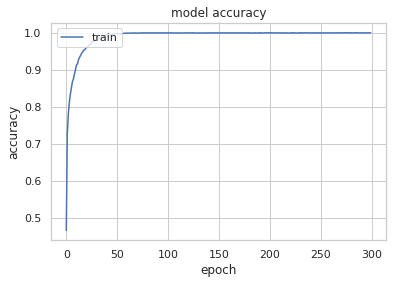

In [ ]:
#Single Layer Perceptron Accuracy Plot 
import matplotlib.pyplot as plt

plt.plot(history_slp_1.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

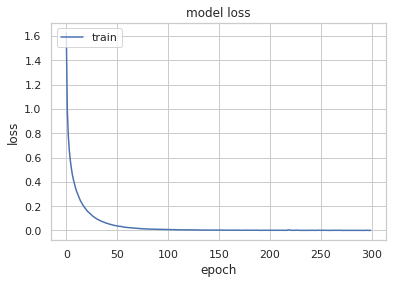

In [ ]:
#Single Layer Perceptron Loss Plot
plt.plot(history_slp_1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
history_slp_1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy'])

In [ ]:
import numpy as np

y_pred = np.argmax(slp_1.predict(X_train), axis=-1)
y_pred

array([3, 3, 3, ..., 9, 9, 9])

In [ ]:
#Confusion Matrix SLP_1
cm_slp_1 = confusion_matrix(y_train, y_pred)


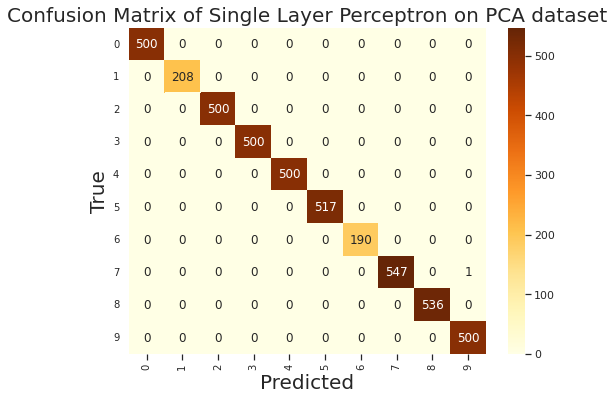

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_slp_1, annot=True, ax = ax, cmap ='YlOrBr',  fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Single Layer Perceptron on PCA dataset', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

#### PCA

In [ ]:
# SINGLE-LAYER PERCEPTRON (SLP) NEURAL NETWORK
'''
    A Feed-forward neural network with:
    - 90 inputs
    - 1 hidden layer (number of nodes: 2/3 of input + output) 
    - 10 outputs

    '''
# Define model
sln_1_pca = Sequential()
sln_1_pca.add(layers.Dense(70, activation = 'relu',kernel_initializer=initializer, input_shape=(90,)))
sln_1_pca.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
sln_1_pca.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Fit the model
history_sln_1_pca = sln_1_pca.fit(X_train_pca, y_train, epochs=200, batch_size=128)
loss_sln_1_pca, acc_sln_1_pca = sln_1_pca.evaluate(X_train_pca, y_train)

Epoch 1/200
36/36 [==============================] - 0s 2ms/step - loss: 1.9983 - sparse_categorical_accuracy: 0.3921
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 1.3165 - sparse_categorical_accuracy: 0.7475
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 0.9299 - sparse_categorical_accuracy: 0.7962
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 0.7236 - sparse_categorical_accuracy: 0.8251
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 0.6036 - sparse_categorical_accuracy: 0.8486
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 0.5227 - sparse_categorical_accuracy: 0.8629
Epoch 7/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4621 - sparse_categorical_accuracy: 0.8793
Epoch 8/200
36/36 [==============================] - 0s 2ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.8909
Epoch 9/200
36/36 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_sln_1_pca, acc_sln_1_pca))

Train Loss: 0.000829, Train Accuracy: 0.999778


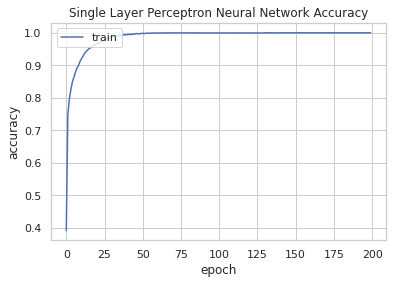

In [ ]:
plt.plot(history_sln_1_pca.history['sparse_categorical_accuracy'])
plt.title('Single Layer Perceptron Neural Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

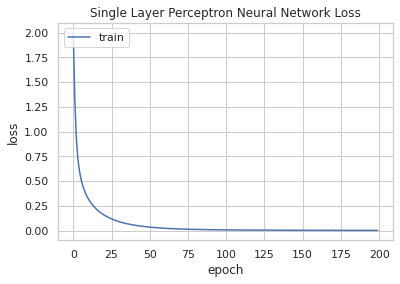

In [ ]:
#Single Layer Perceptron Loss Plot
plt.plot(history_sln_1_pca.history['loss'])
plt.title('Single Layer Perceptron Neural Network Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
y_pred_sln_1_pca = np.argmax(sln_1_pca.predict(X_train_pca), axis=-1)
y_pred_sln_1_pca

array([3, 3, 3, ..., 9, 9, 9])

In [ ]:
#Confusion Matrix
cm_sln_1_pca = confusion_matrix(y_train, y_pred_sln_1_pca)


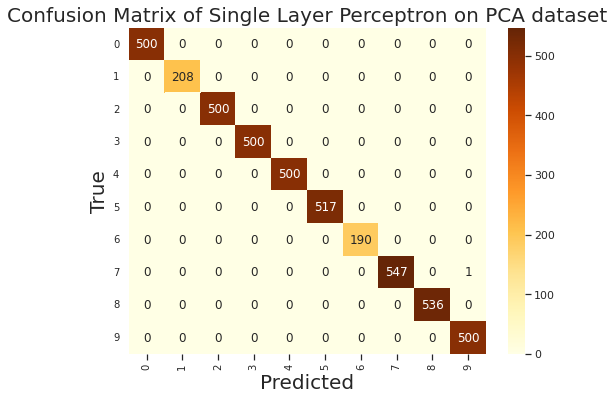

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_sln_1_pca, annot=True, ax = ax, cmap ='YlOrBr',  fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Single Layer Perceptron on PCA dataset', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

### Multi-layer Perceptron

#### Original

In [ ]:
# MULTI-LAYER PERCEPTRON (MLP) NEURAL NETWORK
'''
    A Feed-forward neural network with:
    - 90 inputs
    - 2 hidden layer (max number of nodes: 2/3 of input + output) 
    - 10 outputs

    '''

mlp_1 = Sequential()
mlp_1.add(layers.Dense(50, activation='relu',kernel_initializer= initializer, input_shape=(114,)))
mlp_1.add(layers.Dense(30, activation='relu'))
mlp_1.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
mlp_1.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Fit the model
history_mlp_1 = mlp_1.fit(X_train, y_train, epochs=300, batch_size=128)
loss_mlp_1, acc_mlp_1 = mlp_1.evaluate(X_train, y_train)

Epoch 1/300
36/36 [==============================] - 1s 2ms/step - loss: 1.8291 - sparse_categorical_accuracy: 0.4150
Epoch 2/300
36/36 [==============================] - 0s 2ms/step - loss: 1.1635 - sparse_categorical_accuracy: 0.6544
Epoch 3/300
36/36 [==============================] - 0s 2ms/step - loss: 0.8539 - sparse_categorical_accuracy: 0.7513
Epoch 4/300
36/36 [==============================] - 0s 2ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.7966
Epoch 5/300
36/36 [==============================] - 0s 2ms/step - loss: 0.5938 - sparse_categorical_accuracy: 0.8235
Epoch 6/300
36/36 [==============================] - 0s 2ms/step - loss: 0.5262 - sparse_categorical_accuracy: 0.8453
Epoch 7/300
36/36 [==============================] - 0s 2ms/step - loss: 0.4679 - sparse_categorical_accuracy: 0.8635
Epoch 8/300
36/36 [==============================] - 0s 2ms/step - loss: 0.4254 - sparse_categorical_accuracy: 0.8786
Epoch 9/300
36/36 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_mlp_1, acc_mlp_1))

Train Loss: 0.000353, Train Accuracy: 1.000000


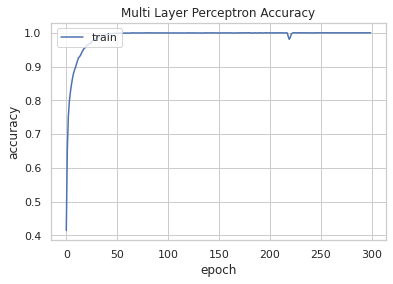

In [ ]:
##Accuracy Plot -Multi Layer Perceptron 
plt.plot(history_mlp_1.history['sparse_categorical_accuracy'])
plt.title('Multi Layer Perceptron Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

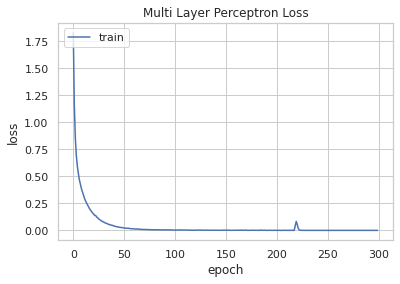

In [ ]:
#Multi Layer Perceptron Loss Plot
plt.plot(history_mlp_1.history['loss'])
plt.title('Multi Layer Perceptron Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
y_pred_mlp_1 = np.argmax(mlp_1.predict(X_train), axis=-1)
y_pred_mlp_1

array([3, 3, 3, ..., 9, 9, 9])

In [ ]:
#Confusion Matrix
cm_mlp_1 = confusion_matrix(y_train, y_pred_mlp_1)


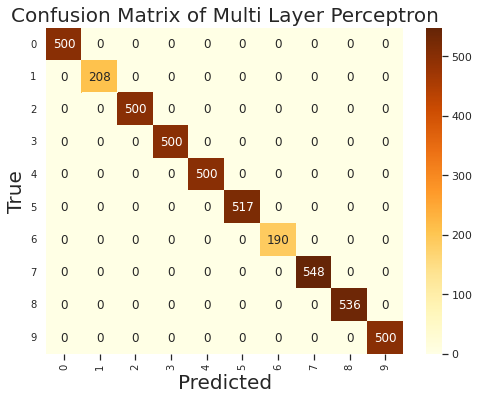

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_mlp_1, annot=True, ax = ax, cmap ='YlOrBr', fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Multi Layer Perceptron', fontsize=20)

plt.show()

#### PCA

In [ ]:
##MLP with PCA selected features
initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=1234)

mlp_1_pca = Sequential()
mlp_1_pca.add(layers.Dense(40, activation='relu',kernel_initializer= initializer, input_shape=(90,)))
mlp_1_pca.add(layers.Dense(30, activation='relu'))
mlp_1_pca.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
mlp_1_pca.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Fit the model
history_mlp_1_pca = mlp_1_pca.fit(X_train_pca, y_train, epochs=200, batch_size=128)
loss_mlp_1_pca, acc_mlp_1_pca = mlp_1_pca.evaluate(X_train_pca, y_train)

Epoch 1/200
36/36 [==============================] - 1s 5ms/step - loss: 2.0566 - sparse_categorical_accuracy: 0.2901
Epoch 2/200
36/36 [==============================] - 0s 5ms/step - loss: 1.5140 - sparse_categorical_accuracy: 0.5921
Epoch 3/200
36/36 [==============================] - 0s 4ms/step - loss: 1.0641 - sparse_categorical_accuracy: 0.7157
Epoch 4/200
36/36 [==============================] - 0s 4ms/step - loss: 0.7903 - sparse_categorical_accuracy: 0.7971
Epoch 5/200
36/36 [==============================] - 0s 6ms/step - loss: 0.6244 - sparse_categorical_accuracy: 0.8369
Epoch 6/200
36/36 [==============================] - 0s 4ms/step - loss: 0.5216 - sparse_categorical_accuracy: 0.8557
Epoch 7/200
36/36 [==============================] - 0s 5ms/step - loss: 0.4501 - sparse_categorical_accuracy: 0.8677
Epoch 8/200
36/36 [==============================] - 0s 5ms/step - loss: 0.3981 - sparse_categorical_accuracy: 0.8860
Epoch 9/200
36/36 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_mlp_1_pca, acc_mlp_1_pca))

Train Loss: 0.000522, Train Accuracy: 0.999778


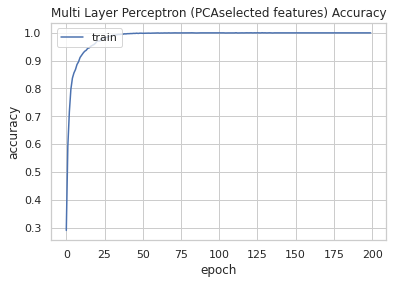

In [ ]:
#Multi Layer Perceptron PCA Accuracy Plot
plt.plot(history_mlp_1_pca.history['sparse_categorical_accuracy'])
plt.title('Multi Layer Perceptron (PCAselected features) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

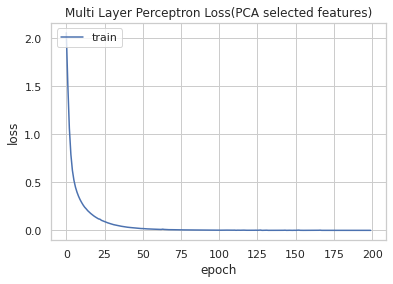

In [ ]:
#Multi Layer Perceptron Loss Plot
plt.plot(history_mlp_1_pca.history['loss'])
plt.title('Multi Layer Perceptron Loss(PCA selected features)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
#Label Prediction
y_pred_mlp_1_pca = np.argmax(mlp_1_pca.predict(X_train_pca), axis=-1)
y_pred_mlp_1_pca


array([3, 3, 3, ..., 9, 9, 9])

In [ ]:
#Confusion Matrix
cm_mlp_1_pca = confusion_matrix(y_train, y_pred_mlp_1_pca)


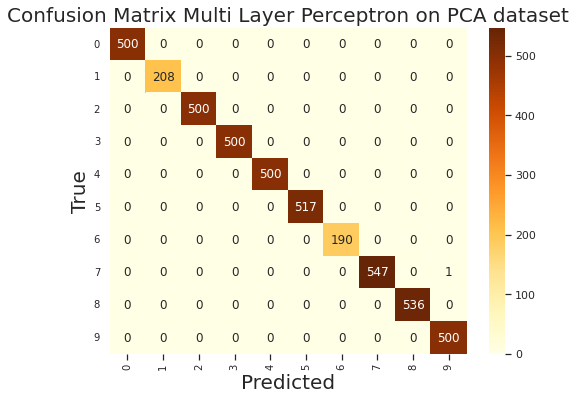

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_mlp_1_pca, annot=True, ax = ax, cmap ='YlOrBr' , fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix Multi Layer Perceptron on PCA dataset', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

### MLP w/Dropout 

#### Original

In [ ]:
mlp_2 = Sequential()
mlp_2.add(layers.Dense(40, activation='relu',kernel_initializer= initializer, input_shape=(114,)))
mlp_2.add(Dropout(0.5))
mlp_2.add(layers.Dense(30, activation='relu'))
mlp_2.add(Dropout(0.5))
mlp_2.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
mlp_2.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Fit the model
history_mlp_2 = mlp_2.fit(X_train, y_train, epochs=300, batch_size=128)
loss_mlp_2, acc_mlp_2 = mlp_2.evaluate(X_train, y_train)

Epoch 1/300
36/36 [==============================] - 1s 2ms/step - loss: 2.2079 - sparse_categorical_accuracy: 0.1823
Epoch 2/300
36/36 [==============================] - 0s 2ms/step - loss: 1.9268 - sparse_categorical_accuracy: 0.2934
Epoch 3/300
36/36 [==============================] - 0s 2ms/step - loss: 1.7652 - sparse_categorical_accuracy: 0.3574
Epoch 4/300
36/36 [==============================] - 0s 3ms/step - loss: 1.6177 - sparse_categorical_accuracy: 0.4183
Epoch 5/300
36/36 [==============================] - 0s 2ms/step - loss: 1.5372 - sparse_categorical_accuracy: 0.4323
Epoch 6/300
36/36 [==============================] - 0s 2ms/step - loss: 1.4299 - sparse_categorical_accuracy: 0.4952
Epoch 7/300
36/36 [==============================] - 0s 2ms/step - loss: 1.3816 - sparse_categorical_accuracy: 0.5039
Epoch 8/300
36/36 [==============================] - 0s 2ms/step - loss: 1.3066 - sparse_categorical_accuracy: 0.5257
Epoch 9/300
36/36 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_mlp_2, acc_mlp_2))

Train Loss: 0.120262, Train Accuracy: 0.967548


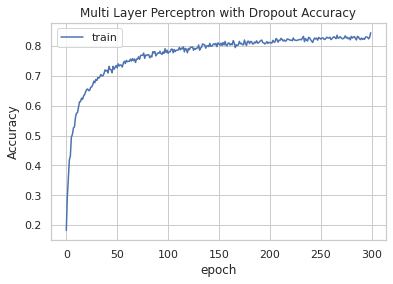

In [ ]:
#Multi Layer Perceptron with Dropout Accuracy Plot
plt.plot(history_mlp_2.history['sparse_categorical_accuracy'])
plt.title('Multi Layer Perceptron with Dropout Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

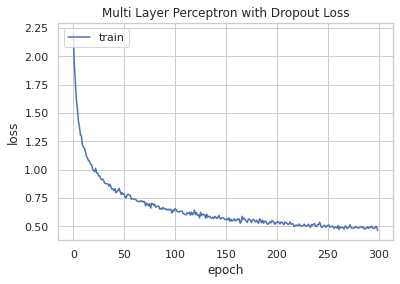

In [ ]:
#Multi Layer Perceptron with Dropout Loss Plot 
plt.plot(history_mlp_2.history['loss'])
plt.title('Multi Layer Perceptron with Dropout Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
y_pred_mlp_2 = np.argmax(mlp_2.predict(X_train), axis=-1)
y_pred_mlp_2



array([3, 3, 3, ..., 9, 9, 9])

In [ ]:
#Confusion Matrix
cm_mlp_2 = confusion_matrix(y_train, y_pred_mlp_2)


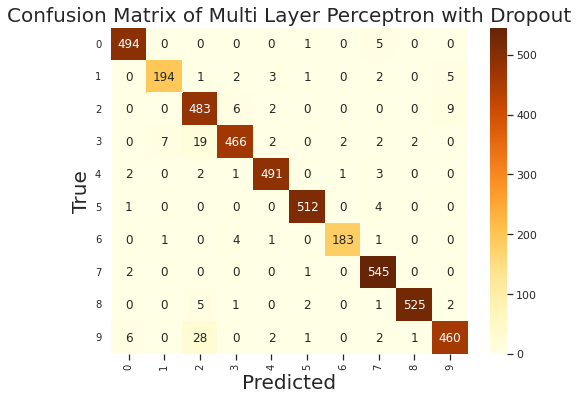

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_mlp_2, annot=True, ax = ax,cmap ='YlOrBr', fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Multi Layer Perceptron with Dropout', fontsize=20)
plt.show()

####PCA

In [ ]:
mlp_2_pca = Sequential()
mlp_2_pca.add(layers.Dense(40, activation='relu',kernel_initializer= initializer, input_shape=(90,)))
mlp_2_pca.add(Dropout(0.5))
mlp_2_pca.add(layers.Dense(30, activation='relu'))
mlp_2_pca.add(Dropout(0.5))
mlp_2_pca.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
mlp_2_pca.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Fit the model
history_mlp_2_pca = mlp_2_pca.fit(X_train_pca, y_train, epochs=200, batch_size=128)
loss_mlp_2_pca, acc_mlp_2_pca = mlp_2_pca.evaluate(X_train_pca, y_train)

Epoch 1/200
36/36 [==============================] - 1s 2ms/step - loss: 2.3089 - sparse_categorical_accuracy: 0.1525
Epoch 2/200
36/36 [==============================] - 0s 2ms/step - loss: 2.0896 - sparse_categorical_accuracy: 0.2485
Epoch 3/200
36/36 [==============================] - 0s 2ms/step - loss: 1.8943 - sparse_categorical_accuracy: 0.3287
Epoch 4/200
36/36 [==============================] - 0s 2ms/step - loss: 1.7268 - sparse_categorical_accuracy: 0.3941
Epoch 5/200
36/36 [==============================] - 0s 2ms/step - loss: 1.5696 - sparse_categorical_accuracy: 0.4405
Epoch 6/200
36/36 [==============================] - 0s 2ms/step - loss: 1.4455 - sparse_categorical_accuracy: 0.4839
Epoch 7/200
36/36 [==============================] - 0s 2ms/step - loss: 1.3775 - sparse_categorical_accuracy: 0.5099
Epoch 8/200
36/36 [==============================] - 0s 3ms/step - loss: 1.3088 - sparse_categorical_accuracy: 0.5377
Epoch 9/200
36/36 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_mlp_2_pca, acc_mlp_2_pca))

Train Loss: 0.156611, Train Accuracy: 0.957768


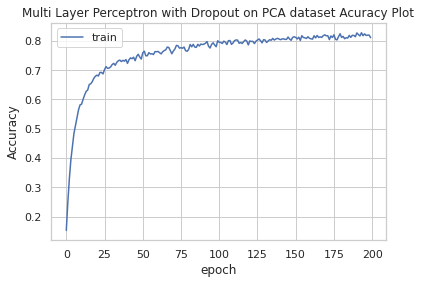

In [ ]:
#Multi Layer Perceptron with Dropout on PCA dataset Accuracy Plot
plt.plot(history_mlp_2_pca.history['sparse_categorical_accuracy'])
plt.title('Multi Layer Perceptron with Dropout on PCA dataset Acuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

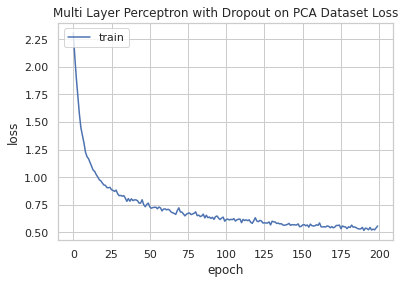

In [ ]:
##Multi Layer Perceptron with Dropout on PCA dataset Loss Plot
plt.plot(history_mlp_2_pca.history['loss'])
plt.title('Multi Layer Perceptron with Dropout on PCA Dataset Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
y_pred_mlp_2_pca = np.argmax(mlp_2_pca.predict(X_train_pca), axis=-1)
y_pred_mlp_2_pca

array([3, 3, 3, ..., 9, 9, 9])

In [ ]:
#Confusion Matrix
cm_mlp_2_pca = confusion_matrix(y_train, y_pred_mlp_2_pca)


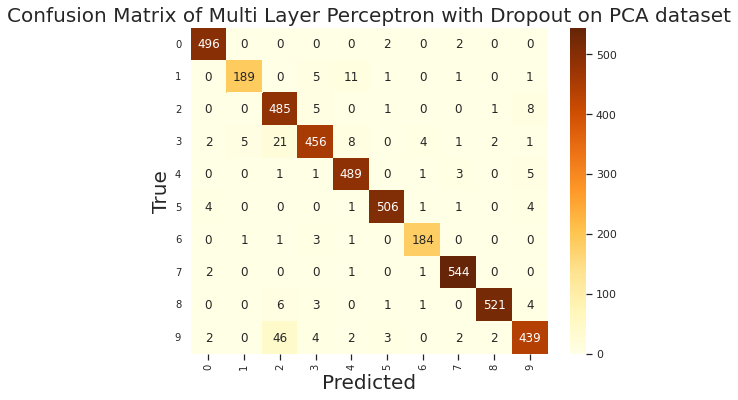

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_mlp_2_pca, annot=True, ax = ax, cmap ='YlOrBr', fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Multi Layer Perceptron with Dropout on PCA dataset', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

### MLP w/Dropout and weights

#### Orginal

In [ ]:
!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=2a031e7389d7569f95b086f874b8a6d41ceef8df68f32826670432bc7a8453a2
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.utils import class_weight

In [ ]:
y_train = y_train.flatten()

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.8998,
 1: 2.1629807692307694,
 2: 0.8998,
 3: 0.8998,
 4: 0.8998,
 5: 0.8702127659574468,
 6: 2.3678947368421053,
 7: 0.820985401459854,
 8: 0.8393656716417911,
 9: 0.8998}

In [ ]:
mlp_3 = Sequential()
mlp_3.add(layers.Dense(50, activation='relu', kernel_initializer= initializer, input_shape=(114,)))
mlp_3.add(Dropout(0.7))
mlp_3.add(layers.Dense(30, activation='relu'))
mlp_3.add(Dropout(0.7))
mlp_3.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
mlp_3.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Fit the model
history_mlp_3 = mlp_3.fit(X_train, y_train, epochs=400, batch_size=64, class_weight=class_weights)
loss_mlp_3, acc_mlp_3 = mlp_3.evaluate(X_train, y_train)

Epoch 1/400
71/71 [==============================] - 1s 2ms/step - loss: 2.4104 - sparse_categorical_accuracy: 0.1329
Epoch 2/400
71/71 [==============================] - 0s 2ms/step - loss: 2.2034 - sparse_categorical_accuracy: 0.1805
Epoch 3/400
71/71 [==============================] - 0s 2ms/step - loss: 2.0895 - sparse_categorical_accuracy: 0.2163
Epoch 4/400
71/71 [==============================] - 0s 2ms/step - loss: 1.9878 - sparse_categorical_accuracy: 0.2629
Epoch 5/400
71/71 [==============================] - 0s 2ms/step - loss: 1.9112 - sparse_categorical_accuracy: 0.2783
Epoch 6/400
71/71 [==============================] - 0s 2ms/step - loss: 1.8174 - sparse_categorical_accuracy: 0.2990
Epoch 7/400
71/71 [==============================] - 0s 2ms/step - loss: 1.7695 - sparse_categorical_accuracy: 0.3101
Epoch 8/400
71/71 [==============================] - 0s 2ms/step - loss: 1.7194 - sparse_categorical_accuracy: 0.3432
Epoch 9/400
71/71 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_mlp_3, acc_mlp_3))

Train Loss: 0.316729, Train Accuracy: 0.930651


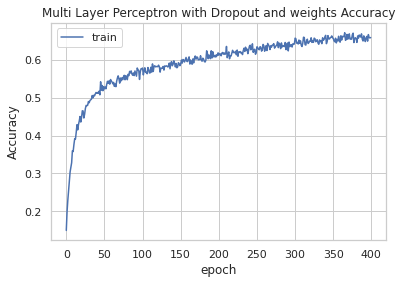

In [ ]:
#Multi Layer Perceptron with Dropout and weights Accuracy Plot 
plt.plot(history_mlp_3.history['sparse_categorical_accuracy'])
plt.title('Multi Layer Perceptron with Dropout and weights Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

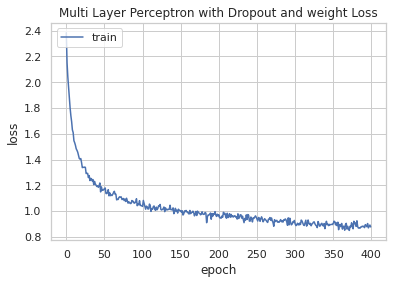

In [ ]:
##Multi Layer Perceptron with Dropout and weights Loss Plot
plt.plot(history_mlp_3.history['loss'])
plt.title('Multi Layer Perceptron with Dropout and weight Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
y_test.dtype

dtype('int64')

In [ ]:
from ann_visualizer.visualize import ann_viz;

ann_viz(mlp_3, title="Final Model")

In [ ]:
#Label Predictions
y_pred_mlp_3 = np.argmax(mlp_3.predict(X_train), axis=-1)
y_pred_mlp_3

array([3, 3, 3, ..., 9, 9, 9])

In [ ]:
#Confusion Matrix 
cm_mlp_3 = confusion_matrix(y_train, y_pred_mlp_3)


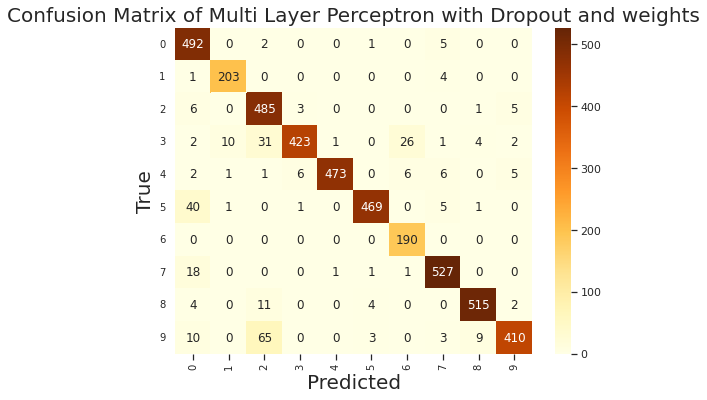

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_mlp_3, annot=True, ax = ax,cmap ='YlOrBr', fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Multi Layer Perceptron with Dropout and weights', fontsize=20)

plt.show()

####PCA

In [ ]:
mlp_3_pca = Sequential()
mlp_3_pca.add(layers.Dense(40, activation='relu',kernel_initializer= initializer, input_shape=(90,)))
mlp_3_pca.add(Dropout(0.7))
mlp_3_pca.add(layers.Dense(30, activation='relu'))
mlp_3_pca.add(Dropout(0.7))
mlp_3_pca.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
mlp_3_pca.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Fit the model
history_mlp_3_pca = mlp_3_pca.fit(X_train_pca, y_train, epochs=200, batch_size=64, class_weight=class_weights)
loss_mlp_3_pca, acc_mlp_3_pca = mlp_3_pca.evaluate(X_train_pca, y_train)

Epoch 1/200
71/71 [==============================] - 1s 2ms/step - loss: 2.1777 - sparse_categorical_accuracy: 0.1792
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 1.8271 - sparse_categorical_accuracy: 0.2921
Epoch 3/200
71/71 [==============================] - 0s 2ms/step - loss: 1.7091 - sparse_categorical_accuracy: 0.3256
Epoch 4/200
71/71 [==============================] - 0s 2ms/step - loss: 1.6368 - sparse_categorical_accuracy: 0.3467
Epoch 5/200
71/71 [==============================] - 0s 3ms/step - loss: 1.5996 - sparse_categorical_accuracy: 0.3636
Epoch 6/200
71/71 [==============================] - 0s 2ms/step - loss: 1.5588 - sparse_categorical_accuracy: 0.3761
Epoch 7/200
71/71 [==============================] - 0s 2ms/step - loss: 1.5329 - sparse_categorical_accuracy: 0.3943
Epoch 8/200
71/71 [==============================] - 0s 2ms/step - loss: 1.4880 - sparse_categorical_accuracy: 0.3985
Epoch 9/200
71/71 [==============================] - 0s 

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_mlp_3_pca, acc_mlp_3_pca))

Train Loss: 0.786253, Train Accuracy: 0.713492


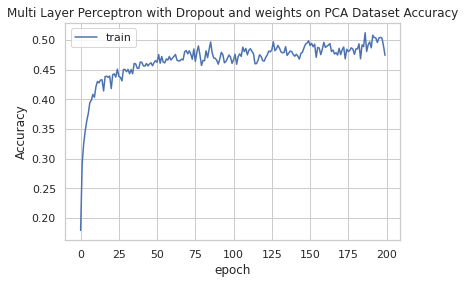

In [ ]:
##Multi Layer Perceptron with Dropout and Weights on PCA dataset Accuracy Plot
plt.plot(history_mlp_3_pca.history['sparse_categorical_accuracy'])
plt.title('Multi Layer Perceptron with Dropout and weights on PCA Dataset Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

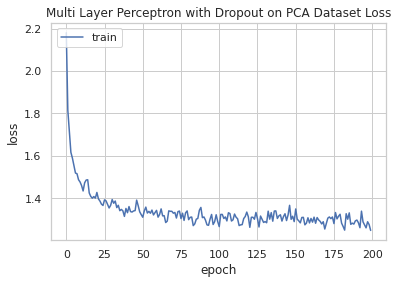

In [ ]:
##Multi Layer Perceptron with Dropout and Weights on PCA dataset Loss Plot
plt.plot(history_mlp_3_pca.history['loss'])
plt.title('Multi Layer Perceptron with Dropout on PCA Dataset Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
#Label Predictions
y_pred_mlp_3_pca = np.argmax(mlp_3_pca.predict(X_train_pca), axis=-1)
y_pred_mlp_3_pca

array([3, 3, 3, ..., 9, 2, 9])

In [ ]:
##Confusion Matrix
cm_mlp_3_pca = confusion_matrix(y_train, y_pred_mlp_3_pca)


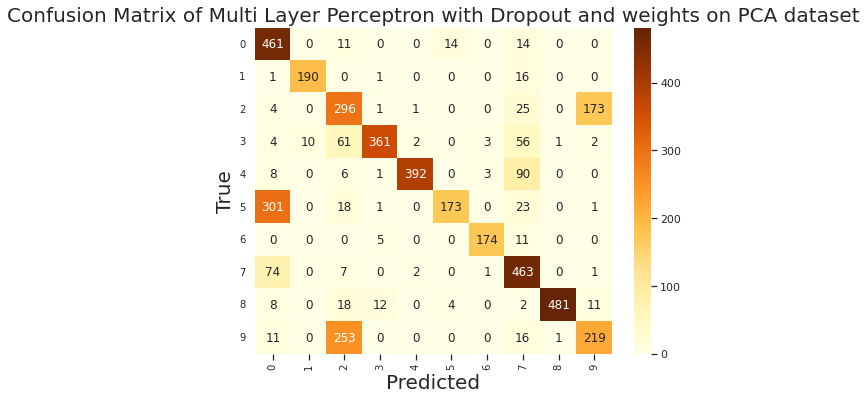

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm_mlp_3_pca, annot=True, ax = ax,cmap ='YlOrBr', fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Multi Layer Perceptron with Dropout and weights on PCA dataset', fontsize=20)

plt.show()

## Convolutional Neural Network (CNN)

### Image Pre-processing

#### Train

In [ ]:
#Unzip the image folder
!unzip '/content/drive/MyDrive/dataset/png.zip' -d '/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/UrbanSound8K/png/fold3/186339-9-0-1.png  
  inflating: /content/UrbanSound8K/png/fold3/58857-2-0-13.png  
  inflating: /content/UrbanSound8K/png/fold3/13230-0-0-8.png  
  inflating: /content/UrbanSound8K/png/fold3/22601-8-0-44.png  
  inflating: /content/UrbanSound8K/png/fold3/199769-1-0-6.png  
  inflating: /content/UrbanSound8K/png/fold3/199769-1-0-10.png  
  inflating: /content/UrbanSound8K/png/fold3/103199-4-7-2.png  
  inflating: /content/UrbanSound8K/png/fold3/29721-4-0-3.png  
  inflating: /content/UrbanSound8K/png/fold3/22601-8-0-8.png  
  inflating: /content/UrbanSound8K/png/fold3/177742-0-0-204.png  
  inflating: /content/UrbanSound8K/png/fold3/31884-7-0-0.png  
  inflating: /content/UrbanSound8K/png/fold3/17973-2-0-17.png  
  inflating: /content/UrbanSound8K/png/fold3/62837-7-1-41.png  
  inflating: /content/UrbanSound8K/png/fold3/54898-8-0-1.png  
  inflating: /content/UrbanSound8K/png/fold3/52077-3-0-

In [ ]:
# Define new audio path
png_path = os.path.join(us8k_path, '/content/UrbanSound8K/png')

In [ ]:
import cv2

img_array, labels, height_array, width_array = [], [], [], []

# Loop over all IDs and read each image in one by one
folds = 'fold1 fold2 fold3 fold4 fold6'.split()
for f in folds:
    for filename in os.listdir(png_path + str('/') + str(f)):
        imagename = f'{png_path}/{f}/{filename}'
        image = cv2.imread (imagename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dim = (30, 30)
        image = cv2.resize(image, dim) # resize image
        img_array.append (image)
        with open("/content/UrbanSound8K/metadata/UrbanSound8K.csv", "r") as csvfile:
            reader = csv.reader(csvfile)
            next(reader)
            for row in reader:
              if filename == f'{str(row[0])[:-4]}.png':
                labels.append(int(row[6]))

X_train = np.array(img_array)
y_train = np.array(labels)


In [ ]:
# Saving NumPy array as a file
np.save('/content/drive/MyDrive/dataset/variables/cnn/X_train', X_train)

# Saving NumPy array as a file
np.save('/content/drive/MyDrive/dataset/variables/cnn/y_train', y_train)

In [ ]:
# Read cnn variables from drive
X_train_img = np.load('/content/drive/MyDrive/dataset/variables/cnn/X_train.npy')
y_train_img = np.load('/content/drive/MyDrive/dataset/variables/cnn/y_train.npy')


In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(X_train_img[0])

In [ ]:
print(X_train_img.shape)
print(y_train_img.shape)

(4499, 30, 30)
(4499,)


In [ ]:
X_train_img = X_train_img.reshape(X_train_img.shape[0], X_train_img.shape[1], X_train_img.shape[2], 1)
print(X_train_img.shape)

(4499, 30, 30, 1)


In [ ]:
# confirm pixel range is 0-255
print('Data Type: %s' % X_train_img.dtype)
print('Min: %.3f, Max: %.3f' % (X_train_img.min(), X_train_img.max()))

Data Type: uint8
Min: 3.000, Max: 255.000


In [ ]:
# convert from integers to floats
X_train_img = X_train_img.astype('float32')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# creating the image data generator [1.0/255.0 = 0.00392156862]
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
datagen.fit(X_train_img)

# preparing an iterator for scaling images
train_iterator = datagen.flow(X_train_img, y_train_img, batch_size=64)
print('Batches train=%d' % len(train_iterator))

# confirming- the scaling works
# demonstrate effect on a single batch of samples
# get a batch
batchX, batchy = train_iterator.next()
# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())
# demonstrate effect on entire training dataset
iterator = datagen.flow(X_train_img, y_train_img, batch_size=len(X_train_img), shuffle=False)
# get a batch
batchX, batchy = iterator.next()
# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Batches train=71
(64, 30, 30, 1) 0.018784197 0.998765
(4499, 30, 30, 1) 1.7486917e-06 1.0


#### Test

In [ ]:
img_array2, labels2, height_array2, width_array2 = [], [], [], []

# Loop over all IDs and read each image in one by one
folds = 'fold5'.split()
for f in folds:
  for filename in os.listdir(png_path + str('/') + str(f)):
      imagename = f'{png_path}/{f}/{filename}'
      image = cv2.imread (imagename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      dim = (30, 30)
      image = cv2.resize(image, dim) # resize image
      img_array2.append (image)
      with open("/content/UrbanSound8K/metadata/UrbanSound8K.csv", "r") as csvfile:
          reader = csv.reader(csvfile)
          next(reader)
          for row in reader:
            if filename == f'{str(row[0])[:-4]}.png':
              labels2.append(int(row[6]))

X_test_5 = np.array(img_array2)
y_test_5 = np.array(labels2)


In [ ]:
img_array3, labels3, height_array3, width_array3 = [], [], [], []

# Loop over all IDs and read each image in one by one
folds = 'fold7'.split()
for f in folds:
  for filename in os.listdir(png_path + str('/') + str(f)):
      imagename = f'{png_path}/{f}/{filename}'
      image = cv2.imread (imagename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      dim = (30, 30)
      image = cv2.resize(image, dim) # resize image
      img_array3.append (image)
      with open("/content/UrbanSound8K/metadata/UrbanSound8K.csv", "r") as csvfile:
          reader = csv.reader(csvfile)
          next(reader)
          for row in reader:
            if filename == f'{str(row[0])[:-4]}.png':
              labels3.append(int(row[6]))

X_test_7 = np.array(img_array3)
y_test_7 = np.array(labels3)

In [ ]:
img_array4, labels4, height_array4, width_array4 = [], [], [], []

# Loop over all IDs and read each image in one by one
folds = 'fold8'.split()
for f in folds:
  for filename in os.listdir(png_path + str('/') + str(f)):
      imagename = f'{png_path}/{f}/{filename}'
      image = cv2.imread (imagename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      dim = (30, 30)
      image = cv2.resize(image, dim) # resize image
      img_array4.append (image)
      with open("/content/UrbanSound8K/metadata/UrbanSound8K.csv", "r") as csvfile:
          reader = csv.reader(csvfile)
          next(reader)
          for row in reader:
            if filename == f'{str(row[0])[:-4]}.png':
              labels4.append(int(row[6]))

X_test_8 = np.array(img_array4)
y_test_8 = np.array(labels4)

In [ ]:
img_array5, labels5, height_array5, width_array5 = [], [], [], []

# Loop over all IDs and read each image in one by one
folds = 'fold9'.split()
for f in folds:
  for filename in os.listdir(png_path + str('/') + str(f)):
      imagename = f'{png_path}/{f}/{filename}'
      image = cv2.imread (imagename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      dim = (30, 30)
      image = cv2.resize(image, dim) # resize image
      img_array5.append (image)
      with open("/content/UrbanSound8K/metadata/UrbanSound8K.csv", "r") as csvfile:
          reader = csv.reader(csvfile)
          next(reader)
          for row in reader:
            if filename == f'{str(row[0])[:-4]}.png':
              labels5.append(int(row[6]))

X_test_9 = np.array(img_array5)
y_test_9 = np.array(labels5)

In [ ]:
img_array6, labels6, height_array6, width_array6 = [], [], [], []

# Loop over all IDs and read each image in one by one
folds = 'fold10'.split()
for f in folds:
  for filename in os.listdir(png_path + str('/') + str(f)):
      imagename = f'{png_path}/{f}/{filename}'
      image = cv2.imread (imagename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      dim = (30, 30)
      image = cv2.resize(image, dim) # resize image
      img_array6.append (image)
      with open("/content/UrbanSound8K/metadata/UrbanSound8K.csv", "r") as csvfile:
          reader = csv.reader(csvfile)
          next(reader)
          for row in reader:
            if filename == f'{str(row[0])[:-4]}.png':
              labels6.append(int(row[6]))

X_test_10 = np.array(img_array6)
y_test_10 = np.array(labels6)

In [ ]:
# Saving NumPy array as a file
np.save('/content/drive/MyDrive/dataset/variables/cnn/X_test_5', X_test_5)
np.save('/content/drive/MyDrive/dataset/variables/cnn/X_test_7', X_test_7)
np.save('/content/drive/MyDrive/dataset/variables/cnn/X_test_8', X_test_8)
np.save('/content/drive/MyDrive/dataset/variables/cnn/X_test_9', X_test_9)
np.save('/content/drive/MyDrive/dataset/variables/cnn/X_test_10', X_test_10)

# Saving NumPy array as a file
np.save('/content/drive/MyDrive/dataset/variables/cnn/y_test_5', y_test_5)
np.save('/content/drive/MyDrive/dataset/variables/cnn/y_test_7', y_test_7)
np.save('/content/drive/MyDrive/dataset/variables/cnn/y_test_8', y_test_8)
np.save('/content/drive/MyDrive/dataset/variables/cnn/y_test_9', y_test_9)
np.save('/content/drive/MyDrive/dataset/variables/cnn/y_test_10', y_test_10)

NameError: ignored

In [ ]:
# Read cnn variables from drive
X_test_img_5 = np.load('/content/drive/MyDrive/dataset/variables/cnn/X_test_5.npy')
y_test_img_5 = np.load('/content/drive/MyDrive/dataset/variables/cnn/y_test_5.npy')

##
X_test_img_7 = np.load('/content/drive/MyDrive/dataset/variables/cnn/X_test_7.npy')
y_test_img_7 = np.load('/content/drive/MyDrive/dataset/variables/cnn/y_test_7.npy')
##
X_test_img_8 = np.load('/content/drive/MyDrive/dataset/variables/cnn/X_test_8.npy')
y_test_img_8 = np.load('/content/drive/MyDrive/dataset/variables/cnn/y_test_8.npy')

##
X_test_img_9 = np.load('/content/drive/MyDrive/dataset/variables/cnn/X_test_9.npy')
y_test_img_9 = np.load('/content/drive/MyDrive/dataset/variables/cnn/y_test_9.npy')
##
X_test_img_10 = np.load('/content/drive/MyDrive/dataset/variables/cnn/X_test_10.npy')
y_test_img_10= np.load('/content/drive/MyDrive/dataset/variables/cnn/y_test_10.npy')


In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(X_test_img_5[0])

In [ ]:
print(X_test_img_5.shape)
print(y_test_img_5.shape)
print(X_test_img_7.shape)
print(y_test_img_7.shape)
print(X_test_img_8.shape)
print(y_test_img_8.shape)
print(X_test_img_9.shape)
print(y_test_img_9.shape)
print(X_test_img_10.shape)
print(y_test_img_10.shape)

(936, 30, 30)
(936,)
(838, 30, 30)
(838,)
(806, 30, 30)
(806,)
(816, 30, 30)
(816,)
(837, 30, 30)
(837,)


In [ ]:
X_test_img_5 = X_test_img_5.reshape(X_test_img_5.shape[0], X_test_img_5.shape[1], X_test_img_5.shape[2], 1)
X_test_img_7 = X_test_img_7.reshape(X_test_img_7.shape[0], X_test_img_7.shape[1], X_test_img_7.shape[2], 1)
X_test_img_8 = X_test_img_8.reshape(X_test_img_8.shape[0], X_test_img_8.shape[1], X_test_img_8.shape[2], 1)
X_test_img_9 = X_test_img_9.reshape(X_test_img_9.shape[0], X_test_img_9.shape[1], X_test_img_9.shape[2], 1)
X_test_img_10 = X_test_img_10.reshape(X_test_img_10.shape[0], X_test_img_10.shape[1], X_test_img_10.shape[2], 1)
print(X_test_img_5.shape)
print(X_test_img_7.shape)
print(X_test_img_8.shape)
print(X_test_img_9.shape)
print(X_test_img_10.shape)

(936, 30, 30, 1)
(838, 30, 30, 1)
(806, 30, 30, 1)
(816, 30, 30, 1)
(837, 30, 30, 1)


In [ ]:
# confirm pixel range is 0-255
print('Data Type: %s' % X_test_img_5.dtype)
print('Data Type: %s' % X_test_img_7.dtype)
print('Data Type: %s' % X_test_img_8.dtype)
print('Data Type: %s' % X_test_img_9.dtype)
print('Data Type: %s' % X_test_img_10.dtype)
print('Min: %.3f, Max: %.3f' % (X_test_img_5.min(), X_test_img_5.max()))
print('Min: %.3f, Max: %.3f' % (X_test_img_7.min(), X_test_img_7.max()))
print('Min: %.3f, Max: %.3f' % (X_test_img_8.min(), X_test_img_8.max()))
print('Min: %.3f, Max: %.3f' % (X_test_img_9.min(), X_test_img_9.max()))
print('Min: %.3f, Max: %.3f' % (X_test_img_10.min(), X_test_img_10.max()))

Data Type: uint8
Data Type: uint8
Data Type: uint8
Data Type: uint8
Data Type: uint8
Min: 4.000, Max: 255.000
Min: 16.000, Max: 255.000
Min: 15.000, Max: 255.000
Min: 20.000, Max: 255.000
Min: 18.000, Max: 255.000


In [ ]:
# convert from integers to floats
X_test_img_5 = X_test_img_5.astype('float32')
X_test_img_7 = X_test_img_7.astype('float32')
X_test_img_8 = X_test_img_8.astype('float32')
X_test_img_9 = X_test_img_9.astype('float32')
X_test_img_10 = X_test_img_10.astype('float32')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# creating the image data generator [1.0/255.0 = 0.00392156862]
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
datagen.fit(X_test_img_5)

# preparing an iterator for scaling images
test_iterator_5 = datagen.flow(X_test_img_5, y_test_img_5, batch_size=64)
print('Batches train=%d' % len(test_iterator_5))

# confirming- the scaling works
# demonstrate effect on a single batch of samples
# get a batch
batchX_5, batchy_5 = test_iterator_5.next()
# pixel stats in the batch
print(batchX_5.shape, batchX_5.mean(), batchX_5.std())
# demonstrate effect on entire training dataset
iterator_5 = datagen.flow(X_test_img_5, y_test_img_5, batch_size=len(X_test_img_5), shuffle=False)
# get a batch
batchX_5, batchy_5 = iterator_5.next()
# pixel stats in the batch
print(batchX_5.shape, batchX_5.mean(), batchX_5.std())

Batches train=15
(64, 30, 30, 1) 0.020745862 0.9674799
(936, 30, 30, 1) -4.677623e-07 1.0


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# creating the image data generator [1.0/255.0 = 0.00392156862]
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
datagen.fit(X_test_img_7)

# preparing an iterator for scaling images
test_iterator_7 = datagen.flow(X_test_img_7, y_test_img_7, batch_size=64)
print('Batches train=%d' % len(test_iterator_7))

# confirming- the scaling works
# demonstrate effect on a single batch of samples
# get a batch
batchX_7, batchy_7 = test_iterator_7.next()
# pixel stats in the batch
print(batchX_7.shape, batchX_7.mean(), batchX_7.std())
# demonstrate effect on entire training dataset
iterator_7 = datagen.flow(X_test_img_7, y_test_img_7, batch_size=len(X_test_img_7), shuffle=False)
# get a batch
batchX_7, batchy_7 = iterator_7.next()
# pixel stats in the batch
print(batchX_7.shape, batchX_7.mean(), batchX_7.std())

Batches train=14
(64, 30, 30, 1) -0.030807624 1.0267862
(838, 30, 30, 1) -1.5104015e-07 0.9999999


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# creating the image data generator [1.0/255.0 = 0.00392156862]
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
datagen.fit(X_test_img_8)

# preparing an iterator for scaling images
test_iterator_8 = datagen.flow(X_test_img_8, y_test_img_8, batch_size=64)
print('Batches train=%d' % len(test_iterator_8))

# confirming- the scaling works
# demonstrate effect on a single batch of samples
# get a batch
batchX_8, batchy_8 = test_iterator_8.next()
# pixel stats in the batch
print(batchX_8.shape, batchX_8.mean(), batchX_8.std())
# demonstrate effect on entire training dataset
iterator_8 = datagen.flow(X_test_img_8, y_test_img_8, batch_size=len(X_test_img_8), shuffle=False)
# get a batch
batchX_8, batchy_8 = iterator_8.next()
# pixel stats in the batch
print(batchX_8.shape, batchX_8.mean(), batchX_8.std())

Batches train=13
(64, 30, 30, 1) 0.010774941 0.96309346
(806, 30, 30, 1) 6.722786e-08 0.9999999


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# creating the image data generator [1.0/255.0 = 0.00392156862]
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
datagen.fit(X_test_img_9)

# preparing an iterator for scaling images
test_iterator_9 = datagen.flow(X_test_img_9, y_test_img_9, batch_size=64)
print('Batches train=%d' % len(test_iterator_9))

# confirming- the scaling works
# demonstrate effect on a single batch of samples
# get a batch
batchX_9, batchy_9 = test_iterator_9.next()
# pixel stats in the batch
print(batchX_9.shape, batchX_9.mean(), batchX_9.std())
# demonstrate effect on entire training dataset
iterator_9 = datagen.flow(X_test_img_9, y_test_img_9, batch_size=len(X_test_img_9), shuffle=False)
# get a batch
batchX_9, batchy_9 = iterator_9.next()
# pixel stats in the batch
print(batchX_9.shape, batchX_9.mean(), batchX_9.std())

Batches train=13
(64, 30, 30, 1) 0.041241597 0.9868996
(816, 30, 30, 1) 4.6125425e-07 1.0


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# creating the image data generator [1.0/255.0 = 0.00392156862]
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
datagen.fit(X_test_img_10)

# preparing an iterator for scaling images
test_iterator_10 = datagen.flow(X_test_img_10, y_test_img_10, batch_size=64)
print('Batches train=%d' % len(test_iterator_10))

# confirming- the scaling works
# demonstrate effect on a single batch of samples
# get a batch
batchX_10, batchy_10 = test_iterator_10.next()
# pixel stats in the batch
print(batchX_10.shape, batchX_10.mean(), batchX_10.std())
# demonstrate effect on entire training dataset
iterator_10 = datagen.flow(X_test_img_10, y_test_img_10, batch_size=len(X_test_img_10), shuffle=False)
# get a batch
batchX_10, batchy_10 = iterator_10.next()
# pixel stats in the batch
print(batchX_10.shape, batchX_10.mean(), batchX_10.std())

Batches train=14
(64, 30, 30, 1) 0.05353793 0.9655062
(837, 30, 30, 1) -9.74067e-07 1.0


### Models

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers

#### Conv-Pool-Conv-Pool

In [ ]:
import random
import numpy as np
import tensorflow as tf
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
# Conv-Pool-Conv-Pool Model
cnn_1 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(30,30,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(200, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
#Model Compile
adam = optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
cnn_1.compile(optimizer=adam,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
cnn_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 16)        3216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 400)              

In [ ]:
history_cnn_1 = cnn_1.fit(X_train_img, y_train_img, epochs=20, batch_size=32)
loss_cnn_1, acc_cnn_1 = cnn_1.evaluate(X_train_img, y_train_img)

Epoch 1/20
141/141 [==============================] - 6s 35ms/step - loss: 2.5468 - sparse_categorical_accuracy: 0.2763
Epoch 2/20
141/141 [==============================] - 5s 37ms/step - loss: 1.5997 - sparse_categorical_accuracy: 0.4172
Epoch 3/20
141/141 [==============================] - 5s 34ms/step - loss: 1.4293 - sparse_categorical_accuracy: 0.4943
Epoch 4/20
141/141 [==============================] - 5s 38ms/step - loss: 1.2957 - sparse_categorical_accuracy: 0.5275
Epoch 5/20
141/141 [==============================] - 6s 44ms/step - loss: 1.1498 - sparse_categorical_accuracy: 0.5808
Epoch 6/20
141/141 [==============================] - 5s 37ms/step - loss: 1.0210 - sparse_categorical_accuracy: 0.6350
Epoch 7/20
141/141 [==============================] - 5s 37ms/step - loss: 0.9710 - sparse_categorical_accuracy: 0.6517
Epoch 8/20
141/141 [==============================] - 7s 49ms/step - loss: 0.8681 - sparse_categorical_accuracy: 0.6882
Epoch 9/20
141/141 [====================

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_cnn_1, acc_cnn_1))

Train Loss: 0.166377, Train Accuracy: 0.947988


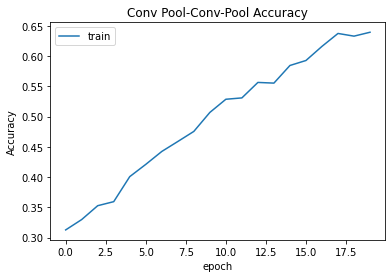

In [ ]:
# Conv-Pool-Conv-Pool Accuracy Plot
plt.plot(history_cnn_1.history['sparse_categorical_accuracy'])
plt.title('Conv Pool-Conv-Pool Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

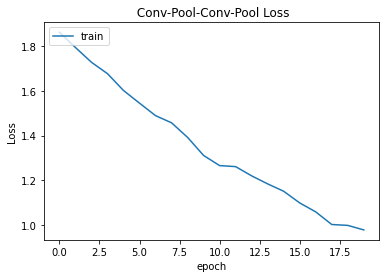

In [ ]:
# Conv-Pool-Conv-pool Loss Plot
plt.plot(history_cnn_1.history['loss'])
plt.title(' Conv-Pool-Conv-Pool Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = cnn_1.predict(X_train_img)  
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix_cnn_1 = metrics.confusion_matrix(y_true=y_train_img, y_pred=y_pred_labels)

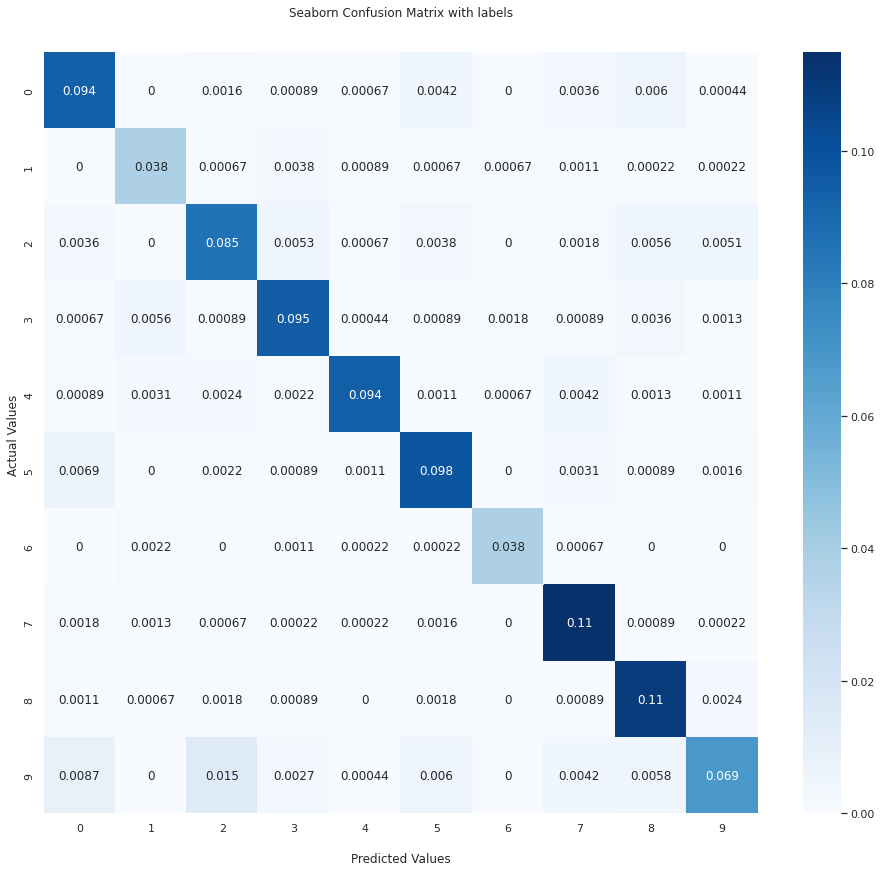

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(confusion_matrix_cnn_1/np.sum(confusion_matrix_cnn_1), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()




In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_img, y_pred_labels, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       500
           1       0.75      0.82      0.78       208
           2       0.77      0.77      0.77       500
           3       0.84      0.86      0.85       500
           4       0.95      0.85      0.90       500
           5       0.83      0.85      0.84       517
           6       0.92      0.89      0.91       190
           7       0.85      0.94      0.89       548
           8       0.82      0.92      0.87       536
           9       0.85      0.62      0.71       500

    accuracy                           0.84      4499
   macro avg       0.84      0.84      0.83      4499
weighted avg       0.84      0.84      0.83      4499



#### ConvConv - Pool - ConvConv - Pool

In [ ]:
# ConvConv - Pool - ConvConv - Pool Model 
cnn_2 = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(30,30,1)),
    Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(800, activation='relu'),    
    Dense(500, activation='relu'),
    Dense(10, activation='softmax')
])


In [ ]:
#Model Compile
adam = optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
cnn_2.compile(optimizer=adam,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
cnn_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

In [ ]:
history_cnn_2 = cnn_2.fit(X_train_img, y_train_img, epochs=20 ,batch_size=32)
loss_cnn_2, acc_cnn_2 = cnn_2.evaluate(X_train_img, y_train_img)

Epoch 1/20
141/141 [==============================] - 16s 109ms/step - loss: 2.5456 - sparse_categorical_accuracy: 0.2140
Epoch 2/20
141/141 [==============================] - 16s 112ms/step - loss: 1.8344 - sparse_categorical_accuracy: 0.3116
Epoch 3/20
141/141 [==============================] - 16s 115ms/step - loss: 1.6940 - sparse_categorical_accuracy: 0.3725
Epoch 4/20
141/141 [==============================] - 15s 105ms/step - loss: 1.5177 - sparse_categorical_accuracy: 0.4485
Epoch 5/20
141/141 [==============================] - 16s 113ms/step - loss: 1.3433 - sparse_categorical_accuracy: 0.5046
Epoch 6/20
141/141 [==============================] - 14s 96ms/step - loss: 1.1129 - sparse_categorical_accuracy: 0.6010
Epoch 7/20
141/141 [==============================] - 11s 75ms/step - loss: 0.9699 - sparse_categorical_accuracy: 0.6477
Epoch 8/20
141/141 [==============================] - 10s 74ms/step - loss: 0.8177 - sparse_categorical_accuracy: 0.7108
Epoch 9/20
141/141 [=======

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_cnn_2, acc_cnn_2))

Train Loss: 0.165062, Train Accuracy: 0.946433


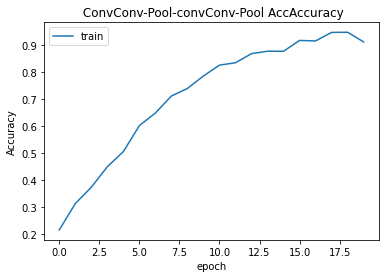

In [ ]:
##CNN2 ConvConv-Pool-convConv-Pool Accuracy Plot
plt.plot(history_cnn_2.history['sparse_categorical_accuracy'])
plt.title(' ConvConv-Pool-convConv-Pool AccAccuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

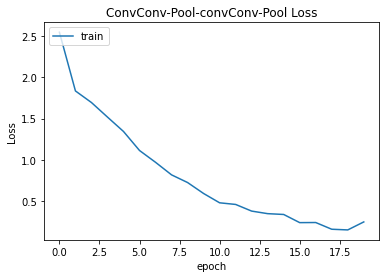

In [ ]:
##ConvConv-Pool-convConv-Pool Loss Plot
plt.plot(history_cnn_2.history['loss'])
plt.title('ConvConv-Pool-convConv-Pool Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = cnn_2.predict(X_train_img)  
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix_cnn_2 = metrics.confusion_matrix(y_true=y_train_img, y_pred=y_pred_labels)

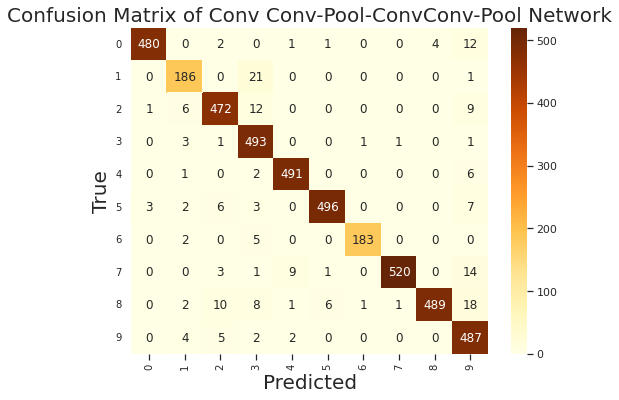

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(confusion_matrix_cnn_2, annot=True, ax = ax,cmap ='YlOrBr', fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Conv Conv-Pool-ConvConv-Pool Network', fontsize=20)

plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_img, y_pred_labels, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       500
           1       0.90      0.89      0.90       208
           2       0.95      0.94      0.94       500
           3       0.90      0.99      0.94       500
           4       0.97      0.98      0.98       500
           5       0.98      0.96      0.97       517
           6       0.99      0.96      0.98       190
           7       1.00      0.95      0.97       548
           8       0.99      0.91      0.95       536
           9       0.88      0.97      0.92       500

    accuracy                           0.96      4499
   macro avg       0.96      0.95      0.95      4499
weighted avg       0.96      0.96      0.96      4499



#### ConvConv - Pool - ConvConv - Pool Model with dropout

In [ ]:
# ConvConv - Pool - ConvConv - Pool Model with dropout
cnn_3 = Sequential()

# Conv 1
cnn_3.add(Conv2D(32, (5, 5), padding='same',
                 input_shape=(30,30,1)))
cnn_3.add(Activation('relu'))

# Conv 2
cnn_3.add(Conv2D(64, (3, 3)))
cnn_3.add(Activation('relu'))

# Pool
cnn_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn_3.add(BatchNormalization()) # Regularization

# Conv 3
cnn_3.add(Conv2D(128, (3, 3), padding='same'))
cnn_3.add(Activation('relu'))

# Conv 4
cnn_3.add(Conv2D(256, (3, 3)))
cnn_3.add(Activation('relu'))

# Pool
cnn_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn_3.add(BatchNormalization()) # Regularization

# Flatten
cnn_3.add(Flatten())

# Dense
cnn_3.add(layers.Dense(6400, activation = 'relu'))
cnn_3.add(Dropout(0.5)) # Regularization
cnn_3.add(layers.Dense(4000, activation = 'relu'))
cnn_3.add(Dropout(0.5)) # Regularization
cnn_3.add(Dense(10, activation='softmax'))

In [ ]:
adam = optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08)
cnn_3.compile(optimizer=adam,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
cnn_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        832       
                                                                 
 activation_4 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                      

In [ ]:
history_cnn_3 = cnn_3.fit(X_train_img, y_train_img, epochs=30 ,batch_size=32)
loss_cnn_3, acc_cnn_3 = cnn_3.evaluate(X_train_img, y_train_img)

Epoch 1/30
141/141 [==============================] - 177s 1s/step - loss: 3.8877 - sparse_categorical_accuracy: 0.2025
Epoch 2/30
141/141 [==============================] - 162s 1s/step - loss: 2.0807 - sparse_categorical_accuracy: 0.2367
Epoch 3/30
141/141 [==============================] - 162s 1s/step - loss: 2.0666 - sparse_categorical_accuracy: 0.2572
Epoch 4/30
141/141 [==============================] - 166s 1s/step - loss: 1.9498 - sparse_categorical_accuracy: 0.2901
Epoch 5/30
141/141 [==============================] - 160s 1s/step - loss: 1.8508 - sparse_categorical_accuracy: 0.3223
Epoch 6/30
141/141 [==============================] - 165s 1s/step - loss: 1.7735 - sparse_categorical_accuracy: 0.3514
Epoch 7/30
141/141 [==============================] - 161s 1s/step - loss: 1.6670 - sparse_categorical_accuracy: 0.4012
Epoch 8/30
141/141 [==============================] - 163s 1s/step - loss: 1.5898 - sparse_categorical_accuracy: 0.4337
Epoch 9/30
141/141 [====================

In [ ]:
print("Train Loss: %f, Train Accuracy: %f" % (loss_cnn_3, acc_cnn_3))

Train Loss: 0.804124, Train Accuracy: 0.721271


In [ ]:
##CNN3 ConvConv-Pool-convConv-Pool with Dropout Accuracy Plot
plt.plot(history_cnn_3.history['sparse_categorical_accuracy'])
plt.title(' ConvConv-Pool-convConv-Pool with dropout Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
##CNN3 ConvConv-Pool-convConv-Pool with Dropout Loss Plot
plt.plot(history_cnn_3.history['loss'])
plt.title(' ConvConv-Pool-convConv-Pool with Dropout Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe_cnn_3 = cnn_3.predict(X_train_img)  
y_pred_labels_cnn_3 = np.argmax(y_pred_ohe_cnn_3, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix_cnn_3 = metrics.confusion_matrix(y_true=y_train_img, y_pred=y_pred_labels_cnn_3)

In [ ]:
#Print Confusion Matrix 
print(confusion_matrix_cnn_3)

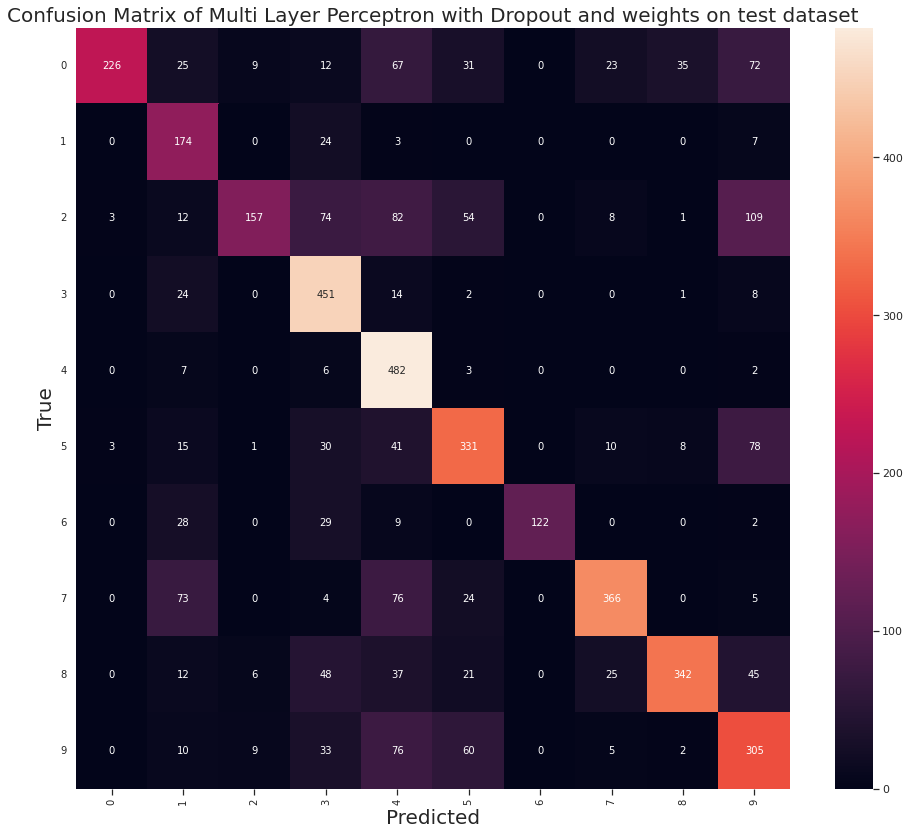

In [ ]:
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(confusion_matrix_cnn_3, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6','7', '8', '9'], fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix of Multi Layer Perceptron with Dropout and weights on test dataset', fontsize=20)

plt.show()

In [ ]:
##Classification Report 
from sklearn.metrics import classification_report
print('\nClassification Report of CNN_3\n')
print(classification_report(y_train, y_pred_labels_cnn_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report of CNN_3

              precision    recall  f1-score   support

           0       0.08      0.04      0.05       500
           1       0.05      0.09      0.06       208
           2       0.13      0.05      0.07       500
           3       0.11      0.15      0.12       500
           4       0.09      0.17      0.12       500
           5       0.13      0.13      0.13       517
           6       0.04      0.03      0.03       190
           7       0.11      0.09      0.10       548
           8       0.12      0.09      0.10       536
           9       0.12      0.16      0.14       500

    accuracy                           0.10      4499
   macro avg       0.10      0.10      0.09      4499
weighted avg       0.10      0.10      0.10      4499



In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 4.1 MB/s 


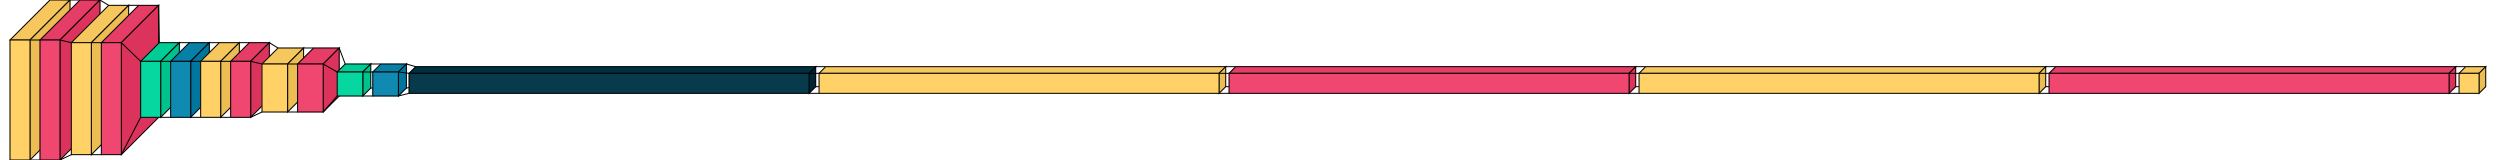

In [ ]:
import visualkeras
visualkeras.layered_view(cnn_3)

# Testing

## ANN

In [ ]:
# Importing variables
X_test_5 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_5.csv')
X_test_7 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_7.csv')
X_test_8 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_8.csv')
X_test_9 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_9.csv')
X_test_10 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/x_test_10.csv')
X_test_5_pca = pd.read_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_5_pca.csv')
X_test_7_pca = pd.read_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_7_pca.csv')
X_test_8_pca = pd.read_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_8_pca.csv')
X_test_9_pca = pd.read_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_9_pca.csv')
X_test_10_pca = pd.read_csv('/content/drive/MyDrive/dataset/variables/pca/x_test_10_pca.csv')
y_test_5 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/y_test_5.csv')
y_test_7 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/y_test_7.csv')
y_test_8 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/y_test_8.csv')
y_test_9 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/y_test_9.csv')
y_test_10 = pd.read_csv('/content/drive/MyDrive/dataset/variables/original/y_test_10.csv')


In [ ]:
# Check the type of imported Variables
type(X_test_5)

pandas.core.frame.DataFrame

In [ ]:
# Transform into array
X_test_5 = X_test_5.to_numpy()
X_test_7 = X_test_7.to_numpy()
X_test_8 = X_test_8.to_numpy()
X_test_9 = X_test_9.to_numpy()
X_test_10 = X_test_10.to_numpy()
X_test_5_pca = X_test_5_pca.to_numpy()
X_test_7_pca = X_test_7_pca.to_numpy()
X_test_8_pca = X_test_8_pca.to_numpy()
X_test_9_pca = X_test_9_pca.to_numpy()
X_test_10_pca = X_test_10_pca.to_numpy()
y_test_5 = y_test_5.to_numpy()
y_test_7 = y_test_7.to_numpy()
y_test_8 = y_test_8.to_numpy()
y_test_9 = y_test_9.to_numpy()
y_test_10 = y_test_10.to_numpy()

In [ ]:
# Defining a function to compute test score of the Model
def test_scores(model):
  score5 = model.evaluate(X_test_5, y_test_5)
  score7 = model.evaluate(X_test_7, y_test_7)
  score8 = model.evaluate(X_test_8, y_test_8)
  score9 = model.evaluate(X_test_9, y_test_9)
  score10 = model.evaluate(X_test_10, y_test_10)
  test_scores = [score5[1],score7[1],score8[1],score9[1],score10[1]]
  
  return test_scores

In [ ]:
# Validate the model MLP_3(Multi Layer Percpetron with Dropout and Weights) on Fold 5 test dataset to determine generalization
loss_mlp_3_test_5, acc_mlp_3_test_5 = mlp_3.evaluate(X_test_5, y_test_5, verbose=0)
print("\nFold 5 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3_test_5))
print("\nFold 5 Test loss: %f" % (loss_mlp_3_test_5)) 


Fold 5 Test accuracy: 53.9%

Fold 5 Test loss: 3.9%


In [ ]:
# Validate the model on Fold 7 test dataset to determine generalization
loss_mlp_3_test_7, acc_mlp_3_test_7 = mlp_3.evaluate(X_test_7, y_test_7, verbose=0)
print("\nFold 7 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3_test_7))
print("\nFold 7 Test loss: %f" % (loss_mlp_3_test_7)) 


Fold 7 Test accuracy: 57.5%

Fold 7 Test loss: 2.4%


In [ ]:
# Validate the model on Fold 8 test dataset to determine generalization
loss_mlp_3_test_8, acc_mlp_3_test_8 = mlp_3.evaluate(X_test_8, y_test_8, verbose=0)
print("\nFold 8 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3_test_8))
print("\nFold 8 Test loss: %f" % (loss_mlp_3_test_8)) 


Fold 8 Test accuracy: 58.9%

Fold 8 Test loss: 7.3%


In [ ]:
# Validate the model on Fold 9 test dataset to determine generalization
loss_mlp_3_test_9, acc_mlp_3_test_9 = mlp_3.evaluate(X_test_9, y_test_9, verbose=0)
print("\n Fold 9 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3_test_9))
print("\nFold 9 Test loss: %f" % (loss_mlp_3_test_9)) 


 Fold 9 Test accuracy: 57.4%

Fold 9 Test loss: 12.0%


In [ ]:
# Validate the model on Fold 10 test dataset to determine generalization
loss_mlp_3_test_10, acc_mlp_3_test_10 = mlp_3.evaluate(X_test_10, y_test_10, verbose=0)
print("\nFold 10 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3_test_10))
print("\nFold 10 Test loss: %f" % (loss_mlp_3_test_10)) 


Fold 10 Test accuracy: 57.4%

Fold 10 Test loss: 2.5%


In [ ]:
# Compute Test Score of Multi Layer Perceptron with Dropouts and Weights
test_scores_mlp_3 = test_scores(mlp_3)
test_scores_mlp_3

27/27 [==============================] - 0s 2ms/step - loss: 2.5328 - sparse_categorical_accuracy: 0.5742


[0.5390374064445496,
 0.5746714472770691,
 0.5888198614120483,
 0.5742331147193909,
 0.5741626620292664]

In [ ]:
type(test_scores_mlp_3)

list

In [ ]:
# Print the mean & standard deviation of the Multi Layer Perceptron with Dropouts and Weights
Mean_mlp_3 = np.mean(test_scores_mlp_3)
std_mlp_3 = np.std(test_scores_mlp_3)
print(Mean_mlp_3)
print(std_mlp_3)


0.5701848983764648
0.016551543017256646


In [ ]:
print(history_mlp_3.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy'])


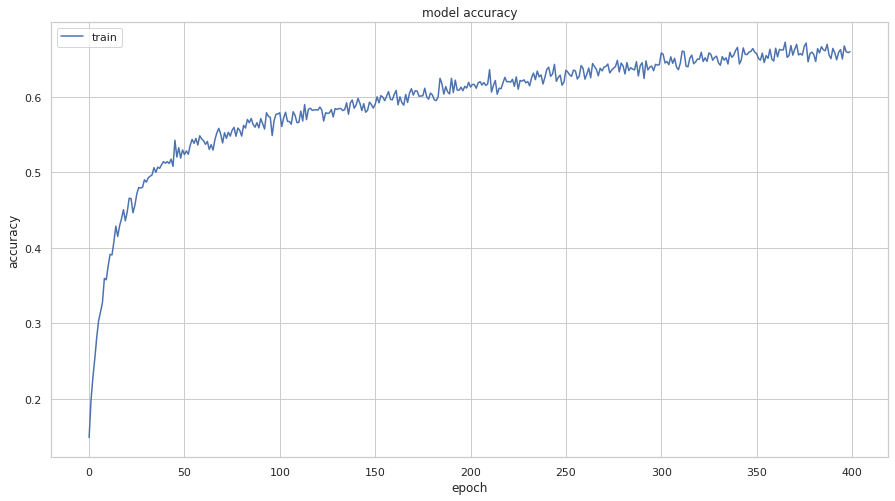

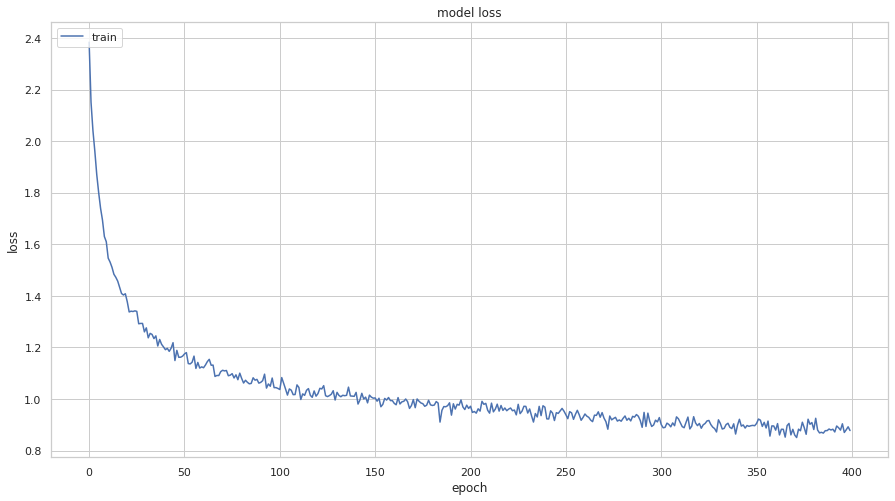

In [ ]:
# summarize history for accuracy
plt.plot(history_mlp_3.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_mlp_3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Make class predictions Test datasets with the model MLP with Dropouts and Weights
y_pred5 = np.argmax(mlp_3.predict(X_test_5), axis=-1)
y_pred7 = np.argmax(mlp_3.predict(X_test_7), axis=-1)
y_pred8 = np.argmax(mlp_3.predict(X_test_8), axis=-1)
y_pred9 = np.argmax(mlp_3.predict(X_test_9), axis=-1)
y_pred10 = np.argmax(mlp_3.predict(X_test_10), axis=-1)


In [ ]:
# Confusion Matrix for each testing Fold
cm_mlp3_test5 = confusion_matrix(y_test_5, y_pred5)
cm_mlp3_test7 = confusion_matrix(y_test_7, y_pred7)
cm_mlp3_test8 = confusion_matrix(y_test_8, y_pred8)
cm_mlp3_test9 = confusion_matrix(y_test_9, y_pred9)
cm_mlp3_test10 = confusion_matrix(y_test_10, y_pred10)


In [ ]:
# Normalise the Confusion Matrix
cmn_mlp3_test5 = cm_mlp3_test5.astype('float')/cm_mlp3_test5.sum(axis=1)[:, np.newaxis]
cmn_mlp3_test7 = cm_mlp3_test7.astype('float')/cm_mlp3_test7.sum(axis=1)[:, np.newaxis]
cmn_mlp3_test8 = cm_mlp3_test8.astype('float')/cm_mlp3_test8.sum(axis=1)[:, np.newaxis]
cmn_mlp3_test9 = cm_mlp3_test9.astype('float')/cm_mlp3_test9.sum(axis=1)[:, np.newaxis]
cmn_mlp3_test10 = cm_mlp3_test10.astype('float')/cm_mlp3_test10.sum(axis=1)[:, np.newaxis]

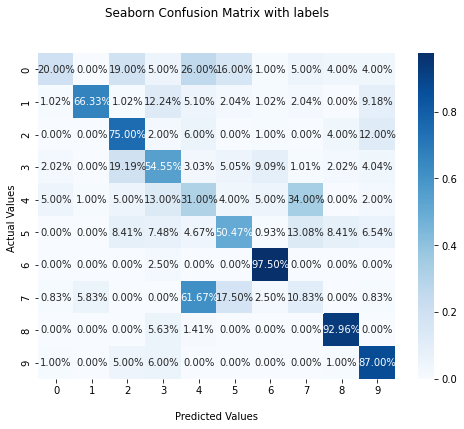

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp3_test5, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

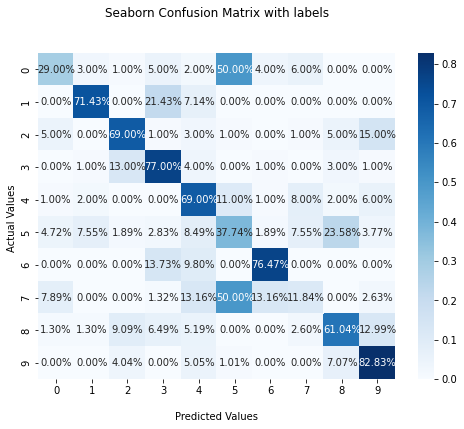

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp3_test7, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

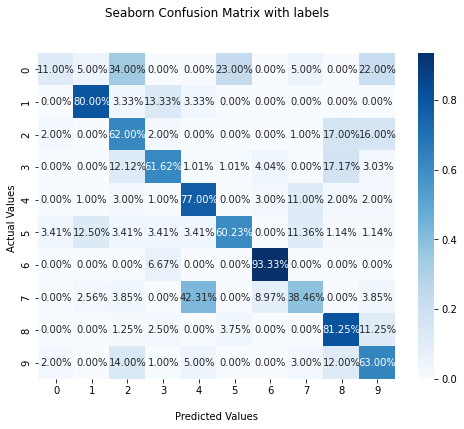

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp3_test8, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

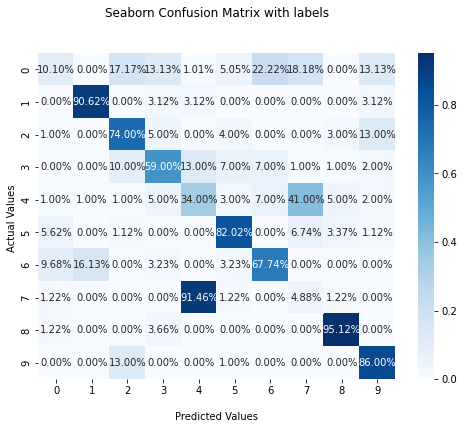

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp3_test9, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

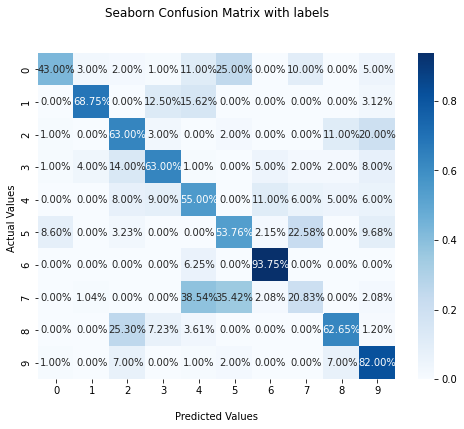

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp3_test10, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Classification Report Fold 5 
from sklearn.metrics import classification_report
print('\nClassification Report of ANN\n')
print(classification_report(y_test_5,y_pred5, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report of ANN

              precision    recall  f1-score   support

           0       0.67      0.20      0.31       100
           1       0.89      0.66      0.76        98
           2       0.56      0.75      0.64       100
           3       0.51      0.55      0.53        99
           4       0.21      0.31      0.25       100
           5       0.53      0.50      0.52       107
           6       0.65      0.97      0.78        40
           7       0.19      0.11      0.14       120
           8       0.77      0.93      0.84        71
           9       0.69      0.87      0.77       100

    accuracy                           0.54       935
   macro avg       0.57      0.59      0.55       935
weighted avg       0.55      0.54      0.52       935



In [ ]:
# Classification Report Fold 7
from sklearn.metrics import classification_report
print('\nClassification Report of ANN\n')
print(classification_report(y_test_7,y_pred7, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report of ANN

              precision    recall  f1-score   support

           0       0.62      0.29      0.39       100
           1       0.57      0.71      0.63        28
           2       0.72      0.69      0.70       100
           3       0.73      0.77      0.75       100
           4       0.61      0.69      0.65       100
           5       0.28      0.38      0.32       106
           6       0.68      0.76      0.72        51
           7       0.26      0.12      0.16        76
           8       0.53      0.61      0.57        77
           9       0.68      0.83      0.75        99

    accuracy                           0.57       837
   macro avg       0.57      0.59      0.57       837
weighted avg       0.57      0.57      0.56       837



In [ ]:
# Classification Report Fold 8
from sklearn.metrics import classification_report
print('\nClassification Report of ANN\n')
print(classification_report(y_test_8,y_pred8, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report of ANN

              precision    recall  f1-score   support

           0       0.61      0.11      0.19       100
           1       0.56      0.80      0.66        30
           2       0.47      0.62      0.53       100
           3       0.80      0.62      0.70        99
           4       0.64      0.77      0.70       100
           5       0.66      0.60      0.63        88
           6       0.67      0.93      0.78        30
           7       0.50      0.38      0.43        78
           8       0.57      0.81      0.67        80
           9       0.53      0.63      0.58       100

    accuracy                           0.59       805
   macro avg       0.60      0.63      0.59       805
weighted avg       0.60      0.59      0.56       805



In [ ]:
# Classification Report Fold 9
from sklearn.metrics import classification_report
print('\nClassification Report of ANN\n')
print(classification_report(y_test_9,y_pred9, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report of ANN

              precision    recall  f1-score   support

           0       0.45      0.10      0.17        99
           1       0.83      0.91      0.87        32
           2       0.64      0.74      0.69       100
           3       0.68      0.59      0.63       100
           4       0.27      0.34      0.30       100
           5       0.77      0.82      0.79        89
           6       0.37      0.68      0.48        31
           7       0.06      0.05      0.05        82
           8       0.86      0.95      0.90        82
           9       0.73      0.86      0.79       100

    accuracy                           0.57       815
   macro avg       0.57      0.60      0.57       815
weighted avg       0.56      0.57      0.55       815



In [ ]:
# Classification Report Fold 10
from sklearn.metrics import classification_report
print('\nClassification Report of ANN\n')
print(classification_report(y_test_10,y_pred10, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report of ANN

              precision    recall  f1-score   support

           0       0.80      0.43      0.56       100
           1       0.73      0.69      0.71        32
           2       0.53      0.63      0.58       100
           3       0.73      0.63      0.68       100
           4       0.48      0.55      0.51       100
           5       0.44      0.54      0.49        93
           6       0.60      0.94      0.73        32
           7       0.34      0.21      0.26        96
           8       0.68      0.63      0.65        83
           9       0.61      0.82      0.70       100

    accuracy                           0.57       836
   macro avg       0.59      0.61      0.59       836
weighted avg       0.58      0.57      0.57       836



In [ ]:
# validate the model on test dataset to determine generalization
loss_mlp_3pca_test_5, acc_mlp_3pca_test_5 = mlp_3_pca.evaluate(X_test_5_pca, y_test_5, verbose=0)
print("\nFold 5 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3pca_test_5))
print("\nFold 5 Test loss: %.1f%%" % (loss_mlp_3pca_test_5)) 


Fold 5 Test accuracy: 13.3%

Fold 5 Test loss: 8.8%


In [ ]:
# validate the model on test dataset to determine generalization
loss_mlp_3pca_test_7, acc_mlp_3pca_test_7 = mlp_3_pca.evaluate(X_test_7_pca, y_test_7, verbose=0)
print("\nFold 7 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3pca_test_7))
print("\nFold 7 Test loss: %.1f%%" % (loss_mlp_3pca_test_7)) 


Fold 7 Test accuracy: 9.8%

Fold 7 Test loss: 9.1%


In [ ]:
# validate the model on test dataset to determine generalization
loss_mlp_3pca_test_8, acc_mlp_3pca_test_8 = mlp_3_pca.evaluate(X_test_8_pca, y_test_8, verbose=0)
print("\nFold 8 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3pca_test_8))
print("\nFold 8 Test loss: %f" % (loss_mlp_3pca_test_8)) 


Fold 8 Test accuracy: 14.7%

Fold 8 Test loss: 10.7%


In [ ]:
# validate the model on test dataset to determine generalization
loss_mlp_3pca_test_9, acc_mlp_3pca_test_9 = mlp_3_pca.evaluate(X_test_9_pca, y_test_9, verbose=0)
print("\nFold 9 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3pca_test_9))
print("\nFold 9 Test loss: %f" % (loss_mlp_3pca_test_9)) 


Fold 9 Test accuracy: 12.9%

Fold 9 Test loss: 8.7%


In [ ]:
# validate the model on test dataset to determine generalization
loss_mlp_3pca_test_10, acc_mlp_3pca_test_10 = mlp_3_pca.evaluate(X_test_10_pca, y_test_10, verbose=0)
print("\nFold 10 Test accuracy: %.1f%%" % (100.0 * acc_mlp_3pca_test_10))
print("\nFold 10 Test loss: %f" % (loss_mlp_3pca_test_10)) 


Fold 10 Test accuracy: 10.8%

Fold 10 Test loss: 7.7%


In [ ]:
def test_scores_pca(model):
  score5 = model.evaluate(X_test_5_pca, y_test_5)
  score7 = model.evaluate(X_test_7_pca, y_test_7)
  score8 = model.evaluate(X_test_8_pca, y_test_8)
  score9 = model.evaluate(X_test_9_pca, y_test_9)
  score10 = model.evaluate(X_test_10_pca, y_test_10)
  test_scores_pca = [score5[1],score7[1],score8[1],score9[1],score10[1]]
  
  return test_scores_pca

In [ ]:
testscore_pca = test_scores_pca(mlp_3_pca)
testscore_pca

27/27 [==============================] - 0s 6ms/step - loss: 7.6860 - sparse_categorical_accuracy: 0.1077


[0.13262031972408295,
 0.0979689359664917,
 0.14658385515213013,
 0.12883435189723969,
 0.10765550285577774]

In [ ]:
print((np.mean(testscore_pca), np.std(testscore_pca)))

(0.12273259311914445, 0.01757520221533768)


In [ ]:
# Make class predictions with the model
y_pred5_mlp_3 = np.argmax(mlp_3_pca.predict(X_test_5_pca), axis=-1)
y_pred7_mlp_3 = np.argmax(mlp_3_pca.predict(X_test_7_pca), axis=-1)
y_pred8_mlp_3 = np.argmax(mlp_3_pca.predict(X_test_8_pca), axis=-1)
y_pred9_mlp_3 = np.argmax(mlp_3_pca.predict(X_test_9_pca), axis=-1)
y_pred10_mlp_3 = np.argmax(mlp_3_pca.predict(X_test_10_pca), axis=-1)

In [ ]:
# Confusion Matrix
cm_mlp_3_pca_test5 = confusion_matrix(y_test_5, y_pred5_mlp_3)
cm_mlp_3_pca_test7 = confusion_matrix(y_test_7, y_pred7_mlp_3)
cm_mlp_3_pca_test8 = confusion_matrix(y_test_8, y_pred8_mlp_3)
cm_mlp_3_pca_test9 = confusion_matrix(y_test_9, y_pred9_mlp_3)
cm_mlp_3_pca_test10 = confusion_matrix(y_test_10, y_pred10_mlp_3)

In [ ]:
# Normalise the Confusion Matrix
cmn_mlp_3_test5 = cm_mlp_3_pca_test5.astype('float')/cm_mlp_3_pca_test5.sum(axis=1)[:, np.newaxis]
cmn_mlp_3_test7 = cm_mlp_3_pca_test7.astype('float')/cm_mlp_3_pca_test7.sum(axis=1)[:, np.newaxis]
cmn_mlp_3_test8 = cm_mlp_3_pca_test8.astype('float')/cm_mlp_3_pca_test8.sum(axis=1)[:, np.newaxis]
cmn_mlp_3_test9 = cm_mlp_3_pca_test9.astype('float')/cm_mlp_3_pca_test9.sum(axis=1)[:, np.newaxis]
cmn_mlp_3_test10 = cm_mlp_3_pca_test10.astype('float')/cm_mlp_3_pca_test10.sum(axis=1)[:, np.newaxis]

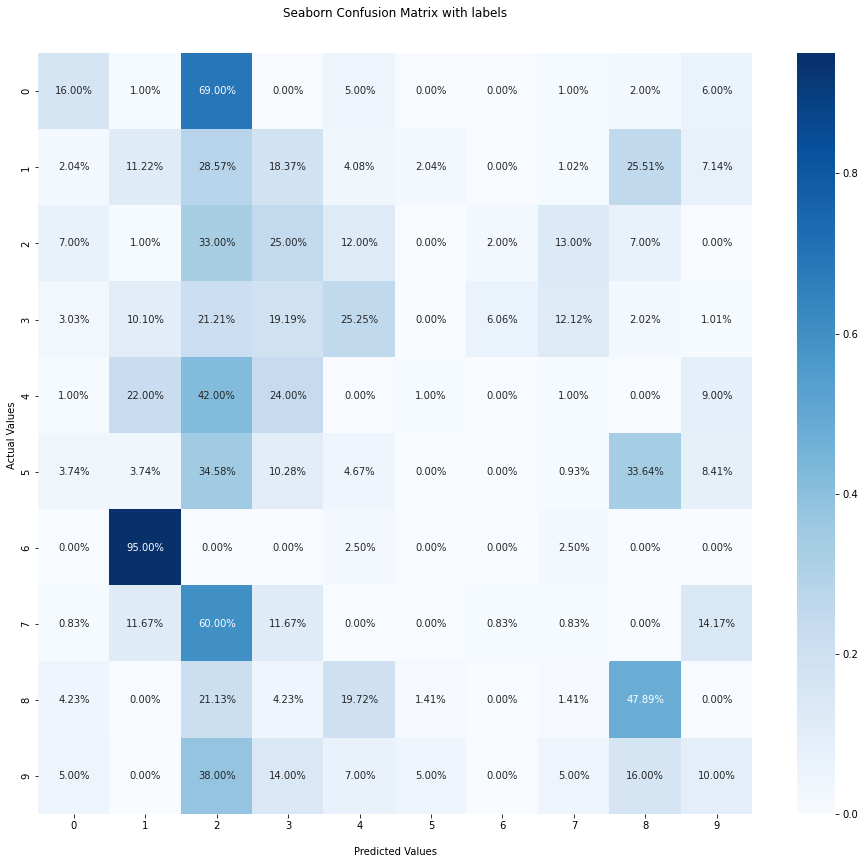

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp_3_test5, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

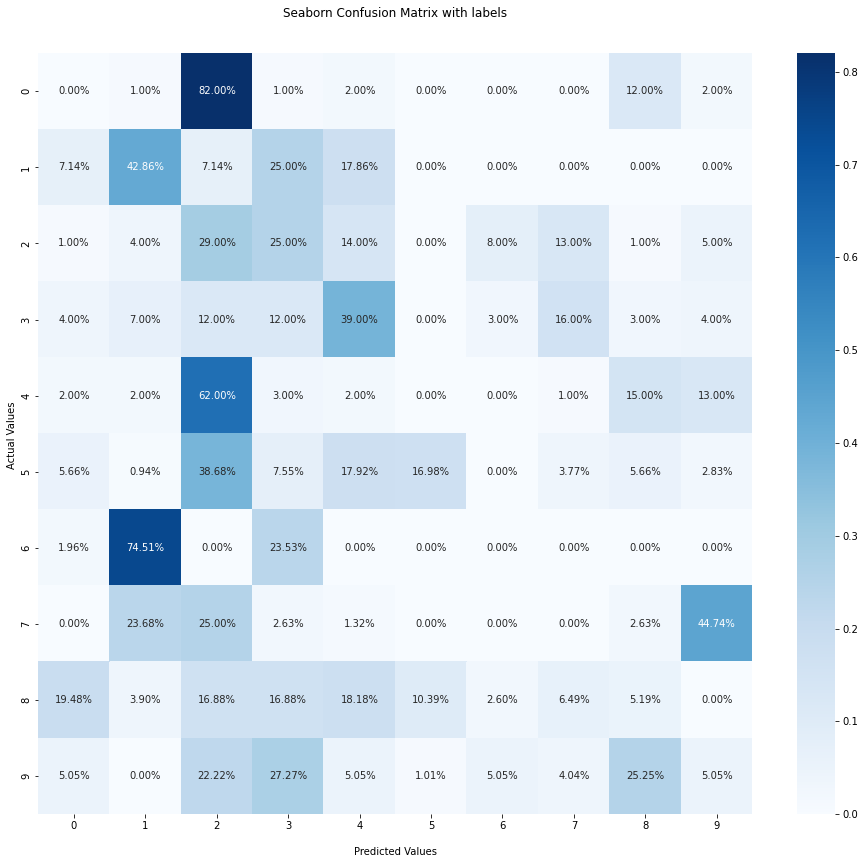

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp_3_test7, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

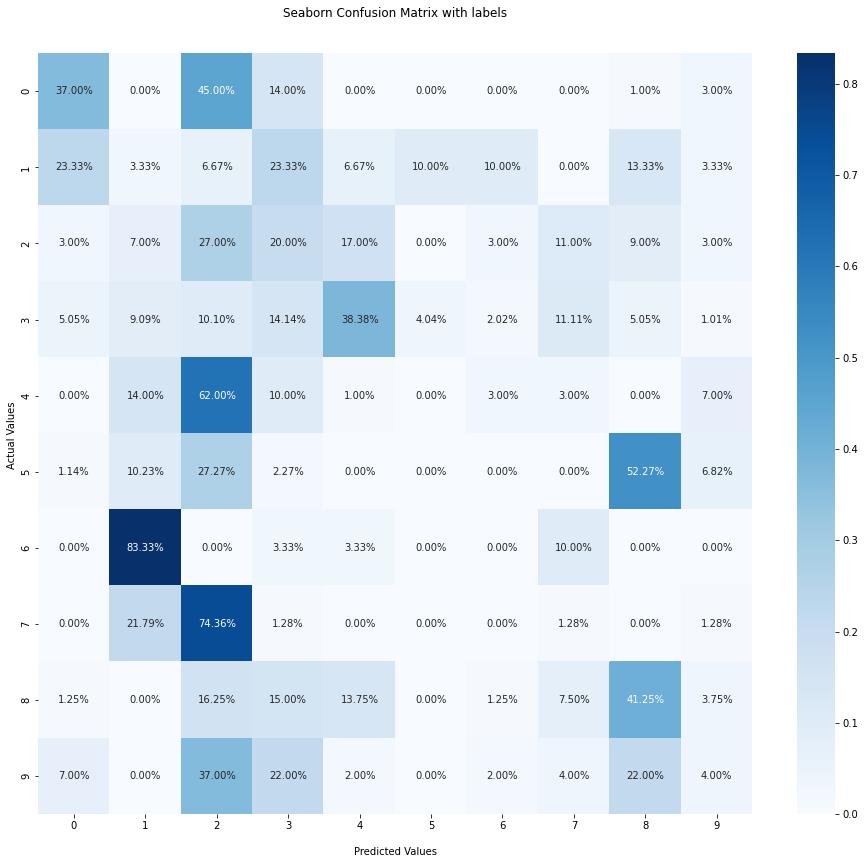

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp_3_test8, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

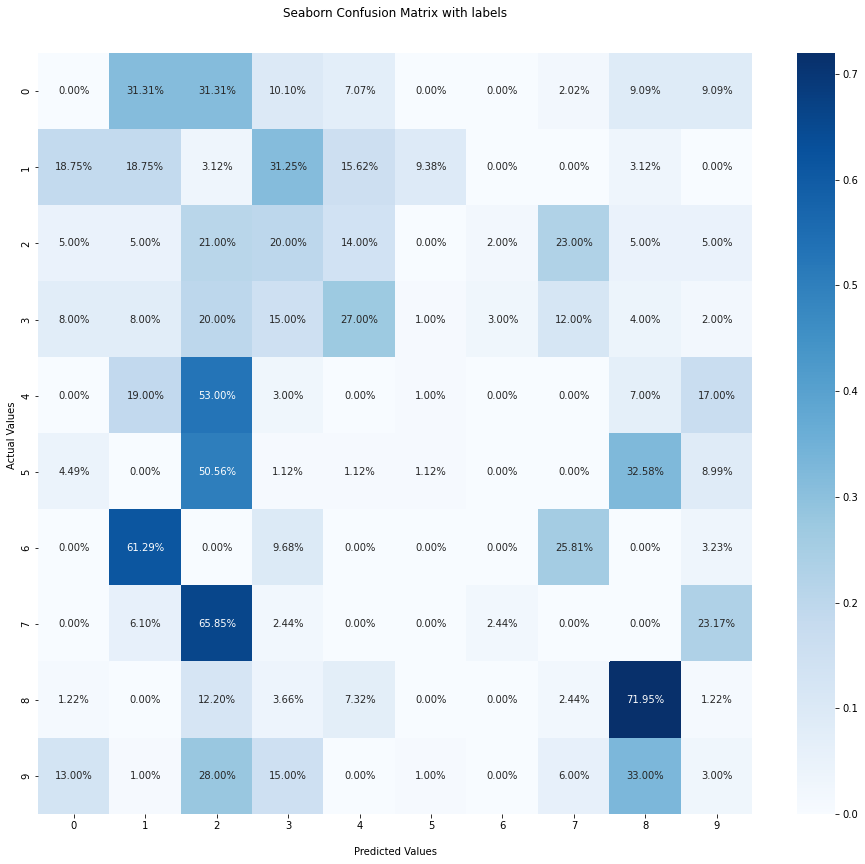

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp_3_test9, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

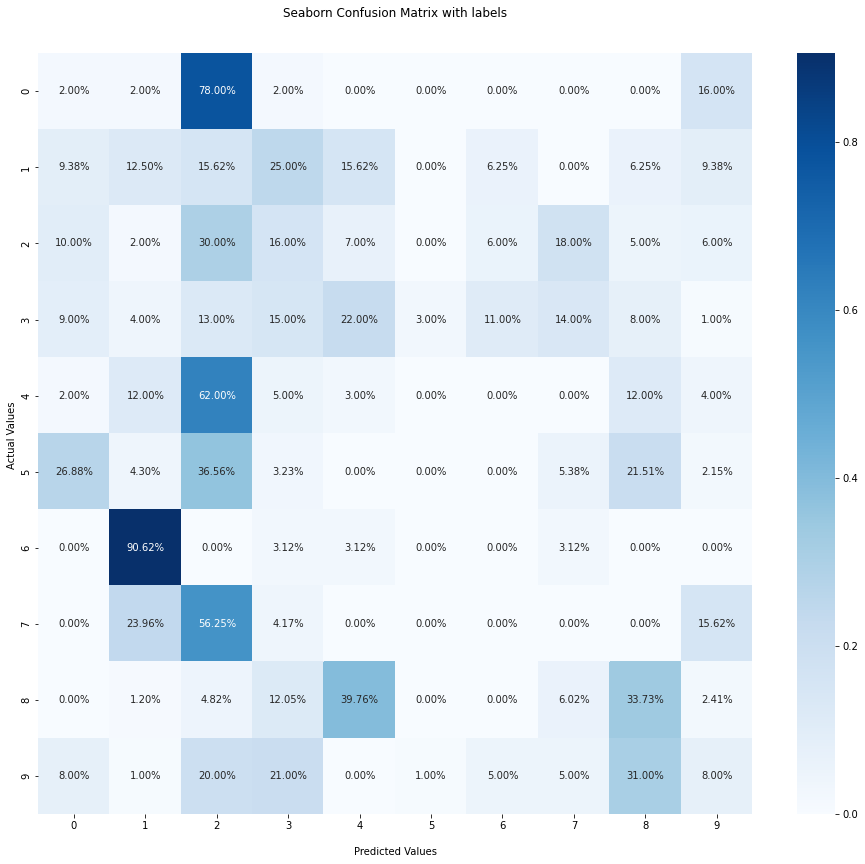

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()

ax = sns.heatmap(cmn_mlp_3_test10, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_5, y_pred5_mlp_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.36      0.31      0.33       500
           1       0.09      0.19      0.12       221
           2       0.08      0.23      0.12       500
           3       0.15      0.16      0.16       500
           4       0.01      0.01      0.01       500
           5       0.80      0.03      0.06       483
           6       0.00      0.00      0.00       184
           7       0.01      0.00      0.01       452
           8       0.16      0.18      0.17       393
           9       0.18      0.02      0.04       500

    accuracy                           0.12      4233
   macro avg       0.18      0.11      0.10      4233
weighted avg       0.20      0.12      0.11      4233



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_7, y_pred7_mlp_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.14      0.43      0.21        28
           2       0.10      0.29      0.15       100
           3       0.11      0.12      0.11       100
           4       0.02      0.02      0.02       100
           5       0.67      0.17      0.27       106
           6       0.00      0.00      0.00        51
           7       0.00      0.00      0.00        76
           8       0.06      0.05      0.06        77
           9       0.08      0.05      0.06        99

    accuracy                           0.10       837
   macro avg       0.12      0.11      0.09       837
weighted avg       0.13      0.10      0.09       837



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_8, y_pred8_mlp_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.61      0.37      0.46       100
           1       0.01      0.03      0.02        30
           2       0.10      0.27      0.14       100
           3       0.14      0.14      0.14        99
           4       0.01      0.01      0.01       100
           5       0.00      0.00      0.00        88
           6       0.00      0.00      0.00        30
           7       0.03      0.01      0.02        78
           8       0.28      0.41      0.33        80
           9       0.14      0.04      0.06       100

    accuracy                           0.15       805
   macro avg       0.13      0.13      0.12       805
weighted avg       0.15      0.15      0.14       805



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_9, y_pred9_mlp_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.06      0.19      0.10        32
           2       0.08      0.21      0.12       100
           3       0.18      0.15      0.16       100
           4       0.00      0.00      0.00       100
           5       0.14      0.01      0.02        89
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00        82
           8       0.40      0.72      0.52        82
           9       0.05      0.03      0.04       100

    accuracy                           0.13       815
   macro avg       0.09      0.13      0.09       815
weighted avg       0.10      0.13      0.10       815



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_10, y_pred10_mlp_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.03      0.02      0.03       100
           1       0.05      0.12      0.07        32
           2       0.10      0.30      0.15       100
           3       0.18      0.15      0.16       100
           4       0.04      0.03      0.04       100
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00        96
           8       0.26      0.34      0.30        83
           9       0.14      0.08      0.10       100

    accuracy                           0.11       836
   macro avg       0.08      0.10      0.08       836
weighted avg       0.09      0.11      0.09       836



## CNN

In [ ]:
# Validate the model on test dataset to determine generalization
cnn_3_test5 = cnn_1.evaluate(X_test_img_5, y_test_img_5, verbose=0)
print("\n Fold 5 Test accuracy: %.1f%%" % (100.0 * cnn_3_test5[1]))
print("\nFold 5 Test loss: %f" % (cnn_3_test5[0]))


 Fold 5 Test accuracy: 37.8%

Fold 5 Test loss: 4.156046


In [ ]:
# Validate the model on test dataset to determine generalization
cnn_3_test7 = cnn_3.evaluate(X_test_img_7, y_test_img_7, verbose=0)
print("\nFold 7 Test accuracy: %.1f%%" % (100.0 * cnn_3_test7[1]))
print("\nFold 7 Test loss: %f" % (cnn_3_test7[0]))


Fold 7 Test accuracy: 38.7%

Fold 7 Test loss: 2.279649


In [ ]:
# Validate the model on test dataset to determine generalization
cnn_3_test8 = cnn_3.evaluate(X_test_img_8, y_test_img_8, verbose=0)
print("\nFold 8 Test accuracy: %.1f%%" % (100.0 * cnn_3_test8[1]))
print("\nFold 8 Test loss: %f" % (cnn_3_test8[0]))


Fold 8 Test accuracy: 51.7%

Fold 8 Test loss: 1.888935


In [ ]:
# Validate the model on test dataset to determine generalization
cnn_3_test9 = cnn_3.evaluate(X_test_img_9, y_test_img_9, verbose=0)
print("\nFold 9 Test accuracy: %.1f%%" % (100.0 * cnn_3_test9[1]))
print("\nFold 9 Test loss: %f" % (cnn_3_test9[0]))


Fold 9 Test accuracy: 47.5%

Fold 9 Test loss: 2.771237


In [ ]:
# Validate the model on test dataset to determine generalization
cnn_3_test10 = cnn_3.evaluate(X_test_img_10, y_test_img_10, verbose=0)
print("\nFold 10 Test accuracy: %.1f%%" % (100.0 * cnn_3_test10[1]))
print("\nFold 10 Test loss: %f" % (cnn_3_test10[0]))


Fold 10 Test accuracy: 46.8%

Fold 10 Test loss: 1.976419


In [ ]:
def test_scores_cnn(model):
  cnn_score5 = model.evaluate(X_test_img_5, y_test_img_5 )
  cnn_score7 = model.evaluate(X_test_img_7, y_test_img_7)
  cnn_score8 = model.evaluate(X_test_img_8, y_test_img_8)
  cnn_score9 = model.evaluate(X_test_img_9, y_test_img_9)
  cnn_score10 = model.evaluate(X_test_img_10, y_test_img_10)
  test_scores_cnn = [cnn_score5[1],cnn_score7[1],cnn_score8[1],cnn_score9[1],cnn_score10[1]]
  
  return test_scores_cnn

In [ ]:
cnn_3_testscore = test_scores_cnn(cnn_3)

27/27 [==============================] - 6s 235ms/step - loss: 1.9764 - sparse_categorical_accuracy: 0.4683


In [ ]:
type(cnn_3_testscore)

list

In [ ]:
print((np.mean(cnn_3_testscore), np.std(cnn_3_testscore)))

(0.4432847619056702, 0.05646603132885998)


In [ ]:
ypred5_cnn_3 = np.argmax(cnn_3.predict(X_test_img_5), axis=-1)
ypred7_cnn_3 = np.argmax(cnn_3.predict(X_test_img_7), axis=-1)
ypred8_cnn_3 = np.argmax(cnn_3.predict(X_test_img_8), axis=-1)
ypred9_cnn_3 = np.argmax(cnn_3.predict(X_test_img_9), axis=-1)
ypred10_cnn_3 = np.argmax(cnn_3.predict(X_test_img_10), axis=-1)

In [ ]:
# Confusion Matrix CNN_3 on test datset
cm_cnn3_test5 = confusion_matrix(y_test_img_5, ypred5_cnn_3 )
cm_cnn3_test7 = confusion_matrix(y_test_img_7, ypred7_cnn_3 )
cm_cnn3_test8 = confusion_matrix(y_test_img_8, ypred8_cnn_3 )
cm_cnn3_test9 = confusion_matrix(y_test_img_9, ypred9_cnn_3 )
cm_cnn3_test10 = confusion_matrix(y_test_img_10, ypred10_cnn_3 )

In [ ]:
# Normalise the Confusion Matrix of each testing fold
cmn_test5 = cm_cnn3_test5.astype('float')/cm_cnn3_test5.sum(axis=1)[:, np.newaxis]
cmn_test7 = cm_cnn3_test7.astype('float')/cm_cnn3_test7.sum(axis=1)[:, np.newaxis]
cmn_test8 = cm_cnn3_test8.astype('float')/cm_cnn3_test8.sum(axis=1)[:, np.newaxis]
cmn_test9 = cm_cnn3_test9.astype('float')/cm_cnn3_test9.sum(axis=1)[:, np.newaxis]
cmn_test10 = cm_cnn3_test10.astype('float')/cm_cnn3_test10.sum(axis=1)[:, np.newaxis]

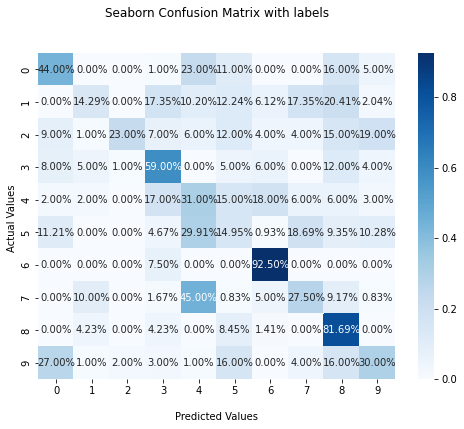

In [ ]:
# Plot Confusion Matrix for each fold
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_test5, annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

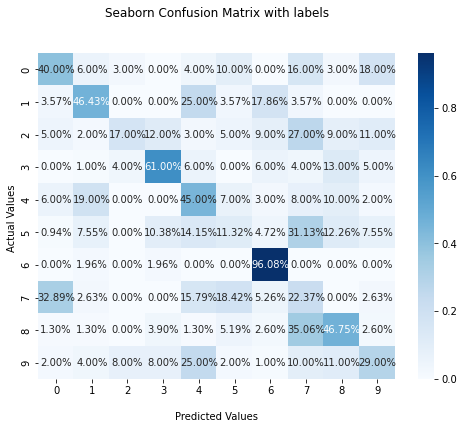

In [ ]:
# Plot Confusion Matrix for each fold
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_test7, annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

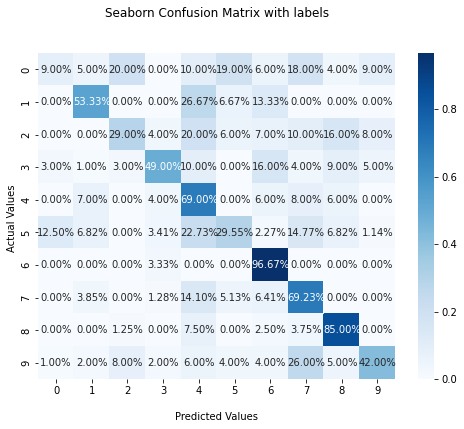

In [ ]:
# Plot Confusion Matrix for each fold
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_test8, annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

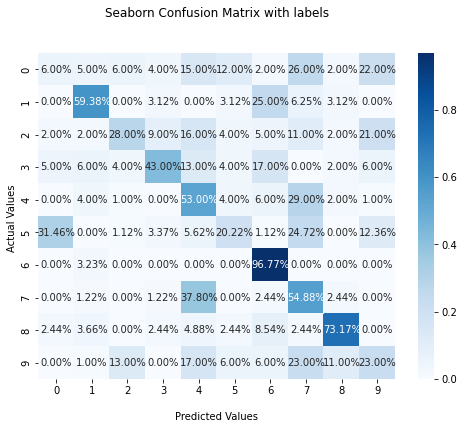

In [ ]:
# Plot Confusion Matrix for each fold
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_test9, annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

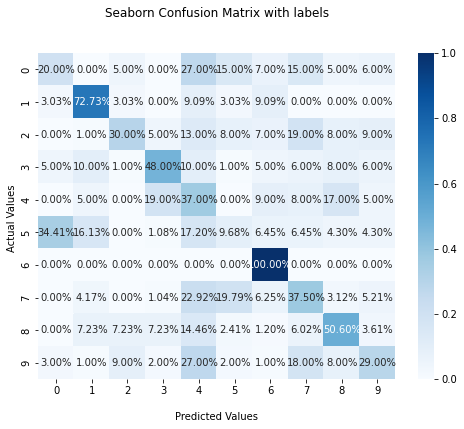

In [ ]:
# Plot Confusion Matrix for each fold
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax= plt.subplot()

ax = sns.heatmap(cmn_test10, annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1','2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_img_5, ypred5_cnn_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.37      0.10      0.16       100
           1       0.26      0.22      0.24        98
           2       0.40      0.17      0.24       100
           3       0.64      0.47      0.54       100
           4       0.11      0.22      0.14       100
           5       0.22      0.14      0.17       107
           6       0.40      0.95      0.56        40
           7       0.34      0.48      0.40       120
           8       0.43      0.77      0.55        71
           9       0.32      0.12      0.17       100

    accuracy                           0.32       936
   macro avg       0.35      0.37      0.32       936
weighted avg       0.34      0.32      0.30       936



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_img_7, ypred7_cnn_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.49      0.40      0.44       100
           1       0.23      0.46      0.31        28
           2       0.53      0.17      0.26       100
           3       0.64      0.61      0.62       100
           4       0.38      0.45      0.41       100
           5       0.22      0.11      0.15       106
           6       0.58      0.96      0.73        51
           7       0.12      0.22      0.16        76
           8       0.38      0.47      0.42        77
           9       0.38      0.29      0.33       100

    accuracy                           0.38       838
   macro avg       0.39      0.41      0.38       838
weighted avg       0.40      0.38      0.37       838



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_img_8, ypred8_cnn_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.38      0.09      0.15       100
           1       0.40      0.53      0.46        30
           2       0.48      0.29      0.36       100
           3       0.77      0.49      0.60       100
           4       0.43      0.69      0.53       100
           5       0.43      0.30      0.35        88
           6       0.36      0.97      0.52        30
           7       0.40      0.69      0.50        78
           8       0.60      0.85      0.70        80
           9       0.65      0.42      0.51       100

    accuracy                           0.49       806
   macro avg       0.49      0.53      0.47       806
weighted avg       0.51      0.49      0.46       806



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_img_9, ypred9_cnn_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.14      0.06      0.08       100
           1       0.45      0.59      0.51        32
           2       0.53      0.28      0.37       100
           3       0.68      0.43      0.53       100
           4       0.34      0.53      0.42       100
           5       0.35      0.20      0.26        89
           6       0.36      0.97      0.52        31
           7       0.28      0.55      0.37        82
           8       0.73      0.73      0.73        82
           9       0.27      0.23      0.25       100

    accuracy                           0.40       816
   macro avg       0.41      0.46      0.40       816
weighted avg       0.41      0.40      0.38       816



In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('\nClassification Report \n')
print(classification_report(y_test_img_10, ypred10_cnn_3, target_names=['0','1','2', '3', '4', '5', '6', '7', '8', '9']))


Classification Report 

              precision    recall  f1-score   support

           0       0.33      0.20      0.25       100
           1       0.36      0.73      0.48        33
           2       0.58      0.30      0.39       100
           3       0.59      0.48      0.53       100
           4       0.22      0.37      0.28       100
           5       0.16      0.10      0.12        93
           6       0.42      1.00      0.59        32
           7       0.32      0.38      0.34        96
           8       0.44      0.51      0.47        83
           9       0.43      0.29      0.35       100

    accuracy                           0.37       837
   macro avg       0.38      0.43      0.38       837
weighted avg       0.38      0.37      0.36       837

